# Setup
Run code here before everything else

In [ ]:
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor': "w"}
%load_ext autoreload
%autoreload 2

In [ ]:
# Setup
import sys
import os

wd_path = "/home/dk538/rds/hpc-work/pico"
sys.path.append(wd_path)

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import pyreadr
import json
import urllib.request

# from models.clinical import ClinicalLogisticRegression, ClinicalRandomForest, ClinicalSVC

plt.style.use("default")
sns.set()
sns.set_theme(
    context="paper",
    style="ticks",
    palette="colorblind",
    rc={
        "axes.linewidth": 1,
        "xtick.major.width": 1,
        "ytick.major.width": 1,
        "axes.edgecolor": "grey",
        "xtick.labelcolor": "black",
        "xtick.color": "grey",
        "ytick.labelcolor": "black",
        "ytick.color": "grey",
    },
)
import matplotlib.font_manager as fm

# Download the font
font_url = "https://github.com/adobe-fonts/source-sans/blob/release/TTF/SourceSans3-Regular.ttf?raw=True"
font_path = f"{wd_path}/results_analysis/figures/SourceSans3-Regular.ttf"  # Specify where to save the font
font_bold_url = "https://github.com/adobe-fonts/source-sans/blob/release/TTF/SourceSans3-Bold.ttf?raw=True"
font_bold_path = f"{wd_path}/results_analysis/figures/SourceSans3-Bold.ttf"  # Specify where to save the font
font_it_url = "https://github.com/adobe-fonts/source-sans/blob/release/TTF/SourceSans3-It.ttf?raw=True"
font_it_path = f"{wd_path}/results_analysis/figures/SourceSans3-It.ttf"  # Specify where to save the font
urllib.request.urlretrieve(font_url, font_path)
urllib.request.urlretrieve(font_bold_url, font_bold_path)
urllib.request.urlretrieve(font_it_url, font_it_path)

# in a terminal, run
# cp ~/rds/hpc-work/graphdep/results_analysis/figures/*ttf ~/.local/share/fonts
# fc-cache -f -v
# rm -fr ~/.cache/matplotlib

# Then restart Jupyter kernel

fm.findfont("Source Sans 3", rebuild_if_missing=True)
# fm.findfont("Source Sans 3:style=italic", rebuild_if_missing=True)

# Set font globally for Matplotlib
from matplotlib import rc

plt.style.use("default")
sns.set_theme(
    context="paper",
    style="ticks",
    palette="colorblind",
    rc={
        "axes.linewidth": 1,
        "xtick.major.width": 1,
        "ytick.major.width": 1,
        "axes.edgecolor": "grey",
        "xtick.labelcolor": "black",
        "xtick.color": "grey",
        "ytick.labelcolor": "black",
        "ytick.color": "grey",
    },
)

rc("font", **{"family": "sans-serif", "sans-serif": ["Source Sans 3"]})
plt.rcParams["mathtext.fontset"] = "custom"
plt.rcParams["mathtext.it"] = "Source Sans 3:italic"

/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 4 External validation using TransNEO + PBCP (Sammut et al. 2021)

## 4.0 Data loading and preprocessing

### 4.0.1 Data loading

In [ ]:
data_path = f"{wd_path}/data/transneo"

os.makedirs(data_path, exist_ok=True)

## DATA DOWNLOAD
if not os.path.exists(f"{data_path}/transneo-diagnosis-RNAseq-rawcounts.tsv.gz"):
    urllib.request.urlretrieve(
        "https://github.com/cclab-brca/neoadjuvant-therapy-response-predictor/raw/refs/heads/master/data/transneo-diagnosis-RNAseq-rawcounts.tsv.gz",
        f"{data_path}/transneo-diagnosis-RNAseq-rawcounts.tsv.gz",
    )
if not os.path.exists(f"{data_path}/transneo-diagnosis-RNAseq-validTPM.Rdata"):
    urllib.request.urlretrieve(
        "https://github.com/cclab-brca/neoadjuvant-therapy-response-predictor/raw/refs/heads/master/data/transneo-diagnosis-RNAseq-validTPM.Rdata",
        f"{data_path}/transneo-diagnosis-RNAseq-validTPM.Rdata",
    )
if not os.path.exists(f"{data_path}/testing_her2pos_df.csv"):
    urllib.request.urlretrieve(
        "https://raw.githubusercontent.com/micrisor/NAT-ML/refs/heads/main/inputs/testing_her2pos_df.csv",
        f"{data_path}/testing_her2pos_df.csv",
    )
if not os.path.exists(f"{data_path}/testing_her2neg_df.csv"):
    urllib.request.urlretrieve(
        "https://raw.githubusercontent.com/micrisor/NAT-ML/refs/heads/main/inputs/testing_her2neg_df.csv",
        f"{data_path}/testing_her2neg_df.csv",
    )
if not os.path.exists(f"{data_path}/training_df.csv"):
    urllib.request.urlretrieve(
        "https://raw.githubusercontent.com/micrisor/NAT-ML/refs/heads/main/inputs/training_df.csv",
        f"{data_path}/training_df.csv",
    )
# ENSEMBL ID to HGNC map and gene lengths (provided in github repo)
if not os.path.exists(f"{data_path}/gene_lengths.txt"):
    raise ValueError(
        "gene_lengths.txt not present. Please download from PiCo github repo."
    )

## DATA LOADING
# Combine training and validation data
feat_df = (
    pd.read_csv(f"{data_path}/training_df.csv")
    .drop("Unnamed: 0", axis=1)
    .set_index("Trial.ID")
)
feat_df_val_1 = (
    pd.read_csv(f"{data_path}/testing_her2neg_df.csv")
    .drop("Unnamed: 0", axis=1)
    .set_index("Trial.ID")
)
feat_df_val_2 = pd.read_csv(f"{data_path}/testing_her2pos_df.csv").set_index("Trial.ID")
feat_df_val = pd.concat([feat_df_val_1, feat_df_val_2], axis=0)

### 4.0.2 RNASeq: Counts to TPM

In [5]:
def normalize_expression(
    X: pd.DataFrame, method: str = "tpm", length: pd.Series = None
):
    """
    # TPM
    Transcripts Per Kilobase Million
        (1) Divide the read counts by the length of each gene in kilobases. This gives you reads per kilobase (RPK).
        (2) Count up all the RPK values in a sample and divide this number by 1,000,000. This is your “per million” scaling factor.
        (3) Divide the RPK values by the “per million” scaling factor. This gives you TPM.

    # Notes:
    Proper pseudocount addition would be the following as shown by metagenomeSeq's MRcounts
    log(X_normalized + 1)
    """
    if method is None:
        return X

    method = method.lower()

    # Lengths
    if method in {"fpkm", "rpkm", "rpk", "tpm"}:
        assert length is not None, (
            "If FPKM, RPKM, TPM, or GeTMM is chosed as the method then `length` cannot be None.  It must be either a pd.Series of sequences or sequence lengths"
        )
        length = pd.Series(length)[X.columns]
        assert length.isnull().sum() == 0, (
            "Not all of the genes in `X.columns` are in `length.index`.  Either use a different normalization or get the missing sequence lengths"
        )
        # If sequences are given then convert to length (assumes CDS and no introns)
        if pd.api.types.is_string_dtype(length):
            length = length.map(len)

    # FPKM, RPKM, and TPM normalization
    if method in {"fpkm", "rpkm", "rpk", "tpm"}:
        # Set up variables
        C = X.values
        L = length.values
        N = X.sum(axis=1).values.reshape(-1, 1)

        if method in {"fpkm", "rpkm"}:
            # Compute operations
            numerator = 1e9 * C
            denominator = N * L
            return pd.DataFrame(
                numerator / denominator, index=X.index, columns=X.columns
            )

        if method in {"rpk", "tpm"}:
            rpk = C / L
            if method == "rpk":
                return pd.DataFrame(rpk, index=X.index, columns=X.columns)
            if method == "tpm":
                per_million_scaling_factor = (rpk.sum(axis=1) / 1e6).reshape(-1, 1)
                return pd.DataFrame(
                    rpk / per_million_scaling_factor, index=X.index, columns=X.columns
                )


def counts_to_tpm(counts_df, lengths_df):
    gene_int = sorted(list(set(counts_df.columns).intersection(lengths_df["gene"])))
    counts_df_filt = counts_df[gene_int]
    lengths = lengths_df.set_index("gene").loc[gene_int]
    # If multiple canonical transcripts take the longest one
    lengths = lengths.groupby(lengths.index).max()["length"]
    tpm_df = normalize_expression(counts_df, method="tpm", length=lengths)
    return tpm_df


# Load RNASeq raw counts -- training data
raw_counts = (
    pd.read_csv(f"{data_path}/transneo-diagnosis-RNAseq-rawcounts.tsv.gz", sep="\t")
    .set_index("Unnamed: 0")
    .transpose()
)


lengths = pd.read_csv(f"{data_path}/gene_lengths.txt", sep="\t")

# Uncomment if using a BioMART export
# The file included is as used in Sammut et al.

# lengths = lengths[lengths["Ensembl Canonical"] == 1.0]

# gene_int = set(raw_counts.columns).intersection(lengths["Gene stable ID"])
# lengths_df = pd.DataFrame(
#     {
#         "gene": lengths["Gene stable ID"],
#         "length": lengths["Transcript length (including UTRs and CDS)"],
#     }
# )
tpm = counts_to_tpm(raw_counts, lengths)
log_tpm = np.log2(tpm + 1)
exp_df = log_tpm

In [6]:
exp_df

Unnamed: 0,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000273481,ENSG00000273483,ENSG00000273484,ENSG00000273485,ENSG00000273486,ENSG00000273487,ENSG00000273488,ENSG00000273489,ENSG00000273492,ENSG00000273493
T001,3.519219,0.043860,5.627077,3.803914,2.782791,2.627301,3.227502,5.458059,2.257565,4.515342,...,0.000000,0.694506,0.0,0.613069,0.845450,0.000000,1.145451,0.019090,1.778807,0.000000
T002,5.985691,0.858624,6.151412,3.198860,2.508868,3.172467,4.738117,6.629569,2.915485,5.126617,...,0.000000,0.346559,0.0,0.948664,1.293643,0.306026,1.505287,0.129071,1.743704,0.360000
T003,3.373384,0.041881,6.322846,4.124499,3.414833,4.477775,3.974584,6.222665,3.913116,5.975721,...,0.135656,0.797031,0.0,0.954828,1.676510,0.242916,1.817051,0.106030,0.000000,0.387296
T004,4.361243,0.230972,6.338907,2.508802,2.187357,3.862985,4.036644,6.131343,3.497267,5.704309,...,0.301545,1.666163,0.0,1.015169,2.497710,0.602991,3.011836,0.274749,0.379478,1.062885
T005,5.053705,0.522715,6.530516,3.227032,2.993319,2.227446,3.878541,5.797569,3.989687,5.558569,...,0.256861,1.297358,0.0,0.651396,1.339546,0.984536,2.307121,0.087882,0.000000,1.148833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
T174,4.777983,0.138000,5.990842,4.566715,3.394019,2.210553,3.151047,5.225450,3.008344,5.812819,...,0.224031,0.461533,0.0,0.516485,1.434786,1.209372,2.672430,0.162361,0.617006,0.000000
T175,4.764430,0.809162,6.606458,4.360559,2.711514,3.540924,6.139988,5.925499,3.729694,5.447748,...,0.930840,1.949640,0.0,0.668889,2.218233,0.953531,2.314441,0.142567,0.852618,1.529732
T176,3.636390,1.567460,6.303735,2.967594,2.068254,2.265331,4.037236,4.450471,2.629574,4.101066,...,0.264505,1.635694,0.0,0.316761,1.895497,1.676163,1.193868,0.061066,0.022594,1.033860
T178,5.832561,0.556679,6.592024,3.573071,3.044092,1.337756,3.681236,4.825005,3.835948,5.140181,...,0.135545,1.218104,0.0,0.282567,1.820610,0.562071,1.978814,0.088817,1.298899,0.387006


In [7]:
# exp_df.to_csv("../data/transneo_exp_train.csv")

In [8]:
# np.savetxt("./ext_val_sammut/raw_counts_ensg.txt", raw_counts.columns.astype(str).tolist(), fmt="%s")

In [9]:
# lengths["HGNC symbol"].to_csv("./ext_val_sammut/train_genes.txt", index=False)

In [10]:
# Convert genes to HGNC symbol from BioMART export (not used)

# exp_df = exp_df.rename(
#     columns=dict(zip(lengths["Gene stable ID"], lengths["HGNC symbol"]))
# )

In [11]:
# Load RNASeq log2TPM for validation set
exp_df_val = pyreadr.read_r(
    "../data/transneo/transneo-diagnosis-RNAseq-validTPM.Rdata"
)[None]
# Convert to CCLE format (log2(TPM+1))
exp_df_val = np.log2(2**exp_df_val + 1)

In [12]:
# This has gene symbols, so we want to check these and then convert back to ENSG
exp_df_val

,T177,T179,T182,T183,T184,T185,T186,T187,T188,T189,...,A524,A530,A538,A565,A581,A637,A665,A710,A734,A767
rownames,,,,,,,,,,,,,,,,,,,,,
5S_rRNA,2.632478,2.598079,2.426050,2.707657,0.001442,2.891419,2.079361,2.341160,2.721329,2.056549,...,1.720760,1.896233,2.871410,0.001442,1.240436,2.744161,1.080726,1.093966,0.771886,1.584241
7SK,4.067097,2.948377,2.268315,3.549349,0.001442,2.306379,2.543496,2.424573,3.392675,2.310253,...,2.002090,1.732226,1.539035,2.635081,2.612518,1.543496,1.740971,1.444826,2.169668,3.207112
A1BG,0.605305,0.037593,0.246469,0.194087,0.034497,0.131458,0.271067,0.063227,0.298424,0.376846,...,0.117695,0.169412,0.817214,0.147176,0.442439,0.408821,0.407516,0.340163,0.509949,0.205017
A1BG-AS1,3.142136,1.317188,3.270738,1.212818,0.678973,1.528321,1.825501,1.658234,2.886316,3.011871,...,2.561326,3.607105,3.637564,2.617651,3.615605,3.973079,3.684291,3.821567,3.747441,3.505929
A2M,7.114453,9.199410,6.875298,6.718693,6.787331,7.843169,7.433624,7.092358,6.969443,7.809815,...,8.168453,7.289954,7.875360,8.934154,9.540302,8.424567,7.985116,8.251805,8.494549,8.602039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11A,2.280036,3.625013,0.555325,2.687285,4.971065,2.635847,3.736778,1.987030,3.381809,2.223052,...,0.737600,1.002450,0.149520,0.479644,0.282143,3.186881,2.957469,2.643140,0.202512,0.333309
ZYG11B,3.987448,4.707586,3.962188,3.797729,4.266284,4.607188,4.006433,4.231747,3.770533,4.066873,...,3.646186,2.972987,3.512733,3.579603,4.594692,4.486856,4.317217,4.042198,4.132602,4.035589
ZYX,5.738098,6.233386,4.618949,4.030636,4.035694,6.725310,6.177832,6.297600,6.047709,6.839146,...,7.265107,6.136565,7.145204,6.462643,7.646122,7.327399,6.370218,6.826915,6.452040,7.461817


In [13]:
# Creates a file for HGNC multi-symbol checker
exp_df_val.reset_index()["rownames"].to_csv(
    "../data/transneo/val_genes.txt", header=None, sep="\t", index=False
)

In [14]:
# Go to HGNC multi-symbol checker and upload the above file (https://www.genenames.org/tools/multi-symbol-checker/), then load the result
hgnc_symbol_check = pd.read_csv("../data/transneo/hgnc_symbol_checker.csv", header=1)
# Get mapping of HGNC symbol from BioMART (https://www.ensembl.org/biomart/martview) and load (this uses current approved symbols)
# Both files downloaded 16/12/24
hgnc_to_ensg = pd.read_csv(
    "../data/transneo/biomart_hgnc_to_ensg.csv"
)  # .set_index("HGNC ID")

In [15]:
hgnc_symbol_check_map = {
    row["Input"]: row["Approved symbol"] for ind, row in hgnc_symbol_check.iterrows()
}
hgnc_to_ensg_map = {
    row["HGNC symbol"]: row["Gene stable ID"] for ind, row in hgnc_to_ensg.iterrows()
}

In [16]:
# Map rownames to approved symbols, then map to ENSG, then transpose for rows as samples
exp_df_val = exp_df_val.rename(hgnc_symbol_check_map, axis=0)
exp_df_val = exp_df_val.rename(hgnc_to_ensg_map, axis=0).transpose()

In [17]:
# exp_df.transpose().reset_index().groupby("Unnamed: 0").max().transpose().dropna(axis=1, how="all")
# exp_df_val.transpose().reset_index().groupby("rownames").max().transpose().dropna(axis=1, how="all")

### 4.0.3 RNASeq: Preprocessing

In [18]:
# Get intersection of genes in exp and exp_val
# Remove duplicate genes by taking mean
exp_df_val = (
    exp_df_val.transpose()
    .reset_index()
    .groupby("rownames")
    .mean()
    .transpose()
    .dropna(axis=1, how="all")
)
exp_df = (
    exp_df.transpose()
    .reset_index()
    .groupby("Unnamed: 0")
    .mean()
    .transpose()
    .dropna(axis=1, how="all")
)
# Get intersection of columns
shared_genes = sorted(list(set(exp_df_val.columns).intersection(set(exp_df.columns))))
exp_df = exp_df[shared_genes]
exp_df_val = exp_df_val[shared_genes]

In [24]:
exp_df

Unnamed: 0,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,ENSG00000001460,...,ENSG00000273032,ENSG00000273045,ENSG00000273079,ENSG00000273252,ENSG00000273274,ENSG00000273297,ENSG00000273311,ENSG00000273313,ENSG00000273336,ENSG00000273344
T001,3.519219,0.043860,5.627077,2.782791,2.627301,3.227502,5.458059,2.257565,4.515342,1.447750,...,0.194154,1.247276,0.013112,0.000000,0.000000,0.058307,0.780993,0.255052,0.000000,3.713273
T002,5.985691,0.858624,6.151412,2.508868,3.172467,4.738117,6.629569,2.915485,5.126617,2.538219,...,0.100701,0.681068,0.174144,1.967108,0.024326,0.626047,1.343532,0.000000,0.218819,4.981310
T003,3.373384,0.041881,6.322846,3.414833,4.477775,3.974584,6.222665,3.913116,5.975721,2.194061,...,0.055575,1.330244,0.002512,0.171797,0.005321,0.394887,1.621847,0.000000,0.775502,2.934052
T004,4.361243,0.230972,6.338907,2.187357,3.862985,4.036644,6.131343,3.497267,5.704309,1.810818,...,0.379566,1.136951,0.281768,0.200487,0.132032,1.229889,0.660646,0.000000,0.000000,2.786185
T005,5.053705,0.522715,6.530516,2.993319,2.227446,3.878541,5.797569,3.989687,5.558569,2.793721,...,0.000000,2.128698,0.002482,0.584888,0.041544,0.891945,0.996341,0.790321,0.768464,3.784132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
T174,4.777983,0.138000,5.990842,3.394019,2.210553,3.151047,5.225450,3.008344,5.812819,2.132071,...,0.181214,2.890009,0.012793,0.000000,0.100850,0.223601,1.401831,0.000000,0.105412,3.330824
T175,4.764430,0.809162,6.606458,2.711514,3.540924,6.139988,5.925499,3.729694,5.447748,2.363934,...,0.084303,2.417051,0.072606,0.000000,0.120103,1.003606,1.652690,0.000000,0.125498,3.296468
T176,3.636390,1.567460,6.303735,2.068254,2.265331,4.037236,4.450471,2.629574,4.101066,1.016592,...,0.128974,1.492926,0.038807,0.000000,0.091341,0.075256,0.860798,0.000000,0.240732,3.915176
T178,5.832561,0.556679,6.592024,3.044092,1.337756,3.681236,4.825005,3.835948,5.140181,2.115554,...,0.028032,3.056127,0.005014,0.000000,0.067632,0.632732,0.447653,0.000000,0.122868,4.327005


In [19]:
exp_df_val

rownames,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,ENSG00000001460,...,ENSG00000273032,ENSG00000273045,ENSG00000273079,ENSG00000273252,ENSG00000273274,ENSG00000273297,ENSG00000273311,ENSG00000273313,ENSG00000273336,ENSG00000273344
T177,2.976364,0.212756,5.285214,3.143132,2.446256,3.594202,4.199853,3.090227,5.021697,1.490775,...,0.527149,0.107420,0.025454,0.001442,0.024036,0.420617,2.489723,0.001442,1.337540,2.939527
T179,4.626544,0.325732,6.180285,4.061914,3.691344,3.605682,5.921436,3.164947,4.825312,1.532866,...,0.359843,0.118626,0.054223,0.126048,0.024036,1.143393,1.931418,0.093425,0.327687,3.539122
T182,2.828632,0.164143,6.507763,2.265347,1.404195,3.164077,5.018323,2.570706,4.601851,0.994290,...,0.115483,0.078610,0.007196,0.001442,0.007626,0.127237,1.309409,0.147958,0.073957,1.493852
T183,2.945814,0.225892,5.259935,2.259212,1.323255,2.904452,4.197055,3.484963,4.453465,0.994580,...,0.430349,0.054779,0.029842,0.001442,0.001442,0.294194,2.042399,0.083656,0.796016,3.189983
T184,4.729705,0.001442,7.975376,5.533476,1.441483,3.311061,3.971396,3.640864,4.666995,1.081544,...,0.863095,0.067088,0.521453,0.001442,0.022190,0.001442,0.117828,0.001442,0.001442,0.059771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A637,5.509759,1.109427,7.080921,4.352038,3.217510,5.650620,6.454707,3.141874,6.940887,2.307283,...,0.775276,0.123136,0.033088,2.367734,0.040402,1.002378,1.898673,1.245982,0.001442,3.910013
A665,5.004960,2.701882,6.313790,3.480614,2.769116,5.344270,4.940895,3.384423,5.055512,2.209266,...,0.165693,0.150170,0.039981,0.001442,0.175940,0.325847,1.123335,0.001442,0.001442,3.947358
A710,6.203673,0.632454,6.059825,3.050606,2.272441,4.609678,5.754823,3.824249,5.671064,2.601435,...,0.193750,0.195096,0.017779,0.001442,0.040682,1.145156,1.274232,0.001442,0.414460,4.612205
A734,3.606726,0.142348,6.048642,2.340904,3.909476,3.224728,6.081446,4.817951,5.058204,2.194875,...,0.680525,0.059771,0.003602,0.001442,0.033511,0.694479,1.628400,0.001442,0.109026,4.802808


In [20]:
# Mean impute NAs from exp_df for both (mean across rows)
exp_df = exp_df.fillna(exp_df.mean(axis=0))
exp_df_val = exp_df_val.fillna(exp_df.mean(axis=0))

In [21]:
# print(len(shared_genes))
# np.savetxt(
#     fname="./ext_val_sammut/sammut_genes.csv", X=shared_genes, fmt="%s", delimiter=","
# )
# sammut_genes = pd.read_csv("./ext_val_sammut/sammut_genes.csv", header=None)[0].tolist()
# print(len(set(sammut_genes).symmetric_difference(shared_genes)))

In [22]:
# Save both to file
exp_df.to_csv("../data/transneo/transneo_exp_filt.csv")
exp_df_val.to_csv("../data/transneo/transneo_exp_filt_val.csv")

In [27]:
exp_df = pd.read_csv("../data/transneo/transneo_exp_filt.csv").set_index("Unnamed: 0")
exp_df_val = pd.read_csv("../data/transneo/transneo_exp_filt_val.csv").set_index(
    "Unnamed: 0"
)

### 4.0.4 RNASeq: Comparison to precomputed values

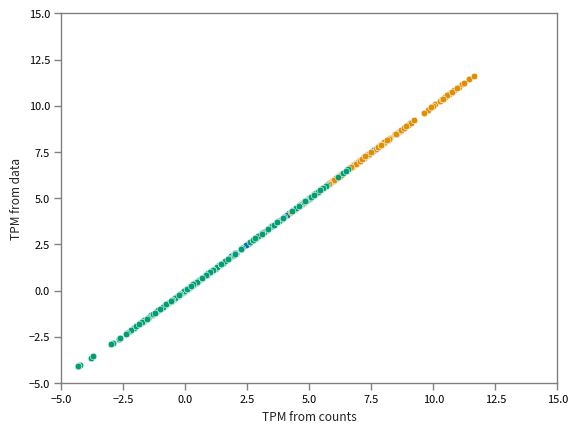

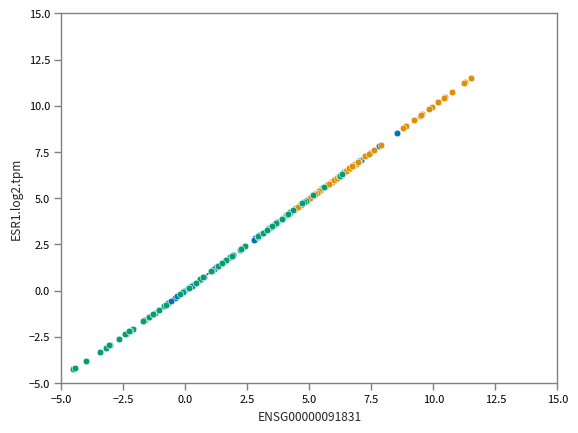

In [28]:
# COMPARE PROVIDED VS RECOMUPUTED EXPRESSION VALUES
f, ax = plt.subplots(1, 1)
comb_df = pd.merge(feat_df, exp_df, left_index=True, right_index=True)
comb_df_val = pd.merge(feat_df_val, exp_df_val, left_index=True, right_index=True)
comb_df["ENSG00000091831"] = np.log2(2 ** (comb_df["ENSG00000091831"]) - 1 + 0.001)
comb_df["ENSG00000141736"] = np.log2(2 ** comb_df["ENSG00000141736"] - 1 + 0.001)
comb_df["ENSG00000082175"] = np.log2(2 ** comb_df["ENSG00000082175"] - 1 + 0.001)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.set_xlim(-5, 15)
ax.set_ylim(-5, 15)
ax.set_xlabel("TPM from counts")
ax.set_ylabel("TPM from data")
ax.plot(lims, lims, "k-", alpha=0.75, zorder=0)
sns.scatterplot(data=comb_df, x="ENSG00000091831", y="ESR1.log2.tpm", ax=ax)
sns.scatterplot(data=comb_df, x="ENSG00000141736", y="ERBB2.log2.tpm", ax=ax)
sns.scatterplot(data=comb_df, x="ENSG00000082175", y="PGR.log2.tpm", ax=ax)
comb_df_val["ENSG00000091831"] = np.log2(2 ** comb_df_val["ENSG00000091831"] - 1)
comb_df_val["ENSG00000141736"] = np.log2(2 ** comb_df_val["ENSG00000141736"] - 1)
comb_df_val["ENSG00000082175"] = np.log2(2 ** comb_df_val["ENSG00000082175"] - 1)
f, ax = plt.subplots(1, 1)
sns.scatterplot(data=comb_df_val, x="ENSG00000091831", y="ESR1.log2.tpm", ax=ax)
sns.scatterplot(data=comb_df_val, x="ENSG00000141736", y="ERBB2.log2.tpm", ax=ax)
sns.scatterplot(data=comb_df_val, x="ENSG00000082175", y="PGR.log2.tpm", ax=ax)
ax.set_xlim(-5, 15)
ax.set_ylim(-5, 15)


# now plot both limits against eachother
ax.plot(lims, lims, "k-", alpha=0.75, zorder=0)

### 4.0.5 Constraint selection

In [5]:
from utils.data_utils import get_constraints
# Getting constraints related to each drug in FEC-T
# SELECTING CONSTRAINTS
# Consensus of both datasets -- get constraints for GDSC and CTRP

drugs_gdsc = ["5-FLUOROURACIL", "EPIRUBICIN", "CYCLOPHOSPHAMIDE", "PACLITAXEL"]
drugs_ctrp = ["FLUOROURACIL", "DOXORUBICIN", "CYCLOPHOSPHAMIDE", "PACLITAXEL"]
dataset_names = ["depmap_gdsc", "depmap_ctrp"]

constraints_dict = {}

for drug in drugs_gdsc:
    constraints = get_constraints(
        drug=drug,
        dataset_name="depmap_gdsc",
        zdim=512,
        experiment=None,
        col_thresh=1.0,
        wd_path=wd_path,
    )
    constraints_dict[f"{drug}_gdsc"] = constraints

for drug in drugs_ctrp:
    constraints = get_constraints(
        drug=drug,
        dataset_name="depmap_ctrp",
        zdim=512,
        experiment=None,
        col_thresh=1.0,
        wd_path=wd_path,
    )
    constraints_dict[f"{drug}_ctrp"] = constraints


Dataset created:                   
--------------------------------------------------
Data type                          Size
--------------------------------------------------
x                                  (1652, 19193)
s                                  (1652, 17931)
y                                  (1652, 1)
c                                  (1652, 4)
--------------------------------------------------
Correcting drug name to A5FLUOROURACIL...

Dataset created:                   
--------------------------------------------------
Data type                          Size
--------------------------------------------------
x                                  (1652, 19193)
s                                  (1652, 17931)
y                                  (1652, 1)
c                                  (1652, 4)
--------------------------------------------------

Dataset created:                   
--------------------------------------------------
Data type                         

In [6]:
# Load all the constraint dfs
constraint_dfs = []
for drug in drugs_gdsc:
    curr_df = pd.read_csv(
        f"{wd_path}/data/constraints/univar_lm_{drug}_lrt_IC50_depmap_gdsc_v2.csv"
    )
    curr_df["drug"] = drug
    curr_df["dataset_name"] = "depmap_gdsc"
    constraint_dfs.append(curr_df)

for drug in drugs_ctrp:
    curr_df = pd.read_csv(
        f"{wd_path}/data/constraints/univar_lm_{drug}_lrt_IC50_depmap_ctrp_v2.csv"
    )
    curr_df["drug"] = drug
    curr_df["dataset_name"] = "depmap_ctrp"
    constraint_dfs.append(curr_df)

constraint_df = pd.concat(constraint_dfs, axis=0)

In [13]:
# Filter by signifcance after correction
constraint_df_filt = constraint_df[constraint_df["p_corrected"] < 0.05]
# Count the occurrence of each gene across the datasets and drugs (max 8)
constraint_df_filt["count"] = constraint_df_filt.groupby("gene")["gene"].transform(
    "count"
)
# Print these, grouped by count and sorted by corrected p val within each count
constraint_df_filt.sort_values(["dataset_name", "drug", "p_corrected"]).groupby(
    ["dataset_name", "drug"]
).head(200000).sort_values(by=["count", "p_corrected"], ascending=[False, True]).head(
    50
)

/tmp/ipykernel_1308931/1225447903.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  constraint_df_filt["count"] = constraint_df_filt.groupby("gene")["gene"].transform("count")


,Unnamed: 0,gene,lr,p,ddf,p_corrected,drug,dataset_name,count
12024,12145,PSMC1,34.634730,3.977463e-09,1.0,0.000071,EPIRUBICIN,depmap_gdsc,5
12024,12145,PSMC1,32.191095,1.397297e-08,1.0,0.000083,DOXORUBICIN,depmap_ctrp,5
12024,12145,PSMC1,23.725379,1.111077e-06,1.0,0.001099,5-FLUOROURACIL,depmap_gdsc,5
12327,12448,RAD1,17.177799,3.403913e-05,1.0,0.009472,5-FLUOROURACIL,depmap_gdsc,5
12327,12448,RAD1,14.115029,1.719643e-04,1.0,0.023559,EPIRUBICIN,depmap_gdsc,5
12024,12145,PSMC1,15.655867,7.597650e-05,1.0,0.033720,CYCLOPHOSPHAMIDE,depmap_gdsc,5
12327,12448,RAD1,13.941482,1.885903e-04,1.0,0.035356,DOXORUBICIN,depmap_ctrp,5
12327,12448,RAD1,14.903178,1.131722e-04,1.0,0.038750,CYCLOPHOSPHAMIDE,depmap_gdsc,5
12024,12145,PSMC1,14.627105,1.310166e-04,1.0,0.043035,FLUOROURACIL,depmap_ctrp,5
12327,12448,RAD1,14.584603,1.340050e-04,1.0,0.043035,FLUOROURACIL,depmap_ctrp,5


## 4.1 Prediction

### 4.1.1 Prediction performance on TransNEO & ARTemis+PBCP

In [5]:
target = "RCB.score"
experiment = "artemis_pbcp"
rep_types = {"vae": "VAE", "icovae_MCL1_16": "PiCo"}
model_types = ["ElasticNet"]
# model_types = ["LogisticRegression"]
feat_sets = {
    "Rep": "",
    "Clinical+Rep": "_Size.at.diagnosis_7",
    "Clinical+Rep+RNA": "_Size.at.diagnosis_18",
    "Clinical+RNA": "_Size.at.diagnosis_18_norep",
    "Clinical": "_Size.at.diagnosis_7_norep",
    "RNA": "_PGR.log2.tpm_11_norep",
}
feat_sets_conf = {
    "Rep": [],
    "Clinical+Rep": [
        "Size.at.diagnosis",
        "LN.at.diagnosis",
        "Age.at.diagnosis",
        "Histology",
        "ER.status",
        "HER2.status",
        "Grade.pre.chemotherapy",
    ],
    "Clinical": [
        "Size.at.diagnosis",
        "LN.at.diagnosis",
        "Age.at.diagnosis",
        "Histology",
        "ER.status",
        "HER2.status",
        "Grade.pre.chemotherapy",
    ],
    "Clinical+Rep+RNA": [
        "Size.at.diagnosis",
        "LN.at.diagnosis",
        "Age.at.diagnosis",
        "Histology",
        "ER.status",
        "HER2.status",
        "Grade.pre.chemotherapy",
        "PGR.log2.tpm",
        "ESR1.log2.tpm",
        "ERBB2.log2.tpm",
        "GGI.ssgsea.notnorm",
        "ESC.ssgsea.notnorm",
        "Swanton.PaclitaxelScore",
        "STAT1.ssgsea.notnorm",
        "TIDE.Dysfunction",
        "TIDE.Exclusion",
        "Danaher.Mast.cells",
        "CytScore.log2",
    ],
    "Clinical+RNA": [
        "Size.at.diagnosis",
        "LN.at.diagnosis",
        "Age.at.diagnosis",
        "Histology",
        "ER.status",
        "HER2.status",
        "Grade.pre.chemotherapy",
        "PGR.log2.tpm",
        "ESR1.log2.tpm",
        "ERBB2.log2.tpm",
        "GGI.ssgsea.notnorm",
        "ESC.ssgsea.notnorm",
        "Swanton.PaclitaxelScore",
        "STAT1.ssgsea.notnorm",
        "TIDE.Dysfunction",
        "TIDE.Exclusion",
        "Danaher.Mast.cells",
        "CytScore.log2",
    ],
    "RNA": [
        "PGR.log2.tpm",
        "ESR1.log2.tpm",
        "ERBB2.log2.tpm",
        "GGI.ssgsea.notnorm",
        "ESC.ssgsea.notnorm",
        "Swanton.PaclitaxelScore",
        "STAT1.ssgsea.notnorm",
        "TIDE.Dysfunction",
        "TIDE.Exclusion",
        "Danaher.Mast.cells",
        "CytScore.log2",
    ],
}

# Mapping for feature names in plots
names_map = {
    "Danaher.Mast.cells": "Mast cell score",
    "PGR.log2.tpm": "$\t{{PGR}}$ expression",
    "ESR1.log2.tpm": "$\t{{ESR1}}$ expression",
    "ERBB2.log2.tpm": "$\t{{ERBB2}}$ expression",
    "HER2.status": "HER2 status",
    "Age.at.diagnosis": "Age at diagnosis",
    "LN.at.diagnosis": "LN involvement",
    "Grade.pre.chemotherapy": "Histological grade",
    "TIDE.Exclusion": "T cell exclusion",
    "TIDE.Dysfunction": "T cell dysfunction",
    "Size.at.diagnosis": "Tumour size",
    "GGI.ssgsea.notnorm": "GGI score",
    "ESC.ssgsea.notnorm": "ES cell score",
    "Swanton.PaclitaxelScore": "Taxane score",
    "CytScore.log2": "Cytolytic score",
    "STAT1.ssgsea.notnorm": "STAT1 score",
    "Histology": "Histological subtype",
    "ER.status": "ER status",
    "HRD.sum": "HRD score",
    "CodingMuts.PIK3CA": "$PIK3CA$ mutation status",
    "CodingMuts.TP53": "$TP53$ mutation status",
    "CIN.Prop": "Chromosomal instability",
    "All.TMB": "All TMB",
    "Coding.TMB": "Coding TMB",
    "Expressed.NAg": "Neoantigens",
    "HLA.LOH": "HLA LOH",
}

{'target': 'RCB.score', 'dataset': 'depmap_gdsc_transneo', 'enc': 'iCoVAE', 'reg': 'ElasticNet', 'constraints': ['MCL1', 'PSMC1', 'FANCF', 'RAD1', 'PPM1D', 'SMU1', 'HSPA14', 'GBF1', 'MDM4', 'KNTC1', 'LRWD1', 'CEP97', 'ERBB2', 'ERBB3', 'EGFR', 'PIK3CA'], 'confounders': None, 'seed': 10, 'data_dir': './data', 'norm': False, 'lindec': False, 'filt': 'uni_var', 'experiment': 'artemis_pbcp', 'cuda': False, 'norep': False, 'newstudy': True, 'enc_path': '/home/dk538/rds/hpc-work/graphdep/data/outputs/depmap_gdsc_transneo/RCB.score/artemis_pbcp/icovae_MCL1_16', 'test_samples': ['A002', 'A004', 'A005', 'A007', 'A010', 'A012', 'A014', 'A017', 'A023', 'A042', 'A057', 'A065', 'A067', 'A093', 'A102', 'A149', 'A248', 'A253', 'A280', 'A292', 'A304', 'A332', 'A354', 'A359', 'A398', 'A419', 'A463', 'A476', 'A524', 'A530', 'A538', 'A565', 'A581', 'A637', 'A665', 'A710', 'A734', 'A767', 'T177', 'T179', 'T182', 'T183', 'T184', 'T185', 'T186', 'T187', 'T188', 'T189', 'T190', 'T191', 'T192', 'T193', 'T194',

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive


              seed    r_perm    s_perm  rmse_perm         r         s  \
dim                                                                     
$z_{ERBB2}$   55.0  0.544340  0.557853   1.129805  0.652795  0.668844   
$z_{32}$      55.0  0.635695  0.654013   1.031216  0.652795  0.668844   
$z_{60}$      55.0  0.636987  0.655038   1.028140  0.652795  0.668844   
$z_{ERBB3}$   55.0  0.640305  0.657944   1.027392  0.652795  0.668844   
$z_{PIK3CA}$  55.0  0.642882  0.658068   1.025018  0.652795  0.668844   
$z_{MDM4}$    55.0  0.644665  0.658829   1.022478  0.652795  0.668844   
$z_{38}$      55.0  0.643654  0.661963   1.024958  0.652795  0.668844   
$z_{33}$      55.0  0.644617  0.663327   1.025000  0.652795  0.668844   
$z_{23}$      55.0  0.647280  0.663935   1.022043  0.652795  0.668844   
$z_{FANCF}$   55.0  0.648909  0.664217   1.023416  0.652795  0.668844   
$z_{58}$      55.0  0.647988  0.664326   1.019606  0.652795  0.668844   
$z_{CEP97}$   55.0  0.650657  0.665196   1.018234  

,rep_type,model_type,feat_sets,dataset,Unnamed: 0,test_rmse,test_pearsonr,test_spearmanr,seed
0,PiCo,ElasticNet,Clinical,test,0.0,1.014223,0.640827,0.596168,55.0
1,PiCo,ElasticNet,Clinical+RNA,test,0.0,0.917761,0.765467,0.776493,55.0
2,PiCo,ElasticNet,Clinical+Rep,test,0.0,0.909793,0.743185,0.747486,55.0
3,PiCo,ElasticNet,Clinical+Rep+RNA,test,0.0,0.889421,0.758556,0.762874,55.0
4,PiCo,ElasticNet,RNA,test,0.0,1.072932,0.645173,0.666035,55.0
5,PiCo,ElasticNet,Rep,test,0.0,1.014576,0.652795,0.668844,55.0
6,VAE,ElasticNet,Clinical,test,0.0,1.014223,0.640827,0.596168,55.0
7,VAE,ElasticNet,Clinical+RNA,test,0.0,0.917761,0.765467,0.776493,55.0
8,VAE,ElasticNet,Clinical+Rep,test,0.0,0.939900,0.703007,0.694255,55.0
9,VAE,ElasticNet,Clinical+Rep+RNA,test,0.0,0.912839,0.732637,0.736699,55.0


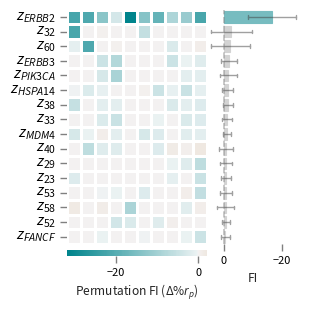

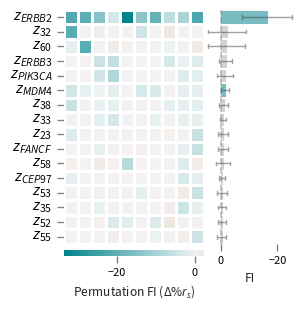

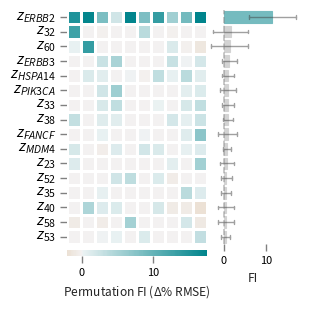

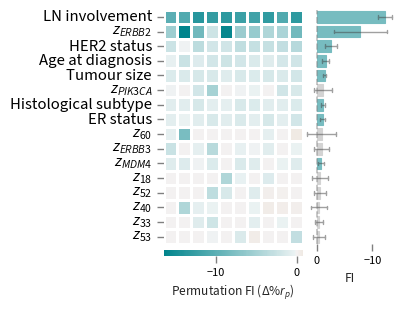

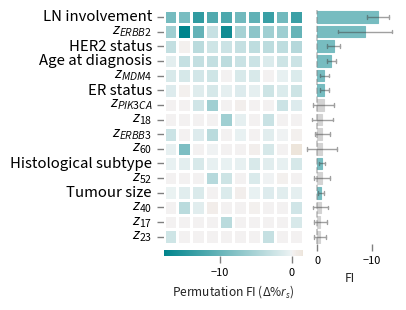

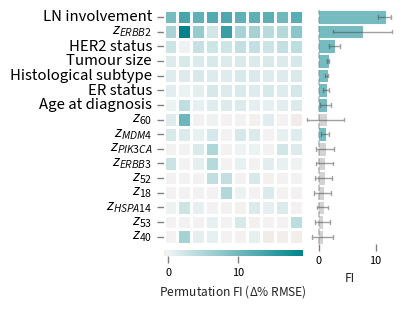

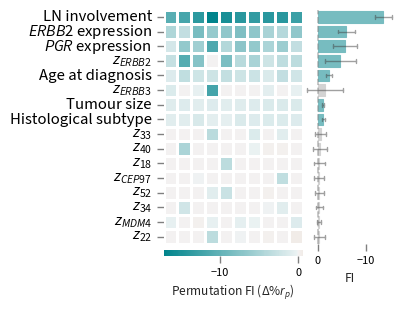

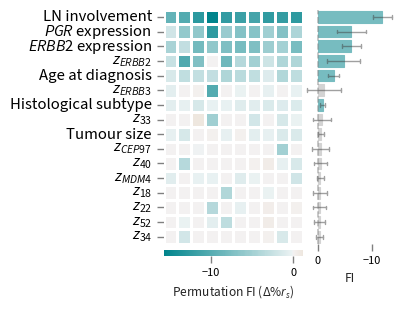

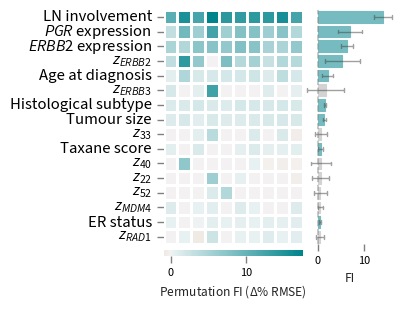

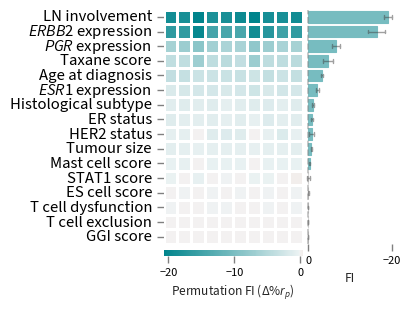

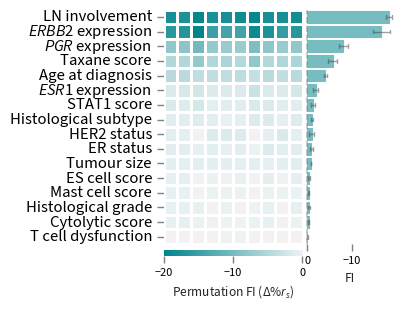

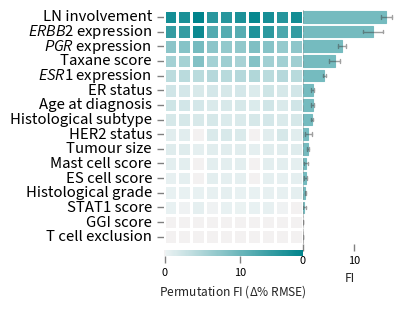

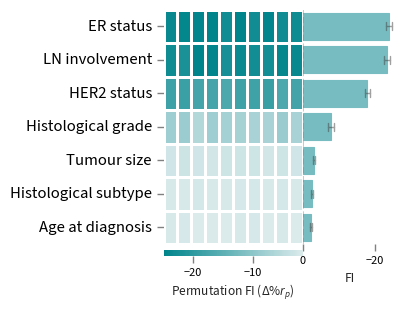

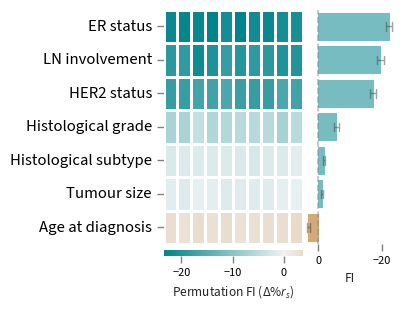

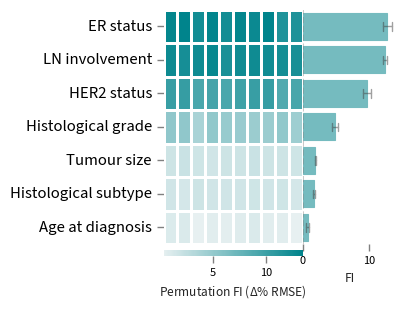

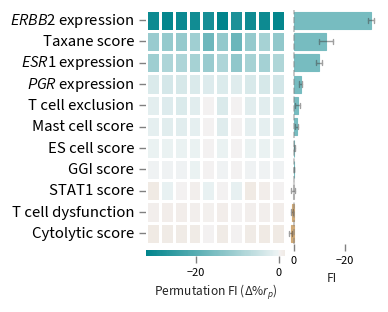

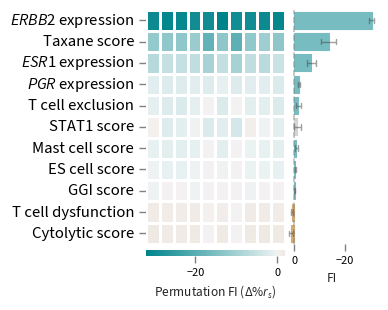

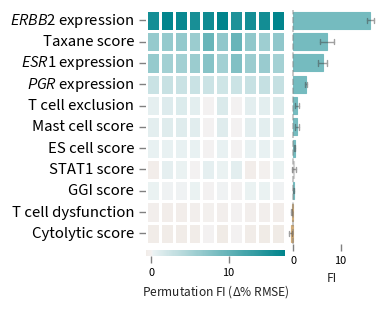

In [4]:
# LOAD TEST SET RESULTS
from utils.comp_utils import calculate_feat_imps, plot_feat_imps_v2

res_root = f"{wd_path}/data/outputs/depmap_gdsc_transneo/{target}/{experiment}/pico"
seeds = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

test_metrics_df = None
hopt_df = None


for feat_set, ext in feat_sets.items():
    for rep_type, rep_type_label in rep_types.items():
        for model_type in model_types:
            if rep_type_label == "PiCo":
                try:
                    pred_dict_list, constraints, confounders, feat_imps_df = (
                        calculate_feat_imps(
                            enc=rep_type,
                            reg=model_type,
                            model_path=f"{res_root}/{model_type}_{rep_type + ext}",
                            target=target,
                            seeds=seeds,
                        )
                    )
                    if feat_set in ["Clinical", "Clinical+RNA", "RNA"]:
                        zdim = 0
                        norep = True
                    else:
                        zdim = 64
                        norep = False

                    if target == "RCB.score":
                        plot_feat_imps_v2(
                            feat_imps_df,
                            target=target,
                            constraints=constraints,
                            confounders=feat_sets_conf[feat_set],
                            zdim=zdim,
                            enc=rep_type,
                            reg=model_type,
                            experiment=experiment,
                            names_map=names_map,
                            save_path=f"{model_type}_{target}_r_{rep_type + ext}",
                            metric="r",
                            norep=norep,
                            sort_feats=True,
                            top_k=16,
                        )
                        plot_feat_imps_v2(
                            feat_imps_df,
                            target=target,
                            constraints=constraints,
                            confounders=feat_sets_conf[feat_set],
                            zdim=zdim,
                            enc=rep_type,
                            reg=model_type,
                            experiment=experiment,
                            names_map=names_map,
                            save_path=f"{model_type}_{target}_s_{rep_type + ext}",
                            metric="s",
                            norep=norep,
                            sort_feats=True,
                            top_k=16,
                        )
                        plot_feat_imps_v2(
                            feat_imps_df,
                            target=target,
                            constraints=constraints,
                            confounders=feat_sets_conf[feat_set],
                            zdim=zdim,
                            enc=rep_type,
                            reg=model_type,
                            experiment=experiment,
                            names_map=names_map,
                            save_path=f"{model_type}_{target}_rmse_{rep_type + ext}",
                            metric="rmse",
                            norep=norep,
                            sort_feats=True,
                            top_k=16,
                        )
                    else:
                        plot_feat_imps_v2(
                            feat_imps_df,
                            target=target,
                            constraints=constraints,
                            confounders=feat_sets_conf[feat_set],
                            zdim=zdim,
                            enc=rep_type,
                            reg=model_type,
                            experiment=experiment,
                            names_map=names_map,
                            save_path=f"{model_type}_{target}_auroc_{rep_type + ext}",
                            metric="auroc",
                            norep=norep,
                            sort_feats=True,
                            top_k=16,
                        )
                except:
                    print(
                        f"Cannot produce feat imp plot for {model_type}, {rep_type}, {ext}..."
                    )
            for seed in seeds:
                try:
                    best_trial = pd.read_csv(
                        f"{res_root}/{model_type}_{rep_type + ext}/opt_study_results_s{seed}.csv"
                    ).sort_values("value", ascending=False)["number"][0]
                    curr_hopt_df = pd.read_csv(
                        f"{res_root}/{model_type}_{rep_type + ext}/cv_results_{best_trial}_s{seed}.csv"
                    )

                    curr_test_metrics_df = pd.read_csv(
                        f"{res_root}/{model_type}_{rep_type + ext}/test_metrics_s{seed}.csv"
                    )
                    curr_test_metrics_df["rep_type"] = rep_type_label
                    curr_test_metrics_df["model_type"] = model_type
                    curr_hopt_df["rep_type"] = rep_type_label
                    curr_hopt_df["model_type"] = model_type
                    # Placeholder until we add clinical features etc
                    curr_test_metrics_df["feat_sets"] = feat_set
                    curr_hopt_df["feat_sets"] = feat_set
                    curr_hopt_df["seed"] = seed
                    curr_test_metrics_df["seed"] = seed
                    if test_metrics_df is None:
                        test_metrics_df = curr_test_metrics_df
                    else:
                        test_metrics_df = pd.concat(
                            [test_metrics_df, curr_test_metrics_df], axis=0
                        )
                    if hopt_df is None:
                        hopt_df = curr_hopt_df
                    else:
                        hopt_df = pd.concat([hopt_df, curr_hopt_df], axis=0)
                except:
                    print(f"{model_type}, {rep_type}, {ext}, {seed} not found")
                    continue


test_metrics_df["dataset"] = "test"
hopt_df["dataset"] = "cv"

# Mean over folds for hopt
hopt_df = (
    hopt_df.groupby(["rep_type", "model_type", "feat_sets", "dataset", "seed"])
    .mean()
    .reset_index()
)

# Print results on external validation for reporting
test_metrics_df.groupby(
    ["rep_type", "model_type", "feat_sets", "dataset"]
).mean().reset_index()

In [6]:
# Load CV results
hopt_df.groupby(["rep_type", "model_type", "feat_sets"]).mean()

seed  Unnamed: 0  fold  val_rmse  \
rep_type model_type feat_sets                                            
PiCo     ElasticNet Clinical          55.0         2.0   2.0  1.077583   
                    Clinical+RNA      55.0         2.0   2.0  0.994045   
                    Clinical+Rep      55.0         2.0   2.0  1.010057   
                    Clinical+Rep+RNA  55.0         2.0   2.0  0.987731   
                    RNA               55.0         2.0   2.0  1.066728   
                    Rep               55.0         2.0   2.0  1.084802   
VAE      ElasticNet Clinical          55.0         2.0   2.0  1.077583   
                    Clinical+RNA      55.0         2.0   2.0  0.994045   
                    Clinical+Rep      55.0         2.0   2.0  1.027469   
                    Clinical+Rep+RNA  55.0         2.0   2.0  0.996328   
                    RNA               55.0         2.0   2.0  1.066728   
                    Rep               55.0         2.0   2.0  1.121073   

                                      val_pearsonr  val_spearmanr  
rep_type model_type feat_sets                                      
PiCo     ElasticNet Clinical              0.613332       0.603957  
                    Clinical+RNA          0.686112       0.668271  
                    Clinical+Rep          0.669767       0.656394  
                    Clinical+Rep+RNA      0.686767       0.667680  
                    RNA                   0.620653       0.620056  
                    Rep                   0.601009       0.593460  
VAE      ElasticNet Clinical              0.613332       0.603957  
                    Clinical+RNA          0.686112       0.668271  
                    Clinical+Rep          0.657996       0.642160  
                    Clinical+Rep+RNA      0.685101       0.665478  
                    RNA                   0.620653       0.620056  
                    Rep                   0.563581       0.553609

/tmp/ipykernel_3628994/283349754.py:158: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(names_dict.values())
/tmp/ipykernel_3628994/283349754.py:220: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.savefig(
/tmp/ipykernel_3628994/283349754.py:220: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.savefig(
/tmp/ipykernel_3628994/283349754.py:220: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.savefig(


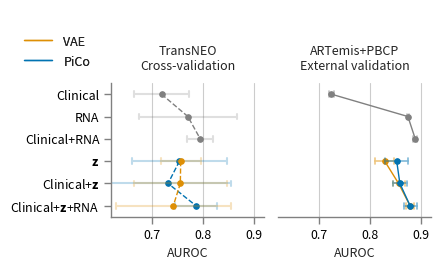

In [18]:
# COMBINED TRAIN AND EXT VAL PERFORMANCE -- DATASET FACET
# AUROC
from matplotlib.lines import Line2D

metric = "auroc"

metric_hopt = f"val_{metric}"
metric = f"test_{metric}"

target = "resp.pCR"

palette = sns.color_palette("colorblind")
# palette = {"PiCo_D": pal[1], "VAE": pal[0],}
pal_0_desat = sns.set_hls_values(palette[0], l=0.6, s=0.5)
pal_1_desat = sns.set_hls_values(palette[1], l=0.6, s=0.5)
pal_cv = {
    "VAE": palette[1],
    "PiCo": palette[0],
    "NA": "grey",
}
pal_ev = {
    "VAE": palette[1],
    "PiCo": palette[0],
    "NA": "grey",
}

plot_order = [
    "Clinical",
    "RNA",
    "Clinical+RNA",
    "Rep",
    "Clinical+Rep",
    "Clinical+Rep+RNA",
]

facet_order = ["TransNEO\nCross-validation", "ARTemis+PBCP\nExternal validation"]

hopt_df_plot = hopt_df.copy()

hopt_df_plot["rep_type_hue"] = hopt_df_plot["rep_type"].copy()
hopt_df_plot.loc[
    hopt_df_plot["feat_sets"].isin(["Clinical+RNA", "Clinical", "RNA"]),
    "rep_type_hue",
] = "NA"

fig, ax = plt.subplots(1, 2, figsize=(4.5, 2.5))

## PLOTS CV RESULTS
if target == "RCB.score":
    g1 = sns.pointplot(
        data=hopt_df_plot,
        y="feat_sets",
        x=metric_hopt,
        hue="rep_type_hue",
        order=plot_order,
        palette=pal_cv,
        linestyle="--",
        linewidth=1,
        markersize=4,
        errorbar=("sd", 1),
        capsize=0.25,
        marker="o",
        err_kws={"linewidth": 1.5, "alpha": 0.25},
        # legend=False,
        ax=ax[0],
    )
    # , errorbar=("ci", 95), capsize=0.1, err_kws={"linewidth": 1, "alpha": 0.5})
else:
    g1 = sns.pointplot(
        data=hopt_df_plot,
        y="feat_sets",
        x=metric_hopt,
        hue="rep_type_hue",
        order=plot_order,
        palette=pal_cv,
        linestyle="--",
        linewidth=1,
        markersize=4,
        errorbar=("sd", 1),
        capsize=0.25,
        marker="o",
        err_kws={"linewidth": 1.5, "alpha": 0.25},
        # legend=False,
        ax=ax[0],
    )  # , errorbar=("ci", 95), capsize=0.1, err_kws={"linewidth": 1, "alpha": 0.5})


## PLOTS EXT VAL RESULTS
metrics_df_plot = test_metrics_df.copy(deep=True)
metrics_df_plot["rep_type_hue"] = metrics_df_plot["rep_type"].copy()
metrics_df_plot.loc[
    metrics_df_plot["feat_sets"].isin(["Clinical+RNA", "Clinical", "RNA"]),
    "rep_type_hue",
] = "NA"

if target == "RCB.score":
    sns.pointplot(
        data=metrics_df_plot,
        y="feat_sets",
        x=metric,
        hue="rep_type_hue",
        order=plot_order,
        palette=pal_ev,
        linestyle="-",
        linewidth=1,
        markersize=4,
        marker="o",
        errorbar=("sd", 1),
        capsize=0.25,
        err_kws={"linewidth": 1.2, "alpha": 0.5},
        ax=ax[1],
        legend=False,
    )
else:
    sns.pointplot(
        data=metrics_df_plot,
        y="feat_sets",
        x=metric,
        hue="rep_type_hue",
        palette=pal_ev,
        order=plot_order,
        linestyle="-",
        linewidth=1,
        markersize=4,
        marker="o",
        errorbar=("sd", 1),
        capsize=0.25,
        err_kws={"linewidth": 1.2, "alpha": 0.5},
        ax=ax[1],
        legend=False,
    )

handles, labels = plt.gca().get_legend_handles_labels()

line_train = Line2D([0], [0], label="VAE", color=palette[1], linestyle="-", linewidth=1)
line_val = Line2D([0], [0], label="PiCo", color=palette[0], linestyle="-", linewidth=1)

leg1 = ax[0].legend(
    handles=handles[3:],
    bbox_to_anchor=(1.0, 1.6),
    loc="upper center",
    frameon=False,
    ncol=3,
    fontsize=10,
)

leg2 = ax[0].legend(
    handles=[line_train, line_val],
    bbox_to_anchor=(-0.35, 1.45),
    loc="upper center",
    frameon=False,
    ncol=1,
    fontsize=10,
)

ax[0].add_artist(leg1)
ax[0].add_artist(leg2)

# Rename y ticks
names_dict = {
    "Clinical": "Clinical",
    "RNA": r"RNA",
    "Clinical+RNA": "Clinical+RNA",
    "Rep": r"$\mathbf{z}$",
    "Clinical+Rep": r"Clinical+$\mathbf{z}$",
    "Clinical+Rep+RNA": r"Clinical+$\mathbf{z}$+RNA",
}
# ax.set_yticks(names_dict.keys())
ax[0].set_yticklabels(names_dict.values())

# sns.move_legend(ax, "upper center", bbox_to_anchor=(.5, -.2), ncol=1, title=None, frameon=False)
sns.despine()
for i, ax in enumerate(ax):
    ax.set_ylabel("")
    if target == "RCB.score":
        if metric == "test_spearmanr":
            ax.set_xlabel("Spearman\ncorrelation", fontsize=10)
            ax.set_xlim(0.5, 0.82)
            ax.set_xticks([0.5, 0.6, 0.7, 0.8], [0.5, 0.6, 0.7, 0.8])
        elif metric == "test_pearsonr":
            ax.set_xlabel("Pearson\ncorrelation", fontsize=10)
            ax.set_xlim(0.5, 0.82)
            ax.set_xticks([0.5, 0.6, 0.7, 0.8], [0.5, 0.6, 0.7, 0.8])
        elif metric == "test_rmse":
            ax.set_xlabel("RMSE", fontsize=10)
            ax.set_xlim(0.85, 1.15)
            ax.set_xticks([0.9, 1.0, 1.1], [0.9, 1.0, 1.1])
    else:
        if metric == "test_auroc":
            ax.set_xlabel("AUROC", fontsize=10)
            ax.set_xlim(0.62, 0.92)
            ax.set_xticks([0.7, 0.8, 0.9], [0.7, 0.8, 0.9])
        elif metric == "test_aupr":
            ax.set_xlabel("AUPR", fontsize=10)
            ax.set_xlim(0.35, 0.75)
            ax.set_xticks([0.4, 0.5, 0.6, 0.7], [0.4, 0.5, 0.6, 0.7])
        elif metric == "test_f1":
            ax.set_xlabel("F1 score", fontsize=10)
            ax.set_xlim(0.35, 0.75)
            ax.set_xticks([0.4, 0.5, 0.6, 0.7], [0.4, 0.5, 0.6, 0.7])
        elif metric == "test_cross_entropy":
            ax.set_xlabel("Cross-entropy", fontsize=10)
            ax.set_xlim(0.3, 0.6)
            ax.set_xticks([0.3, 0.4, 0.5, 0.6], [0.3, 0.4, 0.5, 0.6])
    ax.set_title("")
    ax.text(
        s=facet_order[i],
        x=0.5,
        y=1.1,
        transform=ax.transAxes,
        fontweight="regular",
        horizontalalignment="center",
        fontsize=10,
    )
    ax.grid(visible=True, axis="x")
    ax.tick_params(labelsize=10)
    if i > 0:
        sns.despine(left=True, ax=ax)
        ax.tick_params(
            top=False,
            bottom=True,
            left=False,
            right=False,
            labelleft=False,
            labelbottom=True,
            labelsize=10,
        )

fig.tight_layout()

plt.savefig(
    f"./figures/transneo/perf_facet_{target}_{metric}.png",
    # bbox_extra_artists=(leg1, leg2),
    bbox_inches="tight",
    dpi=600,
)
plt.savefig(
    f"./figures/transneo/perf_facet_{target}_{metric}.svg",
    # bbox_extra_artists=(leg1, leg2),
    bbox_inches="tight",
)

In [16]:
# CV RESULTS REPORTING FOR PAPER
hopt_df.groupby(["feat_sets", "rep_type"]).mean().sort_values(
    by=metric_hopt, ascending=False
)

seed  Unnamed: 0  fold  val_cross_entropy  \
feat_sets        rep_type                                                   
Rep              VAE       55.000000         2.0   2.0           0.686332   
Clinical         PiCo      55.000000         2.0   2.0           0.619672   
                 VAE       55.000000         2.0   2.0           0.612918   
Clinical+Rep     VAE       55.000000         2.0   2.0           0.581615   
Rep              PiCo      55.000000         2.0   2.0           0.577044   
RNA              PiCo      55.000000         2.0   2.0           0.576313   
Clinical+Rep     PiCo      55.000000         2.0   2.0           0.575415   
Clinical+RNA     VAE       55.000000         2.0   2.0           0.568652   
                 PiCo      55.000000         2.0   2.0           0.561366   
Clinical+Rep+RNA VAE       55.000000         2.0   2.0           0.561069   
RNA              VAE       54.444444         2.0   2.0           0.559496   
Clinical+Rep+RNA PiCo      55.000000         2.0   2.0           0.543549   

                             val_f1  val_aupr  val_auroc  
feat_sets        rep_type                                 
Rep              VAE       0.529977  0.502837   0.756899  
Clinical         PiCo      0.489424  0.501627   0.708578  
                 VAE       0.496701  0.481245   0.730122  
Clinical+Rep     VAE       0.545021  0.525702   0.756185  
Rep              PiCo      0.538652  0.523443   0.754434  
RNA              PiCo      0.538869  0.554230   0.744103  
Clinical+Rep     PiCo      0.520147  0.533370   0.732107  
Clinical+RNA     VAE       0.561890  0.534154   0.792489  
                 PiCo      0.568121  0.541818   0.797843  
Clinical+Rep+RNA VAE       0.525624  0.510404   0.742399  
RNA              VAE       0.595364  0.530415   0.800800  
Clinical+Rep+RNA PiCo      0.591208  0.517290   0.786984

In [17]:
# EV RESULTS REPORTING FOR PAPER
metrics_df_plot.groupby(["feat_sets", "rep_type"]).mean().sort_values(
    by=metric, ascending=metric == "rmse"
)

Unnamed: 0  test_cross_entropy   test_f1  \
feat_sets        rep_type                                             
Clinical         PiCo             0.0            0.549528  0.471067   
                 VAE              0.0            0.549528  0.471067   
Rep              VAE              0.0            0.511977  0.606624   
                 PiCo             0.0            0.460985  0.653103   
Clinical+Rep     VAE              0.0            0.459440  0.619747   
                 PiCo             0.0            0.444216  0.641358   
Clinical+Rep+RNA VAE              0.0            0.432705  0.716913   
RNA              VAE              0.0            0.430940  0.727926   
                 PiCo             0.0            0.430795  0.724901   
Clinical+Rep+RNA PiCo             0.0            0.428263  0.662121   
Clinical+RNA     VAE              0.0            0.416135  0.663333   
                 PiCo             0.0            0.415446  0.658333   

                           test_aupr  test_auroc       seed  
feat_sets        rep_type                                    
Clinical         PiCo       0.564801    0.724436  55.000000  
                 VAE        0.564801    0.724436  55.000000  
Rep              VAE        0.607777    0.828853  55.000000  
                 PiCo       0.568050    0.852350  55.000000  
Clinical+Rep     VAE        0.676918    0.856015  55.000000  
                 PiCo       0.607956    0.858553  55.000000  
Clinical+Rep+RNA VAE        0.667565    0.878571  55.000000  
RNA              VAE        0.615623    0.874269  54.444444  
                 PiCo       0.614415    0.874342  55.000000  
Clinical+Rep+RNA PiCo       0.638763    0.878665  55.000000  
Clinical+RNA     VAE        0.696370    0.888628  55.000000  
                 PiCo       0.696571    0.888816  55.000000

### 4.1.3 RCB score prediction as pCR prediction

In [18]:
# LOAD TEST SET RESULTS
from utils.comp_utils import calculate_feat_imps, plot_feat_imps_v2
from scipy.stats import spearmanr
from sklearn.metrics import roc_auc_score

res_root = f"{wd_path}/data/outputs/depmap_gdsc_transneo/{target}/{experiment}/pico"
seeds = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

test_metrics_list = []
hopt_df = None

for feat_set, ext in feat_sets.items():
    for rep_type, rep_type_label in rep_types.items():
        for model_type in model_types:
            # if rep_type_label == "PiCo":
            #     try:
            #         pred_dict_list, constraints, confounders, feat_imps_df = calculate_feat_imps(enc=rep_type, reg=model_type, model_path=f"{res_root}/{model_type}_{rep_type + ext}", target=target, seeds=seeds)
            #         if feat_set in ["Clinical", "Clinical+RNA", "RNA"]:
            #             zdim = 0
            #             norep = True
            #         else:
            #             zdim = 64
            #             norep = False

            #         if target == "RCB.score":
            #             plot_feat_imps_v2(feat_imps_df, target=target, constraints=constraints, confounders=feat_sets_conf[feat_set], zdim=zdim, enc=rep_type, reg=model_type, experiment=experiment, names_map=names_map, save_path=f"{model_type}_{target}_r_{rep_type+ext}", metric="r", norep=norep, sort_feats=True, top_k=16)
            #             plot_feat_imps_v2(feat_imps_df, target=target, constraints=constraints, confounders=feat_sets_conf[feat_set], zdim=zdim, enc=rep_type, reg=model_type, experiment=experiment, names_map=names_map, save_path=f"{model_type}_{target}_s_{rep_type+ext}", metric="s", norep=norep, sort_feats=True, top_k=16)
            #             plot_feat_imps_v2(feat_imps_df, target=target, constraints=constraints, confounders=feat_sets_conf[feat_set], zdim=zdim, enc=rep_type, reg=model_type, experiment=experiment, names_map=names_map, save_path=f"{model_type}_{target}_rmse_{rep_type+ext}", metric="rmse", norep=norep, sort_feats=True, top_k=16)
            #         else:
            #             plot_feat_imps_v2(feat_imps_df, target=target, constraints=constraints, confounders=feat_sets_conf[feat_set], zdim=zdim, enc=rep_type, reg=model_type, experiment=experiment, names_map=names_map, save_path=f"{model_type}_{target}_auroc_{rep_type+ext}", metric="auroc", norep=norep, sort_feats=True, top_k=16)
            #     except:
            #         print(f"Cannot produce feat imp plot for {model_type}, {rep_type}, {ext}...")
            for seed in seeds:
                # try:
                # best_trial = pd.read_csv(f"{res_root}/{model_type}_{rep_type + ext}/opt_study_results_s{seed}.csv").sort_values("value", ascending=False)["number"][0]
                # curr_hopt_df = pd.read_csv(f"{res_root}/{model_type}_{rep_type + ext}/cv_results_{best_trial}_s{seed}.csv")

                curr_preds = pd.read_csv(
                    f"{res_root}/{model_type}_{rep_type + ext}/z_pred_test_s{seed}.csv"
                )

                pred_metrics = curr_preds[["pred_0", "y"]].dropna()
                pred_metrics_auroc = pred_metrics.copy()
                pred_metrics_auroc["y"] = (pred_metrics_auroc["y"] == 0.0).astype(float)
                auc = roc_auc_score(
                    pred_metrics_auroc["y"], pred_metrics_auroc["pred_0"]
                )
                auc_neg = roc_auc_score(
                    pred_metrics_auroc["y"], -1 * pred_metrics_auroc["pred_0"]
                )
                auc = np.max([auc, auc_neg])
                test_metrics_list.append(
                    {
                        "n": len(pred_metrics),
                        "rep_type": rep_type,
                        "model_type": model_type,
                        "feat_sets": feat_set,
                        "seed": seed,
                        "spearman_r": spearmanr(
                            pred_metrics["pred_0"], pred_metrics["y"]
                        )[0],
                        "pearson_r": pearsonr(
                            pred_metrics["pred_0"], pred_metrics["y"]
                        )[0],
                        "rmse": (
                            np.sqrt(pred_metrics["pred_0"] - pred_metrics["y"]) ** 2
                        ).mean(),
                        "auroc": auc,
                    }
                )

                # except:
                #     print(f"{model_type}, {rep_type}, {ext}, {seed} not found")
                #     continue

test_metrics_df = pd.DataFrame.from_dict(test_metrics_list)
test_metrics_df["dataset"] = "test"

# Print results on external validation for reporting
test_metrics_df.groupby(
    ["rep_type", "model_type", "feat_sets", "dataset", "n"]
).mean().reset_index()

/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home

,rep_type,model_type,feat_sets,dataset,n,seed,spearman_r,pearson_r,rmse,auroc
0,icovae_MCL1_16,ElasticNet,Clinical,test,72,55.0,0.596168,0.640827,0.924892,0.721351
1,icovae_MCL1_16,ElasticNet,Clinical+RNA,test,72,55.0,0.776493,0.765467,0.891861,0.878649
2,icovae_MCL1_16,ElasticNet,Clinical+Rep,test,72,55.0,0.747486,0.743185,0.833797,0.883913
3,icovae_MCL1_16,ElasticNet,Clinical+Rep+RNA,test,72,55.0,0.762874,0.758556,0.826295,0.901192
4,icovae_MCL1_16,ElasticNet,RNA,test,72,55.0,0.666035,0.645173,1.037773,0.871897
5,icovae_MCL1_16,ElasticNet,Rep,test,72,55.0,0.668844,0.652795,0.891882,0.872592
6,vae,ElasticNet,Clinical,test,72,55.0,0.596168,0.640827,0.924892,0.721351
7,vae,ElasticNet,Clinical+RNA,test,72,55.0,0.776493,0.765467,0.891861,0.878649
8,vae,ElasticNet,Clinical+Rep,test,72,55.0,0.694255,0.703007,0.814216,0.846574
9,vae,ElasticNet,Clinical+Rep+RNA,test,72,55.0,0.736699,0.732637,0.842638,0.878451


In [1]:
# COMBINED TRAIN AND EXT VAL PERFORMANCE -- DATASET FACET
# AUROC
from matplotlib.lines import Line2D

metric = "auroc"

metric = f"{metric}"

target = "RCB.score"

palette = sns.color_palette("colorblind")
# palette = {"PiCo_D": pal[1], "VAE": pal[0],}
pal_0_desat = sns.set_hls_values(palette[0], l=0.6, s=0.5)
pal_1_desat = sns.set_hls_values(palette[1], l=0.6, s=0.5)
pal_ev = {
    "vae": palette[1],
    "icovae_MCL1_16": palette[0],
    "NA": "grey",
}

plot_order = [
    "Clinical",
    "RNA",
    "Clinical+RNA",
    "Rep",
    "Clinical+Rep",
    "Clinical+Rep+RNA",
]

facet_order = ["TransNEO\nCross-validation", "ARTemis+PBCP\nExternal validation"]

fig, ax = plt.subplots(1, 1, figsize=(3, 2))

## PLOTS EXT VAL RESULTS
metrics_df_plot = test_metrics_df.copy(deep=True)
metrics_df_plot["rep_type_hue"] = metrics_df_plot["rep_type"].copy()
metrics_df_plot.loc[
    metrics_df_plot["feat_sets"].isin(["Clinical+RNA", "Clinical", "RNA"]),
    "rep_type_hue",
] = "NA"

if target == "RCB.score":
    sns.pointplot(
        data=metrics_df_plot,
        y="feat_sets",
        x=metric,
        hue="rep_type_hue",
        order=plot_order,
        palette=pal_ev,
        linestyle="-",
        linewidth=1,
        markersize=4,
        marker="o",
        errorbar=("sd", 1),
        capsize=0.25,
        err_kws={"linewidth": 1.2, "alpha": 0.5},
        ax=ax,
        legend=False,
    )
else:
    sns.pointplot(
        data=metrics_df_plot,
        y="feat_sets",
        x=metric,
        hue="rep_type_hue",
        palette=pal_ev,
        order=plot_order,
        linestyle="-",
        linewidth=1,
        markersize=4,
        marker="o",
        errorbar=("sd", 1),
        capsize=0.25,
        err_kws={"linewidth": 1.2, "alpha": 0.5},
        ax=ax,
        legend=False,
    )

handles, labels = plt.gca().get_legend_handles_labels()

line_train = Line2D([0], [0], label="VAE", color=palette[1], linestyle="-", linewidth=1)
line_val = Line2D([0], [0], label="PiCo", color=palette[0], linestyle="-", linewidth=1)

leg1 = ax.legend(
    handles=handles[3:],
    bbox_to_anchor=(1.0, 1.25),
    loc="upper center",
    frameon=False,
    ncol=2,
    fontsize=10,
)

leg2 = ax.legend(
    handles=[line_train, line_val],
    bbox_to_anchor=(0.5, 1.25),
    loc="upper center",
    frameon=False,
    ncol=2,
    fontsize=10,
)

ax.add_artist(leg1)
ax.add_artist(leg2)

# Rename y ticks
names_dict = {
    "Clinical": "Clinical",
    "RNA": r"RNA",
    "Clinical+RNA": "Clinical+RNA",
    "Rep": r"$\mathbf{z}$",
    "Clinical+Rep": r"Clinical+$\mathbf{z}$",
    "Clinical+Rep+RNA": r"Clinical+$\mathbf{z}$+RNA",
}
# ax.set_yticks(names_dict.keys())
ax.set_yticklabels(names_dict.values())

# sns.move_legend(ax, "upper center", bbox_to_anchor=(.5, -.2), ncol=1, title=None, frameon=False)
sns.despine()
ax.set_ylabel("")
if target == "RCB.score":
    if metric == "test_spearmanr":
        ax.set_xlabel("Spearman\ncorrelation", fontsize=10)
        ax.set_xlim(0.5, 0.82)
        ax.set_xticks([0.5, 0.6, 0.7, 0.8], [0.5, 0.6, 0.7, 0.8])
    elif metric == "test_pearsonr":
        ax.set_xlabel("Pearson\ncorrelation", fontsize=10)
        ax.set_xlim(0.5, 0.82)
        ax.set_xticks([0.5, 0.6, 0.7, 0.8], [0.5, 0.6, 0.7, 0.8])
    elif metric == "test_rmse":
        ax.set_xlabel("RMSE", fontsize=10)
        ax.set_xlim(0.85, 1.15)
        ax.set_xticks([0.9, 1.0, 1.1], [0.9, 1.0, 1.1])
    elif metric == "auroc":
        ax.set_xlabel("AUROC", fontsize=10)
        ax.set_xlim(0.62, 0.92)
        ax.set_xticks([0.7, 0.8, 0.9], [0.7, 0.8, 0.9])
else:
    if metric == "auroc":
        ax.set_xlabel("AUROC", fontsize=10)
        ax.set_xlim(0.62, 0.95)
        ax.set_xticks([0.7, 0.8, 0.9], [0.7, 0.8, 0.9])
    elif metric == "test_aupr":
        ax.set_xlabel("AUPR", fontsize=10)
        ax.set_xlim(0.35, 0.75)
        ax.set_xticks([0.4, 0.5, 0.6, 0.7], [0.4, 0.5, 0.6, 0.7])
    elif metric == "test_f1":
        ax.set_xlabel("F1 score", fontsize=10)
        ax.set_xlim(0.35, 0.75)
        ax.set_xticks([0.4, 0.5, 0.6, 0.7], [0.4, 0.5, 0.6, 0.7])
    elif metric == "test_cross_entropy":
        ax.set_xlabel("Cross-entropy", fontsize=10)
        ax.set_xlim(0.3, 0.6)
        ax.set_xticks([0.3, 0.4, 0.5, 0.6], [0.3, 0.4, 0.5, 0.6])
ax.set_title("")
# ax.text(
#     s=facet_order[i],
#     x=0.5,
#     y=1.1,
#     transform=ax.transAxes,
#     fontweight="regular",
#     horizontalalignment="center",
#     fontsize=10,
# )
ax.grid(visible=True, axis="x")
ax.tick_params(labelsize=10)

fig.tight_layout()

plt.savefig(
    f"./figures/transneo/perf_facet_{target}_{metric}.png",
    # bbox_extra_artists=(leg1, leg2),
    bbox_inches="tight",
    dpi=600,
)
plt.savefig(
    f"./figures/transneo/perf_facet_{target}_{metric}.svg",
    # bbox_extra_artists=(leg1, leg2),
    bbox_inches="tight",
)

NameError: name 'sns' is not defined

### 4.1.3 Performance by subtype

In [8]:
# LOAD TEST SET RESULTS
from utils.comp_utils import calculate_feat_imps, plot_feat_imps_v2
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import roc_auc_score

res_root = f"{wd_path}/data/outputs/depmap_gdsc_transneo/{target}/{experiment}/pico"
seeds = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

feat_sets_subtype = {
    "Clinical+Rep": "_Size.at.diagnosis_7",
    "Clinical+Rep+RNA": "_Size.at.diagnosis_18",
    "Clinical+RNA": "_Size.at.diagnosis_18_norep",
    "Clinical": "_Size.at.diagnosis_7_norep",
}

test_metrics_list = []
hopt_df = None

for feat_set, ext in feat_sets_subtype.items():
    for rep_type, rep_type_label in rep_types.items():
        for model_type in model_types:
            # if rep_type_label == "PiCo":
            #     try:
            #         pred_dict_list, constraints, confounders, feat_imps_df = calculate_feat_imps(enc=rep_type, reg=model_type, model_path=f"{res_root}/{model_type}_{rep_type + ext}", target=target, seeds=seeds)
            #         if feat_set in ["Clinical", "Clinical+RNA", "RNA"]:
            #             zdim = 0
            #             norep = True
            #         else:
            #             zdim = 64
            #             norep = False

            #         if target == "RCB.score":
            #             plot_feat_imps_v2(feat_imps_df, target=target, constraints=constraints, confounders=feat_sets_conf[feat_set], zdim=zdim, enc=rep_type, reg=model_type, experiment=experiment, names_map=names_map, save_path=f"{model_type}_{target}_r_{rep_type+ext}", metric="r", norep=norep, sort_feats=True, top_k=16)
            #             plot_feat_imps_v2(feat_imps_df, target=target, constraints=constraints, confounders=feat_sets_conf[feat_set], zdim=zdim, enc=rep_type, reg=model_type, experiment=experiment, names_map=names_map, save_path=f"{model_type}_{target}_s_{rep_type+ext}", metric="s", norep=norep, sort_feats=True, top_k=16)
            #             plot_feat_imps_v2(feat_imps_df, target=target, constraints=constraints, confounders=feat_sets_conf[feat_set], zdim=zdim, enc=rep_type, reg=model_type, experiment=experiment, names_map=names_map, save_path=f"{model_type}_{target}_rmse_{rep_type+ext}", metric="rmse", norep=norep, sort_feats=True, top_k=16)
            #         else:
            #             plot_feat_imps_v2(feat_imps_df, target=target, constraints=constraints, confounders=feat_sets_conf[feat_set], zdim=zdim, enc=rep_type, reg=model_type, experiment=experiment, names_map=names_map, save_path=f"{model_type}_{target}_auroc_{rep_type+ext}", metric="auroc", norep=norep, sort_feats=True, top_k=16)
            #     except:
            #         print(f"Cannot produce feat imp plot for {model_type}, {rep_type}, {ext}...")
            for seed in seeds:
                # try:
                # best_trial = pd.read_csv(f"{res_root}/{model_type}_{rep_type + ext}/opt_study_results_s{seed}.csv").sort_values("value", ascending=False)["number"][0]
                # curr_hopt_df = pd.read_csv(f"{res_root}/{model_type}_{rep_type + ext}/cv_results_{best_trial}_s{seed}.csv")

                curr_preds = pd.read_csv(
                    f"{res_root}/{model_type}_{rep_type + ext}/z_pred_test_s{seed}.csv"
                )

                curr_preds_00 = curr_preds[
                    (curr_preds["c_4"] < 0) & (curr_preds["c_5"] < 0)
                ]
                curr_preds_10 = curr_preds[
                    (curr_preds["c_4"] > 0) & (curr_preds["c_5"] < 0)
                ]
                curr_preds_01 = curr_preds[
                    (curr_preds["c_4"] < 0) & (curr_preds["c_5"] > 0)
                ]
                curr_preds_11 = curr_preds[
                    (curr_preds["c_4"] > 0) & (curr_preds["c_5"] > 0)
                ]

                subtype_preds = {
                    "ER-/HER2-": curr_preds_00,
                    "ER+/HER2-": curr_preds_10,
                    "ER-/HER2+": curr_preds_01,
                    "ER+/HER2+": curr_preds_11,
                }

                for subtype, preds in subtype_preds.items():
                    print(subtype)
                    print(preds)
                    pred_metrics = preds[["pred_0", "y"]].dropna()
                    pred_metrics_auroc = pred_metrics.copy()
                    pred_metrics_auroc["y"] = (pred_metrics_auroc["y"] == 0.0).astype(
                        float
                    )
                    auc = roc_auc_score(
                        pred_metrics_auroc["y"], pred_metrics_auroc["pred_0"]
                    )
                    auc_neg = roc_auc_score(
                        pred_metrics_auroc["y"], -1 * pred_metrics_auroc["pred_0"]
                    )
                    auc = np.max([auc, auc_neg])
                    test_metrics_list.append(
                        {
                            "subtype": subtype,
                            "n": len(pred_metrics),
                            "rep_type": rep_type,
                            "model_type": model_type,
                            "feat_sets": feat_set,
                            "seed": seed,
                            "spearman_r": spearmanr(
                                pred_metrics["pred_0"], pred_metrics["y"]
                            )[0],
                            "pearson_r": pearsonr(
                                pred_metrics["pred_0"], pred_metrics["y"]
                            )[0],
                            "rmse": (
                                np.sqrt(pred_metrics["pred_0"] - pred_metrics["y"]) ** 2
                            ).mean(),
                            "auroc": auc,
                        }
                    )

                # except:
                #     print(f"{model_type}, {rep_type}, {ext}, {seed} not found")
                #     continue

test_metrics_df = pd.DataFrame.from_dict(test_metrics_list)
test_metrics_df["dataset"] = "test"

# Print results on external validation for reporting
test_metrics_df.groupby(
    ["rep_type", "model_type", "feat_sets", "dataset", "subtype", "n"]
).mean().reset_index()

ER-/HER2-
    Unnamed: 0   ind       z_0       z_1       z_2       z_3       z_4  \
17          17  1658 -1.871395  1.816455 -1.461664 -1.116607 -1.578123   
28          28  1616  2.244680  2.591534  0.292124 -0.676240 -4.200705   
39          39  1642  0.805679  1.059294  1.815519  0.075112 -2.437575   
48          48  1682  0.073166  0.770772 -0.380636  0.566472 -2.554028   
53          53  1644  1.437560  2.838239  0.117161 -1.082897 -0.189444   
56          56  1630  1.053938  1.558708  0.751618  0.124458 -1.388975   
59          59  1627 -0.172241  3.244107  1.549414  0.494265 -0.376025   
67          67  1632  1.138213  2.801595  0.097844 -0.426926 -0.980800   
74          74  1681  0.119465  1.457098 -1.044125 -0.370994 -0.650798   

         z_5       z_6       z_7  ...      z_31       c_0       c_1       c_2  \
17 -0.528621 -0.101279 -0.404361  ...  0.680728 -0.908385 -1.048809  0.002524   
28 -0.540741  3.243054 -1.824393  ...  2.667896 -0.108561  0.953463  0.280758   
39  0.

/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home

ER-/HER2+
    Unnamed: 0   ind       z_0       z_1       z_2       z_3       z_4  \
13          13  1643  1.417899 -1.036323  1.145724  1.691273 -1.337838   
23          23  1637  1.080045 -0.429139  0.281636  2.060439 -1.111562   
36          36  1619 -0.472605 -1.276063  1.124204  1.970926 -1.510097   
50          50  1622  0.148629 -0.687967  1.812308  0.742258 -0.060680   
56          56  1645 -0.492563 -2.881478  0.707276  0.658251 -0.644842   
60          60  1634 -1.386454 -0.745480  0.550686  0.924863 -2.250443   
64          64  1618  0.376705 -1.136686  1.440880  1.674555 -0.357247   

         z_5       z_6       z_7  ...      z_31       c_0       c_1       c_2  \
13 -1.245447 -0.736137  2.571293  ...  1.610108 -1.060732  0.953463  0.002524   
23  1.082241  0.661834 -0.289485  ...  0.665550  1.948130  0.953463  1.022715   
36 -0.269234 -0.464095  1.144666  ...  1.368451 -1.060732  0.953463  0.837226   
50 -1.279638 -1.417041  0.763617  ...  1.420789 -0.832211 -1.048809  0.46

/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home

ER-/HER2+
    Unnamed: 0   ind       z_0       z_1       z_2       z_3       z_4  \
13          13  1637  2.515773  1.967480  1.336122 -0.153164 -0.549252   
21          21  1618 -0.905288  2.963227  1.222465  0.276081  0.398285   
23          23  1619 -1.238391  1.280942  1.069197  0.615933  0.079855   
27          27  1643  0.427036  0.797547 -0.171848  0.985007 -1.401171   
36          36  1645  1.925907  1.999422  1.406400  0.214680 -0.254262   
62          62  1634 -0.602113  1.919997  0.803017  1.743977  1.648258   
64          64  1622 -0.156166  1.659604  1.162793 -0.220401  0.858870   

         z_5       z_6       z_7  ...      z_31       c_0       c_1       c_2  \
13 -0.791705  0.403985 -0.676905  ...  2.968535  1.948130  0.953463  1.022715   
21 -1.764224 -1.069315 -0.997008  ...  1.153054 -0.565603  0.953463  0.837226   
23 -1.594578 -0.989753 -0.029353  ...  0.515084 -1.060732  0.953463  0.837226   
27 -0.944585  0.597598 -1.346453  ...  2.232014 -1.060732  0.953463  0.00

/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home

ER+/HER2+
    Unnamed: 0   ind       z_0       z_1       z_2       z_3       z_4  \
6            6  1648 -1.329395  1.003885  0.445177 -0.307560 -1.124524   
19          19  1639 -1.257969 -1.481015 -0.104160  0.483757 -1.523001   
20          20  1629  0.256816 -1.699043  0.123809  0.657953 -0.788664   
44          44  1647 -0.175437  0.427709  0.089774  0.486367  0.253200   
45          45  1625 -1.042822 -0.499367  0.456582  0.383969 -2.405863   
52          52  1617 -0.579906 -0.472403 -1.257112  0.457276 -0.970751   
58          58  1620 -0.569516 -0.406963  0.090433  0.423954 -0.150213   
69          69  1636 -0.500379  0.606439  0.242385 -0.344863 -1.049135   
70          70  1640 -0.596603 -1.221399 -0.645274 -0.108342 -2.026484   
72          72  1628 -1.601750 -1.062823  0.726788  0.581581 -1.278852   
73          73  1635 -0.535612 -0.072172 -0.674155 -0.136627 -0.876091   

         z_5       z_6       z_7  ...      z_63       c_0       c_1       c_2  \
6   0.525828  1.3981

/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home

ER+/HER2-
    Unnamed: 0   ind       z_0       z_1       z_2       z_3       z_4  \
0            0  1654  0.775260 -0.764472  0.300925  0.411941  0.302535   
2            2  1612 -2.646799  1.522980  0.481600  1.806586 -1.370910   
4            4  1641 -0.735387  1.646561 -0.469682  0.539445  0.739909   
6            6  1675  0.821022 -0.672631  0.206804  0.722492  0.524405   
7            7  1631  1.044973  2.191846 -1.299614  0.463687  0.589077   
8            8  1676  0.394897 -0.269083  1.152447  1.299530 -0.901238   
10          10  1685 -0.843656 -0.411240  0.896326  1.104890 -2.065056   
11          11  1651  0.108342  0.835483 -1.049508 -1.572306  1.853074   
12          12  1671  0.404036 -0.564949  1.300192  2.106241 -1.389553   
14          14  1655  0.085575 -0.405076  1.747044  0.636780 -1.386301   
16          16  1677  0.279246 -0.529025  0.144593  0.806177 -1.196111   
17          17  1666  0.907166  0.018928  0.347524 -0.483132  0.165412   
18          18  1667  0.0376

/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home

ER-/HER2+
    Unnamed: 0   ind       z_0       z_1       z_2       z_3       z_4  \
1            1  1619 -0.710170  2.270656  1.545046 -0.842598  0.078406   
3            3  1618 -0.374917  1.784811  1.905081 -1.041230  0.486795   
13          13  1637  1.224247  0.685544 -0.083920 -0.814431  0.827598   
15          15  1645  0.551698  2.118312  0.553685 -2.012319  0.382211   
21          21  1643 -0.971585  0.601545  0.984864 -0.452382 -1.018504   
23          23  1634 -1.539651  1.468282  1.194607 -0.236131  2.053109   
56          56  1622 -0.567639  2.150092  1.279399 -0.618329  1.170802   

         z_5       z_6       z_7  ...      c_10      c_11      c_12      c_13  \
1  -0.692530  0.701393 -1.899964  ...  0.059061 -0.713210 -0.137871  0.727407   
3  -0.933509  0.161078 -0.932924  ...  0.322730 -0.184544 -0.221846  0.879099   
13 -0.236969  1.052838 -1.175623  ...  0.102454 -1.331918  0.253323 -1.116643   
15  0.702663  1.024112 -2.315126  ...  0.926053 -0.107094  0.987811  0.23

/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home

ER+/HER2-
    Unnamed: 0   ind       z_0       z_1       z_2       z_3       z_4  \
0            0  1654  0.778233 -0.190359  1.506727  0.032239 -0.249855   
2            2  1612 -0.511487  1.995965 -0.215194 -0.710650 -1.225939   
4            4  1641  2.206661 -0.400613  0.959835  1.042558 -1.071967   
6            6  1675  0.328880  0.294117 -0.736732 -0.116183  0.127755   
7            7  1631 -2.342749  2.389999 -0.844853  1.642448 -0.209248   
8            8  1676  0.610493  0.318488  0.277578  0.935816  0.740415   
10          10  1685  0.364038  0.909135  0.831890  0.535729  1.530111   
11          11  1651  0.690147 -2.007259 -0.498699 -1.472028 -1.276309   
12          12  1671  0.766447  1.327493  0.349868 -0.759270  1.264733   
14          14  1655  0.071780  0.459727  0.486567  1.064969  0.648843   
16          16  1677  1.125390  0.338042  1.041600  0.323883  1.544500   
17          17  1666  1.329902 -0.789522  1.462915  1.772980  0.619157   
18          18  1667  0.0815

/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home

ER+/HER2-
    Unnamed: 0   ind       z_0       z_1       z_2       z_3       z_4  \
0            0  1621 -0.280245  0.457714 -1.373334 -0.537425 -0.210870   
2            2  1633 -1.339814 -0.334789  1.035825  0.606061 -3.153436   
4            4  1667  0.105320 -0.267923  1.197510 -0.373298 -0.532408   
5            5  1670  0.780144 -0.585718  0.005143  0.352604 -0.867317   
7            7  1674  0.707490  0.798402  0.509401  0.491350 -0.266439   
8            8  1623  0.508472  1.263298  0.286016  0.003074  0.743329   
10          10  1673  0.419429 -0.589053 -0.429958  0.058352 -0.758303   
11          11  1662 -0.590950 -0.544505  1.561377  0.659431 -1.403384   
12          12  1631  0.507971  2.043835 -2.391580  0.361522 -0.901262   
14          14  1683  0.274586  0.129782  1.807645  0.347154  0.140451   
16          16  1686  0.225866  0.325989 -1.391518 -0.650399  0.334502   
18          18  1615 -2.783264  0.160662  1.273156 -0.021103 -3.489820   
22          22  1646  0.3013

/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home

ER-/HER2+
    Unnamed: 0   ind       z_0       z_1       z_2       z_3       z_4  \
5            5  1645 -1.750773  1.091003 -0.806793 -1.292574  1.085633   
13          13  1637 -0.606150 -0.704134  0.767006  1.599337 -0.281697   
20          20  1619 -0.237681  0.035249  0.949791  0.696362  0.553844   
25          25  1618 -1.823044  0.472690 -0.269475  0.139283  0.454229   
40          40  1643 -0.126515 -0.510325 -0.587194  0.761783  0.998910   
55          55  1634 -3.040429 -1.355499  0.617666  0.473029 -1.544321   
71          71  1622 -0.442329  0.459622  0.823743  0.207791  0.768992   

         z_5       z_6       z_7  ...      c_10      c_11      c_12      c_13  \
5  -1.527885  0.172849  0.976732  ...  0.926053 -0.107094  0.987811  0.231091   
13 -0.184396  0.214132 -1.577740  ...  0.102454 -1.331918  0.253323 -1.116643   
20  0.343752 -0.949446  0.529402  ...  0.059061 -0.713210 -0.137871  0.727407   
25  1.229177  0.567283  0.853941  ...  0.322730 -0.184544 -0.221846  0.87

/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home

ER+/HER2+
    Unnamed: 0   ind       c_0       c_1       c_2       c_3       c_4  \
6            6  1648 -0.451342  0.953463 -0.924923  0.349482  0.717958   
19          19  1639  0.538916 -1.048809  0.466247  0.349482  0.717958   
20          20  1629 -0.946472 -1.048809  1.115460  0.349482  0.717958   
44          44  1647 -0.794124 -1.048809  1.022715  0.349482  0.717958   
45          45  1625  0.538916 -1.048809 -0.182966  0.349482  0.717958   
52          52  1617 -0.489429 -1.048809 -1.388647  0.349482  0.717958   
58          58  1620  0.538916 -1.048809  2.413885  0.349482  0.717958   
69          69  1636 -0.375169 -1.048809  0.466247  0.349482  0.717958   
70          70  1640 -0.870298 -1.048809 -0.182966  0.349482  0.717958   
72          72  1628 -0.108561  0.953463  0.744481  0.349482  0.717958   
73          73  1635 -1.174993 -1.048809  0.280758  0.349482  0.717958   

        c_5       c_6       c_7  ...      c_10      c_11      c_12      c_13  \
6   1.29334  0.795822

/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home

ER-/HER2-
    Unnamed: 0   ind       c_0       c_1       c_2       c_3       c_4  \
0            0  1632 -1.365427 -1.048809  0.466247  0.349482 -1.392839   
16          16  1642 -0.756037 -1.048809  2.228396  0.349482 -1.392839   
20          20  1616 -0.108561  0.953463  0.280758  0.349482 -1.392839   
24          24  1681 -0.451342 -1.048809  0.280758  0.349482 -1.392839   
39          39  1627 -0.222821 -1.048809  2.228396  0.349482 -1.392839   
42          42  1644  0.158048 -1.048809  2.042907  0.349482 -1.392839   
49          49  1658 -0.908385 -1.048809  0.002524 -2.861381 -1.392839   
50          50  1682 -0.298995  0.953463  1.393694  0.349482 -1.392839   
54          54  1630 -1.441601  0.953463  1.208205  0.349482 -1.392839   

         c_5       c_6       c_7  ...      c_10      c_11      c_12      c_13  \
0  -0.773192  0.795822 -1.245099  ...  0.365616 -0.526022  0.977638 -1.615406   
16 -0.773192  0.795822 -0.305559  ...  0.068293 -0.669946  0.058481 -2.314868   
20 -0.

/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home

ER+/HER2-
    Unnamed: 0   ind       c_0       c_1       c_2       c_3       c_4  \
0            0  1661 -0.489429  0.953463 -1.017668  0.349482  0.717958   
2            2  1656 -0.756037 -1.048809  0.651736  0.349482  0.717958   
4            4  1670  0.538916  0.953463 -0.368455 -2.861381  0.717958   
6            6  1624 -0.717950  0.953463 -1.666881  0.349482  0.717958   
7            7  1683 -0.222821 -1.048809  0.466247  0.349482  0.717958   
8            8  1615  0.500829  0.953463  0.744481  0.349482  0.717958   
11          11  1669  0.081874 -1.048809 -0.182966  0.349482  0.717958   
12          12  1660 -0.603690  0.953463 -0.275710  0.349482  0.717958   
15          15  1678 -0.679864 -1.048809 -0.461200  0.349482  0.717958   
16          16  1651  0.196134  0.953463 -2.130604  0.349482  0.717958   
18          18  1667  0.386569  0.953463 -0.368455  0.349482  0.717958   
19          19  1662 -0.527516  0.953463 -2.223349  0.349482  0.717958   
21          21  1633 -0.4132

/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home

ER-/HER2+
    Unnamed: 0   ind       c_0       c_1       c_2       c_3       c_4  \
13          13  1637  1.948130  0.953463  1.022715  0.349482 -1.392839   
21          21  1618 -0.565603  0.953463  0.837226  0.349482 -1.392839   
23          23  1619 -1.060732  0.953463  0.837226  0.349482 -1.392839   
27          27  1643 -1.060732  0.953463  0.002524  0.349482 -1.392839   
36          36  1645 -0.641777 -1.048809 -1.574136  0.349482 -1.392839   
62          62  1634 -0.984559 -1.048809  0.466247  0.349482 -1.392839   
64          64  1622 -0.832211 -1.048809  0.466247  0.349482 -1.392839   

        c_5       c_6       c_7  ...      c_10      c_11      c_12      c_13  \
13  1.29334  0.795822 -0.840564  ...  0.102454 -1.331918  0.253323 -1.116643   
21  1.29334 -1.256562 -0.753959  ...  0.322730 -0.184544 -0.221846  0.879099   
23  1.29334  0.795822 -1.475297  ...  0.059061 -0.713210 -0.137871  0.727407   
27  1.29334  0.795822 -0.837565  ...  0.081015 -0.535567  0.694990 -0.757207 

/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home

ER+/HER2-
    Unnamed: 0   ind       c_0       c_1       c_2       c_3       c_4  \
0            0  1631 -1.060732  0.953463  2.135651  0.349482  0.717958   
1            1  1656 -0.756037 -1.048809  0.651736  0.349482  0.717958   
2            2  1661 -0.489429  0.953463 -1.017668  0.349482  0.717958   
3            3  1667  0.386569  0.953463 -0.368455  0.349482  0.717958   
5            5  1668  0.462743 -1.048809 -0.090221  0.349482  0.717958   
11          11  1655  0.043787  0.953463  1.208205 -2.861381  0.717958   
12          12  1613 -1.289253  0.953463  0.651736  0.349482  0.717958   
17          17  1679 -0.375169  0.953463  0.558992  0.349482  0.717958   
18          18  1680 -0.603690 -1.048809 -1.388647  0.349482  0.717958   
20          20  1646  2.367086  0.953463  0.002524  0.349482  0.717958   
23          23  1657 -0.451342 -1.048809 -0.275710  0.349482  0.717958   
26          26  1666 -0.794124  0.953463 -0.090221  0.349482  0.717958   
27          27  1660 -0.6036

/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home

ER+/HER2-
    Unnamed: 0   ind       c_0       c_1       c_2       c_3       c_4  \
0            0  1623  0.462743  0.953463  0.929970 -2.861381  0.717958   
2            2  1614 -0.641777 -1.048809 -1.017668  0.349482  0.717958   
4            4  1674 -0.603690  0.953463  0.188013 -2.861381  0.717958   
5            5  1665 -0.375169 -1.048809 -0.182966  0.349482  0.717958   
6            6  1676 -0.489429  0.953463 -1.295902  0.349482  0.717958   
7            7  1678 -0.679864 -1.048809 -0.461200  0.349482  0.717958   
9            9  1624 -0.717950  0.953463 -1.666881  0.349482  0.717958   
10          10  1669  0.081874 -1.048809 -0.182966  0.349482  0.717958   
11          11  1641 -0.527516 -1.048809 -0.090221 -2.861381  0.717958   
14          14  1672 -0.870298  0.953463  0.373502  0.349482  0.717958   
15          15  1653 -0.908385 -1.048809 -0.739434  0.349482  0.717958   
19          19  1677  0.196134  0.953463 -0.090221  0.349482  0.717958   
20          20  1668  0.4627

/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home

,rep_type,model_type,feat_sets,dataset,subtype,n,seed,spearman_r,pearson_r,rmse,auroc
0,icovae_MCL1_16,ElasticNet,Clinical,test,ER+/HER2+,11,55.0,-0.352781,-0.298651,1.363272,0.666667
1,icovae_MCL1_16,ElasticNet,Clinical,test,ER+/HER2-,45,55.0,0.632094,0.614150,0.833956,0.681197
2,icovae_MCL1_16,ElasticNet,Clinical,test,ER-/HER2+,7,55.0,0.204124,0.080206,1.141519,0.666667
3,icovae_MCL1_16,ElasticNet,Clinical,test,ER-/HER2-,9,55.0,0.075314,0.248228,0.639423,0.571429
4,icovae_MCL1_16,ElasticNet,Clinical+RNA,test,ER+/HER2+,11,55.0,0.661703,0.636229,1.020288,0.866667
5,icovae_MCL1_16,ElasticNet,Clinical+RNA,test,ER+/HER2-,45,55.0,0.690404,0.704677,0.930050,0.902564
6,icovae_MCL1_16,ElasticNet,Clinical+RNA,test,ER-/HER2+,7,55.0,-0.204124,-0.172812,0.925740,0.666667
7,icovae_MCL1_16,ElasticNet,Clinical+RNA,test,ER-/HER2-,9,55.0,0.717998,0.553477,0.584270,0.828571
8,icovae_MCL1_16,ElasticNet,Clinical+Rep,test,ER+/HER2+,11,55.0,0.419524,0.523309,1.020413,0.750000
9,icovae_MCL1_16,ElasticNet,Clinical+Rep,test,ER+/HER2-,45,55.0,0.657744,0.694319,0.800040,0.939744


/tmp/ipykernel_1339523/1985852693.py:108: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(names_dict.values())
/tmp/ipykernel_1339523/1985852693.py:108: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(names_dict.values())
/tmp/ipykernel_1339523/1985852693.py:108: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(names_dict.values())
/tmp/ipykernel_1339523/1985852693.py:108: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(names_dict.values())


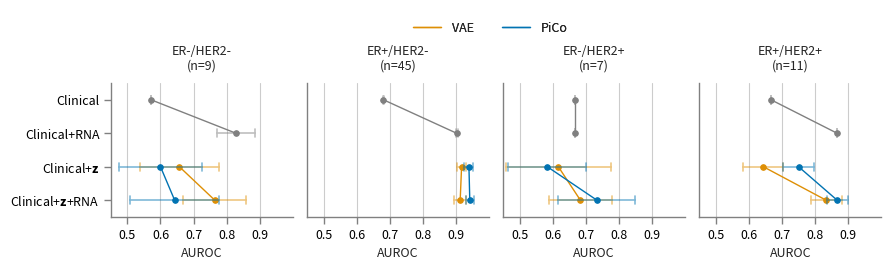

In [12]:
# COMBINED TRAIN AND EXT VAL PERFORMANCE -- DATASET FACET
# AUROC
from matplotlib.lines import Line2D

metric = "auroc"

target = "RCB.score"

palette = sns.color_palette("colorblind")
# palette = {"PiCo_D": pal[1], "VAE": pal[0],}
pal_0_desat = sns.set_hls_values(palette[0], l=0.6, s=0.5)
pal_1_desat = sns.set_hls_values(palette[1], l=0.6, s=0.5)
pal_ev = {
    "vae": palette[1],
    "icovae_MCL1_16": palette[0],
    "NA": "grey",
}

plot_order = ["Clinical", "Clinical+RNA", "Clinical+Rep", "Clinical+Rep+RNA"]

facet_order = ["TransNEO\nCross-validation", "ARTemis+PBCP\nExternal validation"]

fig, axes = plt.subplots(1, 4, figsize=(9, 2.5), sharex=True)

## PLOTS EXT VAL RESULTS
metrics_df_plot = test_metrics_df.copy(deep=True)
metrics_df_plot["rep_type_hue"] = metrics_df_plot["rep_type"].copy()
metrics_df_plot.loc[
    metrics_df_plot["feat_sets"].isin(["Clinical+RNA", "Clinical", "RNA"]),
    "rep_type_hue",
] = "NA"

subtypes = metrics_df_plot["subtype"].unique()


for i, ax in enumerate(axes):
    curr_metrics_plot = metrics_df_plot[metrics_df_plot["subtype"] == subtypes[i]]
    if target == "RCB.score":
        sns.pointplot(
            data=curr_metrics_plot,
            y="feat_sets",
            x=metric,
            hue="rep_type_hue",
            order=plot_order,
            palette=pal_ev,
            linestyle="-",
            linewidth=1,
            markersize=4,
            marker="o",
            errorbar=("sd", 1),
            capsize=0.25,
            err_kws={"linewidth": 1.2, "alpha": 0.5},
            ax=ax,
            legend=False,
        )
    else:
        sns.pointplot(
            data=curr_metrics_plot,
            y="feat_sets",
            x=metric,
            hue="rep_type_hue",
            palette=pal_ev,
            order=plot_order,
            linestyle="-",
            linewidth=1,
            markersize=4,
            marker="o",
            errorbar=("sd", 1),
            capsize=0.25,
            err_kws={"linewidth": 1.2, "alpha": 0.5},
            ax=ax,
            legend=False,
        )

    handles, labels = plt.gca().get_legend_handles_labels()

    line_train = Line2D(
        [0], [0], label="VAE", color=palette[1], linestyle="-", linewidth=1
    )
    line_val = Line2D(
        [0], [0], label="PiCo", color=palette[0], linestyle="-", linewidth=1
    )

    if i == len(subtypes) - 1:
        leg1 = ax.legend(
            handles=handles[3:],
            bbox_to_anchor=(1.0, 1.6),
            loc="upper center",
            frameon=False,
            ncol=2,
            fontsize=10,
        )

        leg2 = ax.legend(
            handles=[line_train, line_val],
            bbox_to_anchor=(-1.15, 1.55),
            loc="upper center",
            frameon=False,
            ncol=2,
            fontsize=10,
        )

        ax.add_artist(leg1)
        ax.add_artist(leg2)

    # Rename y ticks
    names_dict = {
        "Clinical": "Clinical",
        "Clinical+RNA": "Clinical+RNA",
        "Clinical+Rep": r"Clinical+$\mathbf{z}$",
        "Clinical+Rep+RNA": r"Clinical+$\mathbf{z}$+RNA",
    }
    # ax.set_yticks(names_dict.keys())
    ax.set_yticklabels(names_dict.values())

    # sns.move_legend(ax, "upper center", bbox_to_anchor=(.5, -.2), ncol=1, title=None, frameon=False)
    sns.despine()
    ax.set_ylabel("")
    if target == "RCB.score":
        if metric == "spearman_r":
            ax.set_xlabel("Spearman\ncorrelation", fontsize=10)
            ax.set_xlim(0.5, 0.82)
            ax.set_xticks([0.5, 0.6, 0.7, 0.8], [0.5, 0.6, 0.7, 0.8])
        elif metric == "pearson_r":
            ax.set_xlabel("Pearson\ncorrelation", fontsize=10)
            ax.set_xlim(0.5, 0.82)
            ax.set_xticks([0.5, 0.6, 0.7, 0.8], [0.5, 0.6, 0.7, 0.8])
        elif metric == "test_rmse":
            ax.set_xlabel("RMSE", fontsize=10)
            ax.set_xlim(0.85, 1.15)
            ax.set_xticks([0.9, 1.0, 1.1], [0.9, 1.0, 1.1])
        if metric == "auroc":
            ax.set_xlabel("AUROC", fontsize=10)
            ax.set_xlim(0.45, 1.0)
            ax.set_xticks([0.5, 0.6, 0.7, 0.8, 0.9], [0.5, 0.6, 0.7, 0.8, 0.9])
    else:
        if metric == "test_auroc":
            ax.set_xlabel("AUROC", fontsize=10)
            ax.set_xlim(0.62, 0.92)
            ax.set_xticks([0.7, 0.8, 0.9], [0.7, 0.8, 0.9])
        elif metric == "test_aupr":
            ax.set_xlabel("AUPR", fontsize=10)
            ax.set_xlim(0.35, 0.75)
            ax.set_xticks([0.4, 0.5, 0.6, 0.7], [0.4, 0.5, 0.6, 0.7])
        elif metric == "test_f1":
            ax.set_xlabel("F1 score", fontsize=10)
            ax.set_xlim(0.35, 0.75)
            ax.set_xticks([0.4, 0.5, 0.6, 0.7], [0.4, 0.5, 0.6, 0.7])
        elif metric == "test_cross_entropy":
            ax.set_xlabel("Cross-entropy", fontsize=10)
            ax.set_xlim(0.3, 0.6)
            ax.set_xticks([0.3, 0.4, 0.5, 0.6], [0.3, 0.4, 0.5, 0.6])
    ax.set_title("")
    ax.text(
        s=f"{subtypes[i]}\n(n={curr_metrics_plot['n'].iloc[0]})",
        x=0.5,
        y=1.1,
        transform=ax.transAxes,
        fontweight="regular",
        horizontalalignment="center",
        fontsize=10,
    )
    ax.grid(visible=True, axis="x")
    ax.tick_params(labelsize=10)
    if i > 0:
        sns.despine(left=False, ax=ax)
        ax.tick_params(
            top=False,
            bottom=True,
            left=False,
            right=False,
            labelleft=False,
            labelbottom=True,
            labelsize=10,
        )
    # ax.set_xlabel("Spearman correlation")

fig.tight_layout()

plt.savefig(
    f"./figures/transneo/perf_facet_{target}_{metric}_subtype.png",
    # bbox_extra_artists=(leg1, leg2),
    bbox_inches="tight",
    dpi=600,
)
plt.savefig(
    f"./figures/transneo/perf_facet_{target}_{metric}_subtype.svg",
    # bbox_extra_artists=(leg1, leg2),
    bbox_inches="tight",
)

## 4.2 Representation associations with outcome and other variables

### 4.2.1 Single feature scatter plots

In [11]:
## SCATTER PLOT FEATURES
from scipy.stats import pointbiserialr, spearmanr
from functools import partial


def rep_renamer(x, constraints, prefix="z"):
    dim = int(x.split("_")[1])
    if dim < len(constraints):
        return f"{prefix}_{constraints[dim]}"
    else:
        return x


rep_type = "icovae_MCL1_16"
target = "RCB.score"
experiment = "artemis_pbcp"
model_type = "ElasticNet"


def pbc_corr(x1, x2):
    u_1 = len(np.unique(x1))
    u_2 = len(np.unique(x2))

    if min(u_1, u_2) == 2:
        res = pointbiserialr(x1, x2)
    else:
        res = spearmanr(x1, x2)

    return res[0]


res_root = f"{wd_path}/data/outputs/depmap_gdsc_transneo/{target}/{experiment}/pico"
ext = "_Size.at.diagnosis_18"

model_path = f"{res_root}/{model_type}_{rep_type + ext}"


corrs = []
corrs_val = []
for seed in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]:
    # LOAD ARGUMENTS
    with open(f"{model_path}/args_best_s{seed}.txt", "r") as f:
        args = json.load(f)

    print(args)

    constraints = args["constraints"]
    n_constraints = len(constraints)
    confounders = args["confounders"]
    if confounders is None:
        n_confounders = 0
    else:
        n_confounders = len(confounders)

    # Load predictions
    test_z = pd.read_csv(f"{model_path}/z_pred_test_s{seed}.csv")
    train_z = pd.read_csv(f"{model_path}/z_pred_train_s{seed}.csv")

    # Rename test df
    test_z_rep_z = test_z.iloc[:, test_z.columns.str.startswith("z")]
    test_z_rep_c = test_z.iloc[:, test_z.columns.str.startswith("c")]
    test_z_rep_z = test_z_rep_z.rename(
        mapper=partial(rep_renamer, constraints=constraints, prefix="z"), axis=1
    )
    test_z_rep_c = test_z_rep_c.rename(
        mapper=partial(rep_renamer, constraints=confounders, prefix="c"), axis=1
    )

    test_z_rep = pd.concat([test_z_rep_z, test_z_rep_c], axis=1)

    # Rename train df
    train_z_rep_z = train_z.iloc[:, train_z.columns.str.startswith("z")]
    train_z_rep_c = train_z.iloc[:, train_z.columns.str.startswith("c")]
    train_z_rep_z = train_z_rep_z.rename(
        mapper=partial(rep_renamer, constraints=constraints, prefix="z"), axis=1
    )
    train_z_rep_c = train_z_rep_c.rename(
        mapper=partial(rep_renamer, constraints=confounders, prefix="c"), axis=1
    )

    train_z_rep = pd.concat([train_z_rep_z, train_z_rep_c], axis=1)

    feat_top_corr = pd.DataFrame(train_z_rep.corr(method="spearman"))
    feat_top_corr["seed"] = seed
    corrs.append(feat_top_corr)

    feat_top_corr_val = pd.DataFrame(test_z_rep.corr(method="spearman"))
    feat_top_corr_val["seed"] = seed
    corrs_val.append(feat_top_corr_val)

# corrs = pd.DataFrame(corrs)
# corrs_val = pd.DataFrame(corrs_val)

# r, p = pearsonr(x[feat_1], x[feat_2])
# print(f"{p*len(x.columns):.3e}")

# f, ax = plt.subplots(1,1, figsize=(2,2))
# sns.scatterplot(data=x, x=feat_1, y=feat_2, hue=hue, ax=ax, palette="Set2")
# sns.despine(ax=ax)
# ax.text(s=f"$r_{{p}} = {r:.3f}, p = {p*len(x.columns):.3f}$", x=0.1, y=1.0, transform=ax.transAxes, size=8)

# feat_1_split = feat_1.split("_")
# if feat_1_split[0] == "z":
#     ax.set_xlabel(rf"$z_{{{feat_1_split[1]}}}$")
# else:
#     ax.set_xlabel(names_map[feat_1])

# ax.set_ylabel(names_map[feat_2])


# plt.savefig(f"./ext_val_sammut/figures/corr_{feat_1}_{feat_2}.png", dpi=600, bbox_inches="tight")
# plt.savefig(f"./ext_val_sammut/figures/corr_{feat_1}_{feat_2}.svg", bbox_inches="tight")

{'target': 'RCB.score', 'dataset': 'depmap_gdsc_transneo', 'enc': 'iCoVAE', 'reg': 'ElasticNet', 'constraints': ['MCL1', 'PSMC1', 'FANCF', 'RAD1', 'PPM1D', 'SMU1', 'HSPA14', 'GBF1', 'MDM4', 'KNTC1', 'LRWD1', 'CEP97', 'ERBB2', 'ERBB3', 'EGFR', 'PIK3CA'], 'confounders': ['Size.at.diagnosis', 'LN.at.diagnosis', 'Age.at.diagnosis', 'Histology', 'ER.status', 'HER2.status', 'Grade.pre.chemotherapy', 'PGR.log2.tpm', 'ESR1.log2.tpm', 'ERBB2.log2.tpm', 'GGI.ssgsea.notnorm', 'ESC.ssgsea.notnorm', 'Swanton.PaclitaxelScore', 'STAT1.ssgsea.notnorm', 'TIDE.Dysfunction', 'TIDE.Exclusion', 'Danaher.Mast.cells', 'CytScore.log2'], 'seed': 10, 'data_dir': './data', 'norm': False, 'lindec': False, 'filt': 'uni_var', 'experiment': 'artemis_pbcp', 'cuda': False, 'norep': False, 'newstudy': True, 'enc_path': '/home/dk538/rds/hpc-work/graphdep/data/outputs/depmap_gdsc_transneo/RCB.score/artemis_pbcp/icovae_MCL1_16', 'test_samples': ['A002', 'A004', 'A005', 'A007', 'A010', 'A012', 'A014', 'A017', 'A023', 'A042

### 4.2.2 All features correlation matrix heatmap

/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


$z_{MCL1}$     -0.388580
$z_{PSMC1}$    -0.356842
$z_{FANCF}$    -0.271027
$z_{RAD1}$     -0.411161
$z_{PPM1D}$    -0.453804
$z_{SMU1}$     -0.504284
$z_{HSPA14}$   -0.394043
$z_{GBF1}$     -0.612803
$z_{MDM4}$     -0.220225
$z_{KNTC1}$    -0.244003
$z_{LRWD1}$    -0.242088
$z_{CEP97}$    -0.220430
$z_{ERBB2}$    -0.657369
$z_{ERBB3}$    -0.591028
$z_{EGFR}$     -0.225119
$z_{PIK3CA}$   -0.646450
dtype: float64
$z_{MCL1}$      0.548393
$z_{PSMC1}$     0.258888
$z_{FANCF}$     0.556748
$z_{RAD1}$      0.341198
$z_{PPM1D}$     0.644680
$z_{SMU1}$      0.459775
$z_{HSPA14}$    0.309013
$z_{GBF1}$      0.508942
$z_{MDM4}$      0.399758
$z_{KNTC1}$     0.370700
$z_{LRWD1}$     0.274296
$z_{CEP97}$     0.168242
$z_{ERBB2}$     0.373101
$z_{ERBB3}$     0.309505
$z_{EGFR}$      0.417087
$z_{PIK3CA}$    0.642117
dtype: float64


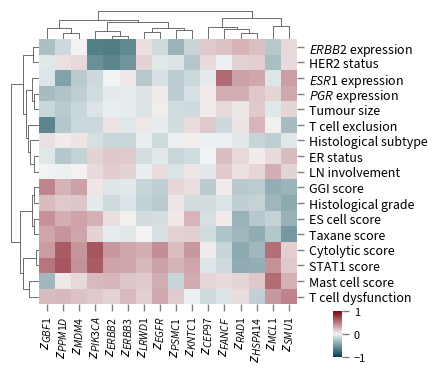

In [12]:
## REPRESENTATION CORRELATION WITH OTHER FEATURES
val = True

if val:
    corrs_df = (
        pd.concat(corrs_val, axis=0).reset_index().groupby("index").mean().reset_index()
    )
else:
    corrs_df = (
        pd.concat(corrs, axis=0).reset_index().groupby("index").mean().reset_index()
    )

pal = sns.color_palette("colorblind")


def feat_labeller(x):
    if x[0] == "z":
        return pal[0]
    elif x in [
        "ESR1.log2.tpm",
        "PGR.log2.tpm",
        "ERBB2.log2.tpm",
        "GGI.ssgsea.notnorm",
        "Swanton.PaclitaxelScore",
        "ESC.ssgsea.notnorm",
    ]:
        return pal[1]
    elif x in ["Danaher.Mast.cells", "STAT1.ssgsea.notnorm", "TIDE.Exclusion"]:
        return pal[2]
    elif x in [
        "CodingMuts.PIK3CA",
        "CodingMuts.TP53",
        "All.TMB",
        "Coding.TMB",
        "Expressed.NAg",
        "",
    ]:
        return pal[3]
    else:
        return pal[4]


# row_colors = corrs_df["index"].apply(lambda x: feat_labeller(x))
# row_colors.index = corrs_df["index"]
# row_colors = row_colors.rename(lambda x: x.split("_"))
# row_colors = row_colors.rename(lambda x: f"$z_{{{x[1]}}}$" if len(x) > 1 else names_map[x[0]])
# print(row_colors)

corrs_df = corrs_df.set_index("index")

col_plot = [
    not col.split("_")[1].isdigit() and (col.split("_")[0] == "z")
    if (len(col.split("_")) > 1)
    else False
    for col in corrs_df.columns
]

corrs_df = corrs_df.loc[~corrs_df.index.str.startswith("z"), col_plot].reset_index()

corrs_df["index"] = corrs_df["index"].apply(lambda x: x.split("_"))
corrs_df["index"] = corrs_df["index"].apply(
    lambda x: f"$z_{{{x[1]}}}$" if (x[0] == "z") else names_map[x[1]]
)

split_str = "_"

corrs_df = corrs_df.set_index("index").rename(
    lambda x: rf"$z_{{{x.split(split_str)[1]}}}$", axis=1
)

print(np.min(corrs_df))
print(np.max(corrs_df))

# Drop columns with all low values
corrs_df = corrs_df.T
for col in corrs_df:
    # If all value in column less than 0.2 then drop
    if (corrs_df[col].abs() < 0.2).all():
        corrs_df = corrs_df.drop(col, axis=1)

fig_width = len(corrs_df.columns)

g = sns.clustermap(
    corrs_df.T,
    yticklabels=True,
    xticklabels=True,
    figsize=(4.5, fig_width / 4.6),
    method="complete",
    cmap=sns.diverging_palette(220, 10, s=100, l=25, as_cmap=True),
    vmin=-1,
    vmax=1,
    center=0,
    cbar_pos=(0.75, 0.02, 0.02, 0.125),
    dendrogram_ratio=0.1,
)
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize=12)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize=10)
g.ax_heatmap.set_ylabel("")
g.ax_heatmap.set_xlabel("")

plt.savefig(
    f"./figures/transneo/feat_corr_hm_{rep_type}_{'val' if val else 'train'}.png",
    bbox_inches="tight",
    dpi=600,
)
plt.savefig(
    f"./figures/transneo/feat_corr_hm_{rep_type}_{'val' if val else 'train'}.svg",
    bbox_inches="tight",
)

In [13]:
corrs_df

index,Cytolytic score,Mast cell score,ER status,$\t{{ERBB2}}$ expression,ES cell score,$\t{{ESR1}}$ expression,GGI score,Histological grade,HER2 status,Histological subtype,LN involvement,$\t{{PGR}}$ expression,STAT1 score,Tumour size,Taxane score,T cell dysfunction,T cell exclusion
$z_{MCL1}$,0.541824,0.548393,0.094716,-0.236106,-0.184569,-0.074028,-0.388580,-0.342981,-0.289573,-0.204880,0.286497,0.117932,0.397812,-0.068858,-0.254213,0.368356,0.011279
$z_{PSMC1}$,0.216703,-0.175801,-0.158010,-0.356842,0.044831,-0.218316,0.111420,0.050209,-0.078450,-0.021227,-0.091842,-0.214211,0.258888,-0.126227,0.140327,0.156381,-0.128117
$z_{FANCF}$,-0.173605,0.097337,0.213637,0.197363,0.026472,0.556748,0.028791,-0.086753,-0.010527,-0.012130,0.168521,0.280572,-0.140296,0.104664,-0.271027,-0.084296,-0.142105
$z_{RAD1}$,-0.411161,0.121738,0.102534,0.264036,-0.358450,0.341198,-0.227519,-0.195784,0.130221,-0.061218,0.070761,0.274304,-0.397809,0.047008,-0.343383,0.092074,0.054900
$z_{PPM1D}$,0.619198,0.041323,-0.248216,-0.141810,0.275434,-0.453804,0.258119,0.164554,0.077729,0.027482,-0.011465,-0.268432,0.644680,-0.224804,0.384390,0.240926,-0.244818
$z_{SMU1}$,0.146003,0.266882,0.223860,0.103439,-0.362538,0.347687,-0.353124,-0.412746,0.096620,-0.064629,0.132277,0.298105,0.166435,0.121158,-0.504284,0.459775,-0.310068
$z_{HSPA14}$,-0.331986,0.177252,0.031121,0.209209,-0.234845,0.309013,-0.211707,-0.180811,0.146950,-0.166785,0.112799,0.172162,-0.389838,0.169818,-0.394043,-0.201884,0.248978
$z_{GBF1}$,0.355354,-0.335917,-0.067654,-0.286388,0.403326,-0.077505,0.449098,0.220694,-0.062443,0.072210,-0.001603,-0.312486,0.508942,-0.163363,0.318560,0.222217,-0.612803
$z_{MDM4}$,0.379252,0.105576,-0.185523,0.001063,0.322467,-0.220225,0.331929,0.180019,0.107725,0.060270,0.004808,-0.206239,0.399758,-0.162771,0.318538,0.200222,-0.156125
$z_{KNTC1}$,0.370700,0.293511,-0.128844,-0.166627,0.256990,-0.151570,0.080404,-0.118581,-0.244003,0.020848,0.053626,-0.109004,0.315903,-0.135509,0.144245,-0.010623,0.092113


       index    z_MCL1   z_PSMC1   z_FANCF    z_RAD1   z_PPM1D    z_SMU1  \
0    z_CEP97  0.264850 -0.371363 -0.026220  0.120399  0.164645 -0.041746   
1     z_EGFR  0.308484  0.115125 -0.134436 -0.126987  0.316285  0.261611   
2    z_ERBB2  0.070821  0.533495 -0.204791 -0.277124 -0.124849 -0.111707   
3    z_ERBB3  0.050904  0.571367 -0.174995 -0.196581 -0.181169 -0.001352   
4    z_FANCF  0.024143 -0.275812  1.000000  0.428817 -0.283052  0.179287   
5     z_GBF1 -0.206259  0.567681 -0.148403 -0.395244  0.310374 -0.023269   
6   z_HSPA14  0.029294 -0.309801  0.202727  0.301480 -0.232929  0.070406   
7    z_KNTC1  0.141621 -0.110674 -0.252141 -0.211560  0.385648 -0.213759   
8    z_LRWD1  0.172576 -0.064611 -0.277971 -0.067546  0.357285  0.050376   
9     z_MCL1  1.000000  0.058629  0.024143  0.028934  0.196703  0.285569   
10    z_MDM4 -0.001649 -0.134261 -0.012912 -0.085836  0.564931 -0.144586   
11  z_PIK3CA  0.105848  0.482458 -0.280151 -0.472366  0.242922 -0.249121   
12   z_PPM1D

/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/seaborn/matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


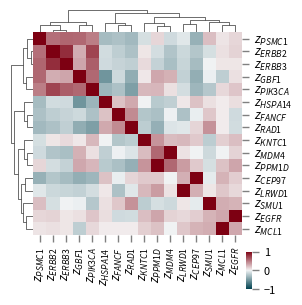

In [14]:
## REPRESENTATION CORRELATION WITH ITSELF
val = False
if val:
    corrs_df = (
        pd.concat(corrs_val, axis=0).reset_index().groupby("index").mean().reset_index()
    )
else:
    corrs_df = (
        pd.concat(corrs, axis=0).reset_index().groupby("index").mean().reset_index()
    )

corrs_df = corrs_df.set_index("index")

col_plot = [
    not col.split("_")[1].isdigit() if (col.split("_")[0] == "z") else False
    for col in corrs_df.columns
]

row_plot = [
    not row.split("_")[1].isdigit() if (row.split("_")[0] == "z") else False
    for row in corrs_df.index
]

corrs_df = corrs_df.loc[row_plot, col_plot].reset_index()

print(corrs_df)

corrs_df["index"] = corrs_df["index"].apply(lambda x: x.split("_"))
corrs_df["index"] = corrs_df["index"].apply(
    lambda x: f"$z_{{{x[1]}}}$" if len(x) > 1 else names_map[x[0]]
)

split_str = "_"

corrs_df = corrs_df.set_index("index").rename(
    lambda x: rf"$z_{{{x.split(split_str)[1]}}}$", axis=1
)

g = sns.clustermap(
    corrs_df,
    square=True,
    yticklabels=True,
    xticklabels=True,
    figsize=(3.25, 3),
    method="complete",
    cmap=sns.diverging_palette(220, 10, s=100, l=25, as_cmap=True),
    cbar_pos=(0.77, 0.02, 0.02, 0.125),
    dendrogram_ratio=0.1,
    center=0.0,
    vmax=1,
    vmin=-1,
)
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize=10)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize=10)
g.ax_heatmap.set_ylabel("")

plt.savefig(
    f"./figures/transneo/rep_corr_hm_{rep_type}_{'val' if val else 'train'}.png",
    bbox_inches="tight",
    dpi=600,
)
plt.savefig(
    f"./figures/transneo/rep_corr_hm_{rep_type}_{'val' if val else 'train'}.svg",
    bbox_inches="tight",
)

### 4.2.3 Single variable associations with outcome

In [10]:
# CORRELATION WITH RCB SCORE
from scipy.stats import fisher_exact, mannwhitneyu
import json
from scipy.stats import spearmanr
from functools import partial


def rep_renamer(x, constraints, prefix="z"):
    dim = int(x.split("_")[1])
    if dim < len(constraints):
        return f"{prefix}_{constraints[dim]}"
    else:
        return x


rep_type = "icovae_MCL1_16"
target = "RCB.score"
experiment = "artemis_pbcp"
model_type = "ElasticNet"


def pbc_corr(x1, x2):
    u_1 = len(np.unique(x1))
    u_2 = len(np.unique(x2))

    if min(u_1, u_2) == 2:
        res = pointbiserialr(x1, x2)
    else:
        res = spearmanr(x1, x2)

    return res[0]


res_root = f"{wd_path}/data/outputs/depmap_gdsc_transneo/{target}/{experiment}/pico"
ext = "_Size.at.diagnosis_18"

model_path = f"{res_root}/{model_type}_{rep_type + ext}"


corrs = []
corrs_val = []
for seed in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]:
    # LOAD ARGUMENTS
    with open(f"{model_path}/args_best_s{seed}.txt", "r") as f:
        args = json.load(f)

    print(args)

    constraints = args["constraints"]
    n_constraints = len(constraints)
    confounders = args["confounders"]
    if confounders is None:
        n_confounders = 0
    else:
        n_confounders = len(confounders)

    # Load predictions
    test_z = pd.read_csv(f"{model_path}/z_pred_test_s{seed}.csv")
    train_z = pd.read_csv(f"{model_path}/z_pred_train_s{seed}.csv")

    # Rename test df
    test_z_rep_z = test_z.iloc[:, test_z.columns.str.startswith("z")]
    test_z_rep_c = test_z.iloc[:, test_z.columns.str.startswith("c")]
    test_z_rep_y = test_z[["y"]]
    test_z_rep_z = test_z_rep_z.rename(
        mapper=partial(rep_renamer, constraints=constraints, prefix="z"), axis=1
    )
    test_z_rep_c = test_z_rep_c.rename(
        mapper=partial(rep_renamer, constraints=confounders, prefix="c"), axis=1
    )
    test_z_rep_y = test_z_rep_y.rename({"y": target}, axis=1)

    test_z_rep = pd.concat([test_z_rep_z, test_z_rep_c, test_z_rep_y], axis=1).dropna(
        axis=0
    )

    # Rename train df
    train_z_rep_z = train_z.iloc[:, train_z.columns.str.startswith("z")]
    train_z_rep_c = train_z.iloc[:, train_z.columns.str.startswith("c")]
    train_z_rep_y = train_z[["y"]]
    train_z_rep_z = train_z_rep_z.rename(
        mapper=partial(rep_renamer, constraints=constraints, prefix="z"), axis=1
    )
    train_z_rep_c = train_z_rep_c.rename(
        mapper=partial(rep_renamer, constraints=confounders, prefix="c"), axis=1
    )
    train_z_rep_y = train_z_rep_y.rename({"y": target}, axis=1)

    train_z_rep = pd.concat(
        [train_z_rep_z, train_z_rep_c, train_z_rep_y], axis=1
    ).dropna(axis=0)

    for col in train_z_rep.columns:
        if col != target:
            corrs.append(
                {
                    "feat": col,
                    "seed": seed,
                    "spearmanr": spearmanr(train_z_rep[col], train_z_rep[target])[0],
                    "pearsonr": pearsonr(train_z_rep[col], train_z_rep[target])[0],
                }
            )

    for col in test_z_rep.columns:
        if col != target:
            corrs_val.append(
                {
                    "feat": col,
                    "seed": seed,
                    "spearmanr": spearmanr(test_z_rep[col], test_z_rep[target])[0],
                    "pearsonr": pearsonr(test_z_rep[col], test_z_rep[target])[0],
                }
            )

{'target': 'RCB.score', 'dataset': 'depmap_gdsc_transneo', 'enc': 'iCoVAE', 'reg': 'ElasticNet', 'constraints': ['MCL1', 'PSMC1', 'FANCF', 'RAD1', 'PPM1D', 'SMU1', 'HSPA14', 'GBF1', 'MDM4', 'KNTC1', 'LRWD1', 'CEP97', 'ERBB2', 'ERBB3', 'EGFR', 'PIK3CA'], 'confounders': ['Size.at.diagnosis', 'LN.at.diagnosis', 'Age.at.diagnosis', 'Histology', 'ER.status', 'HER2.status', 'Grade.pre.chemotherapy', 'PGR.log2.tpm', 'ESR1.log2.tpm', 'ERBB2.log2.tpm', 'GGI.ssgsea.notnorm', 'ESC.ssgsea.notnorm', 'Swanton.PaclitaxelScore', 'STAT1.ssgsea.notnorm', 'TIDE.Dysfunction', 'TIDE.Exclusion', 'Danaher.Mast.cells', 'CytScore.log2'], 'seed': 10, 'data_dir': './data', 'norm': False, 'lindec': False, 'filt': 'uni_var', 'experiment': 'artemis_pbcp', 'cuda': False, 'norep': False, 'newstudy': True, 'enc_path': '/home/dk538/rds/hpc-work/graphdep/data/outputs/depmap_gdsc_transneo/RCB.score/artemis_pbcp/icovae_MCL1_16', 'test_samples': ['A002', 'A004', 'A005', 'A007', 'A010', 'A012', 'A014', 'A017', 'A023', 'A042

     index                     feat  seed  spearmanr  pearsonr       dataset  \
72      72  $\t{{ESR1}}$ expression    10   0.494929  0.500093      TransNEO   
154    154  $\t{{ESR1}}$ expression    20   0.494929  0.500093      TransNEO   
236    236  $\t{{ESR1}}$ expression    30   0.494929  0.500093      TransNEO   
318    318  $\t{{ESR1}}$ expression    40   0.494929  0.500093      TransNEO   
400    400  $\t{{ESR1}}$ expression    50   0.494929  0.500093      TransNEO   
..     ...                      ...   ...        ...       ...           ...   
471    471                 $z_{61}$    60   0.255246  0.230822  ARTemis+PBCP   
553    553                 $z_{61}$    70  -0.309090 -0.335310  ARTemis+PBCP   
635    635                 $z_{61}$    80  -0.348475 -0.334432  ARTemis+PBCP   
717    717                 $z_{61}$    90   0.137530  0.166245  ARTemis+PBCP   
799    799                 $z_{61}$   100   0.042241  0.002025  ARTemis+PBCP   

     mean_spearmanr  mean_pearsonr  abs

/tmp/ipykernel_64958/3987668636.py:30: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.pointplot(data=corrs_df, x=metric, y="feat", hue="dataset", ax=ax, errorbar=("sd", 1),
/tmp/ipykernel_64958/3987668636.py:66: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.savefig(
/tmp/ipykernel_64958/3987668636.py:66: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.savefig(


     index                     feat  seed  spearmanr  pearsonr       dataset  \
72      72  $\t{{ESR1}}$ expression    10   0.494929  0.500093      TransNEO   
154    154  $\t{{ESR1}}$ expression    20   0.494929  0.500093      TransNEO   
236    236  $\t{{ESR1}}$ expression    30   0.494929  0.500093      TransNEO   
318    318  $\t{{ESR1}}$ expression    40   0.494929  0.500093      TransNEO   
400    400  $\t{{ESR1}}$ expression    50   0.494929  0.500093      TransNEO   
..     ...                      ...   ...        ...       ...           ...   
452    452                 $z_{42}$    60   0.345537  0.365481  ARTemis+PBCP   
534    534                 $z_{42}$    70  -0.401085 -0.401985  ARTemis+PBCP   
616    616                 $z_{42}$    80  -0.527045 -0.498566  ARTemis+PBCP   
698    698                 $z_{42}$    90   0.261981  0.239323  ARTemis+PBCP   
780    780                 $z_{42}$   100   0.127777  0.195444  ARTemis+PBCP   

     mean_spearmanr  mean_pearsonr  abs

/tmp/ipykernel_64958/3987668636.py:30: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.pointplot(data=corrs_df, x=metric, y="feat", hue="dataset", ax=ax, errorbar=("sd", 1),
/tmp/ipykernel_64958/3987668636.py:66: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.savefig(
/tmp/ipykernel_64958/3987668636.py:66: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.savefig(


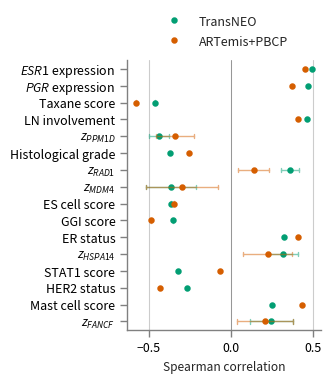

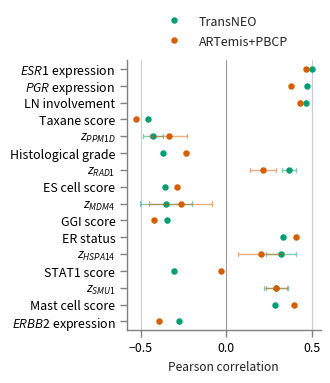

In [12]:
for metric in ["spearmanr", "pearsonr"]:
    palette = sns.color_palette("colorblind")[2:]

    corrs_df_val = pd.DataFrame.from_dict(corrs_val).reset_index()

    corrs_df = pd.DataFrame.from_dict(corrs).reset_index()

    corrs_df_val["dataset"] = "ARTemis+PBCP"
    corrs_df["dataset"] = "TransNEO"

    corrs_df = pd.concat([corrs_df_val, corrs_df], axis=0)

    corrs_df["mean_spearmanr"] = (
        corrs_df.groupby(["dataset", "feat"])
        .transform("mean")["spearmanr"]
        .astype(float)
    )
    corrs_df["mean_pearsonr"] = (
        corrs_df.groupby(["dataset", "feat"])
        .transform("mean")["pearsonr"]
        .astype(float)
    )

    corrs_df["abs_spearmanr"] = corrs_df["spearmanr"].abs().astype(float)
    corrs_df["abs_pearsonr"] = corrs_df["pearsonr"].abs().astype(float)

    corrs_df["feat"] = corrs_df["feat"].apply(lambda x: x.split("_"))
    corrs_df["feat"] = corrs_df["feat"].apply(
        lambda x: f"$z_{{{x[1]}}}$" if x[0] == "z" else names_map[x[1]]
    )

    corrs_df = corrs_df.sort_values(
        by=["dataset", f"mean_{metric.split('_')[-1]}"],
        key=lambda x: abs(x) if x.dtypes == "float64" else x,
        ascending=[False, False],
    )
    print(corrs_df)

    fig, ax = plt.subplots(1, 1, figsize=(2.5, 3.5))

    sns.pointplot(
        data=corrs_df,
        x=metric,
        y="feat",
        hue="dataset",
        ax=ax,
        errorbar=("sd", 1),
        capsize=0.25,
        linestyle="none",
        markersize=3,
        err_kws={"linewidth": 1, "alpha": 0.5},
        palette=palette,
    )

    if metric == "abs_spearmanr":
        ax.set_xlabel("Abs. Spearman correlation")
    elif metric == "abs_pearsonr":
        ax.set_xlabel("Abs. Pearson correlation")
    elif metric == "spearmanr":
        ax.set_xlabel("Spearman correlation")
    elif metric == "pearsonr":
        ax.set_xlabel("Pearson correlation")
    else:
        raise ValueError("Invalid metric")
    ax.set_ylabel("")
    ax.tick_params(
        top=False,
        bottom=True,
        left=True,
        right=False,
        labelleft=True,
        labelbottom=True,
        labelsize=10,
    )
    sns.despine(ax=ax)

    ax.grid(visible=True, axis="x")

    ax.set_ylim(15.5, -0.5)
    ax.axvline(0, c="grey", lw=0.5)

    ax.legend(
        frameon=False,
        title="",
        ncol=1,
        bbox_to_anchor=(0.5, 1.0),
        loc="lower center",
        fontsize=10,
    )  # , labels=["TransNEO", "ARTemis+PBCP"])

    plt.savefig(
        f"./figures/transneo/{metric}_assocs_{rep_type}.svg",
        bbox_inches="tight",
    )
    plt.savefig(
        f"./figures/transneo/{metric}_assocs_{rep_type}.png",
        bbox_inches="tight",
        dpi=600,
    )

In [13]:
corrs_df.groupby(["feat", "dataset"]).mean().sort_values(
    "abs_spearmanr", ascending=False
).head(50)

,,index,seed,spearmanr,pearsonr,mean_spearmanr,mean_pearsonr,abs_spearmanr,abs_pearsonr
feat,dataset,,,,,,,,
Taxane score,ARTemis+PBCP,445.0,55.0,-0.580142,-0.529654,-0.580142,-0.529654,0.580142,0.529654
$\t{{ESR1}}$ expression,TransNEO,441.0,55.0,0.494929,0.500093,0.494929,0.500093,0.494929,0.500093
GGI score,ARTemis+PBCP,443.0,55.0,-0.485924,-0.424593,-0.485924,-0.424593,0.485924,0.424593
$\t{{PGR}}$ expression,TransNEO,440.0,55.0,0.473129,0.472334,0.473129,0.472334,0.473129,0.472334
Taxane score,TransNEO,445.0,55.0,-0.464502,-0.460049,-0.464502,-0.460049,0.464502,0.460049
LN involvement,TransNEO,434.0,55.0,0.462869,0.467783,0.462869,0.467783,0.462869,0.467783
$\t{{ESR1}}$ expression,ARTemis+PBCP,441.0,55.0,0.454636,0.465915,0.454636,0.465915,0.454636,0.465915
$z_{PPM1D}$,TransNEO,373.0,55.0,-0.438235,-0.429343,-0.438235,-0.429343,0.438235,0.429343
Mast cell score,ARTemis+PBCP,449.0,55.0,0.435910,0.398281,0.435910,0.398281,0.435910,0.398281


In [7]:
# CORRELATION WITH RCB SCORE SEPARATED BY SUBTYPE

import json
from scipy.stats import spearmanr
from functools import partial


def rep_renamer(x, constraints, prefix="z"):
    dim = int(x.split("_")[1])
    if dim < len(constraints):
        return f"{prefix}_{constraints[dim]}"
    else:
        return x


rep_type = "icovae_MCL1_16"
target = "RCB.score"
experiment = "artemis_pbcp"
model_type = "ElasticNet"


def pbc_corr(x1, x2):
    u_1 = len(np.unique(x1))
    u_2 = len(np.unique(x2))

    if min(u_1, u_2) == 2:
        res = pointbiserialr(x1, x2)
    else:
        res = spearmanr(x1, x2)

    return res[0]


res_root = f"{wd_path}/data/outputs/depmap_gdsc_transneo/{target}/{experiment}/pico"
ext = "_Size.at.diagnosis_18"

model_path = f"{res_root}/{model_type}_{rep_type + ext}"


corrs_subtype = []
corrs_subtype_val = []
for seed in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]:
    # LOAD ARGUMENTS
    with open(f"{model_path}/args_best_s{seed}.txt", "r") as f:
        args = json.load(f)

    print(args)

    constraints = args["constraints"]
    n_constraints = len(constraints)
    confounders = args["confounders"]
    if confounders is None:
        n_confounders = 0
    else:
        n_confounders = len(confounders)

    # Load predictions
    test_z = pd.read_csv(f"{model_path}/z_pred_test_s{seed}.csv")
    train_z = pd.read_csv(f"{model_path}/z_pred_train_s{seed}.csv")

    # Rename test df
    test_z_rep_z = test_z.iloc[:, test_z.columns.str.startswith("z")]
    test_z_rep_c = test_z.iloc[:, test_z.columns.str.startswith("c")]
    test_z_rep_y = test_z[["y"]]
    test_z_rep_z = test_z_rep_z.rename(
        mapper=partial(rep_renamer, constraints=constraints, prefix="z"), axis=1
    )
    test_z_rep_c = test_z_rep_c.rename(
        mapper=partial(rep_renamer, constraints=confounders, prefix="c"), axis=1
    )
    test_z_rep_y = test_z_rep_y.rename({"y": target}, axis=1)

    test_z_rep = pd.concat([test_z_rep_z, test_z_rep_c, test_z_rep_y], axis=1).dropna(
        axis=0
    )

    # Rename train df
    train_z_rep_z = train_z.iloc[:, train_z.columns.str.startswith("z")]
    train_z_rep_c = train_z.iloc[:, train_z.columns.str.startswith("c")]
    train_z_rep_y = train_z[["y"]]
    train_z_rep_z = train_z_rep_z.rename(
        mapper=partial(rep_renamer, constraints=constraints, prefix="z"), axis=1
    )
    train_z_rep_c = train_z_rep_c.rename(
        mapper=partial(rep_renamer, constraints=confounders, prefix="c"), axis=1
    )
    train_z_rep_y = train_z_rep_y.rename({"y": target}, axis=1)

    train_z_rep = pd.concat(
        [train_z_rep_z, train_z_rep_c, train_z_rep_y], axis=1
    ).dropna(axis=0)

    train_z_rep_00 = train_z_rep[
        (train_z_rep["c_ER.status"] < 0) & (train_z_rep["c_HER2.status"] < 0)
    ]
    train_z_rep_10 = train_z_rep[
        (train_z_rep["c_ER.status"] > 0) & (train_z_rep["c_HER2.status"] < 0)
    ]
    train_z_rep_01 = train_z_rep[
        (train_z_rep["c_ER.status"] < 0) & (train_z_rep["c_HER2.status"] > 0)
    ]
    train_z_rep_11 = train_z_rep[
        (train_z_rep["c_ER.status"] > 0) & (train_z_rep["c_HER2.status"] > 0)
    ]

    test_z_rep_00 = test_z_rep[
        (test_z_rep["c_ER.status"] < 0) & (test_z_rep["c_HER2.status"] < 0)
    ]
    test_z_rep_10 = test_z_rep[
        (test_z_rep["c_ER.status"] > 0) & (test_z_rep["c_HER2.status"] < 0)
    ]
    test_z_rep_01 = test_z_rep[
        (test_z_rep["c_ER.status"] < 0) & (test_z_rep["c_HER2.status"] > 0)
    ]
    test_z_rep_11 = test_z_rep[
        (test_z_rep["c_ER.status"] > 0) & (test_z_rep["c_HER2.status"] > 0)
    ]

    reps_subtype = {
        "ER-/HER2-": (train_z_rep_00, test_z_rep_00),
        "ER+/HER2-": (train_z_rep_10, test_z_rep_10),
        "ER-/HER2+": (train_z_rep_01, test_z_rep_01),
        "ER+/HER2+": (train_z_rep_11, test_z_rep_11),
    }

    for subtype, (train_rep, test_rep) in reps_subtype.items():
        for col in train_rep.columns:
            if col != target:
                corrs_subtype.append(
                    {
                        "subtype": subtype,
                        "feat": col,
                        "seed": seed,
                        "spearmanr": spearmanr(train_rep[col], train_rep[target])[0],
                        "pearsonr": pearsonr(train_rep[col], train_rep[target])[0],
                    }
                )

        for col in test_rep.columns:
            if col != target:
                corrs_subtype_val.append(
                    {
                        "subtype": subtype,
                        "feat": col,
                        "seed": seed,
                        "spearmanr": spearmanr(test_rep[col], test_rep[target])[0],
                        "pearsonr": pearsonr(test_rep[col], test_rep[target])[0],
                    }
                )

{'target': 'RCB.score', 'dataset': 'depmap_gdsc_transneo', 'enc': 'iCoVAE', 'reg': 'ElasticNet', 'constraints': ['MCL1', 'PSMC1', 'FANCF', 'RAD1', 'PPM1D', 'SMU1', 'HSPA14', 'GBF1', 'MDM4', 'KNTC1', 'LRWD1', 'CEP97', 'ERBB2', 'ERBB3', 'EGFR', 'PIK3CA'], 'confounders': ['Size.at.diagnosis', 'LN.at.diagnosis', 'Age.at.diagnosis', 'Histology', 'ER.status', 'HER2.status', 'Grade.pre.chemotherapy', 'PGR.log2.tpm', 'ESR1.log2.tpm', 'ERBB2.log2.tpm', 'GGI.ssgsea.notnorm', 'ESC.ssgsea.notnorm', 'Swanton.PaclitaxelScore', 'STAT1.ssgsea.notnorm', 'TIDE.Dysfunction', 'TIDE.Exclusion', 'Danaher.Mast.cells', 'CytScore.log2'], 'seed': 10, 'data_dir': './data', 'norm': False, 'lindec': False, 'filt': 'uni_var', 'experiment': 'artemis_pbcp', 'cuda': False, 'norep': False, 'newstudy': True, 'enc_path': '/home/dk538/rds/hpc-work/graphdep/data/outputs/depmap_gdsc_transneo/RCB.score/artemis_pbcp/icovae_MCL1_16', 'test_samples': ['A002', 'A004', 'A005', 'A007', 'A010', 'A012', 'A014', 'A017', 'A023', 'A042

/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


{'target': 'RCB.score', 'dataset': 'depmap_gdsc_transneo', 'enc': 'iCoVAE', 'reg': 'ElasticNet', 'constraints': ['MCL1', 'PSMC1', 'FANCF', 'RAD1', 'PPM1D', 'SMU1', 'HSPA14', 'GBF1', 'MDM4', 'KNTC1', 'LRWD1', 'CEP97', 'ERBB2', 'ERBB3', 'EGFR', 'PIK3CA'], 'confounders': ['Size.at.diagnosis', 'LN.at.diagnosis', 'Age.at.diagnosis', 'Histology', 'ER.status', 'HER2.status', 'Grade.pre.chemotherapy', 'PGR.log2.tpm', 'ESR1.log2.tpm', 'ERBB2.log2.tpm', 'GGI.ssgsea.notnorm', 'ESC.ssgsea.notnorm', 'Swanton.PaclitaxelScore', 'STAT1.ssgsea.notnorm', 'TIDE.Dysfunction', 'TIDE.Exclusion', 'Danaher.Mast.cells', 'CytScore.log2'], 'seed': 20, 'data_dir': './data', 'norm': False, 'lindec': False, 'filt': 'uni_var', 'experiment': 'artemis_pbcp', 'cuda': False, 'norep': False, 'newstudy': True, 'enc_path': '/home/dk538/rds/hpc-work/graphdep/data/outputs/depmap_gdsc_transneo/RCB.score/artemis_pbcp/icovae_MCL1_16', 'test_samples': ['A002', 'A004', 'A005', 'A007', 'A010', 'A012', 'A014', 'A017', 'A023', 'A042

/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


{'target': 'RCB.score', 'dataset': 'depmap_gdsc_transneo', 'enc': 'iCoVAE', 'reg': 'ElasticNet', 'constraints': ['MCL1', 'PSMC1', 'FANCF', 'RAD1', 'PPM1D', 'SMU1', 'HSPA14', 'GBF1', 'MDM4', 'KNTC1', 'LRWD1', 'CEP97', 'ERBB2', 'ERBB3', 'EGFR', 'PIK3CA'], 'confounders': ['Size.at.diagnosis', 'LN.at.diagnosis', 'Age.at.diagnosis', 'Histology', 'ER.status', 'HER2.status', 'Grade.pre.chemotherapy', 'PGR.log2.tpm', 'ESR1.log2.tpm', 'ERBB2.log2.tpm', 'GGI.ssgsea.notnorm', 'ESC.ssgsea.notnorm', 'Swanton.PaclitaxelScore', 'STAT1.ssgsea.notnorm', 'TIDE.Dysfunction', 'TIDE.Exclusion', 'Danaher.Mast.cells', 'CytScore.log2'], 'seed': 30, 'data_dir': './data', 'norm': False, 'lindec': False, 'filt': 'uni_var', 'experiment': 'artemis_pbcp', 'cuda': False, 'norep': False, 'newstudy': True, 'enc_path': '/home/dk538/rds/hpc-work/graphdep/data/outputs/depmap_gdsc_transneo/RCB.score/artemis_pbcp/icovae_MCL1_16', 'test_samples': ['A002', 'A004', 'A005', 'A007', 'A010', 'A012', 'A014', 'A017', 'A023', 'A042

/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


{'target': 'RCB.score', 'dataset': 'depmap_gdsc_transneo', 'enc': 'iCoVAE', 'reg': 'ElasticNet', 'constraints': ['MCL1', 'PSMC1', 'FANCF', 'RAD1', 'PPM1D', 'SMU1', 'HSPA14', 'GBF1', 'MDM4', 'KNTC1', 'LRWD1', 'CEP97', 'ERBB2', 'ERBB3', 'EGFR', 'PIK3CA'], 'confounders': ['Size.at.diagnosis', 'LN.at.diagnosis', 'Age.at.diagnosis', 'Histology', 'ER.status', 'HER2.status', 'Grade.pre.chemotherapy', 'PGR.log2.tpm', 'ESR1.log2.tpm', 'ERBB2.log2.tpm', 'GGI.ssgsea.notnorm', 'ESC.ssgsea.notnorm', 'Swanton.PaclitaxelScore', 'STAT1.ssgsea.notnorm', 'TIDE.Dysfunction', 'TIDE.Exclusion', 'Danaher.Mast.cells', 'CytScore.log2'], 'seed': 40, 'data_dir': './data', 'norm': False, 'lindec': False, 'filt': 'uni_var', 'experiment': 'artemis_pbcp', 'cuda': False, 'norep': False, 'newstudy': True, 'enc_path': '/home/dk538/rds/hpc-work/graphdep/data/outputs/depmap_gdsc_transneo/RCB.score/artemis_pbcp/icovae_MCL1_16', 'test_samples': ['A002', 'A004', 'A005', 'A007', 'A010', 'A012', 'A014', 'A017', 'A023', 'A042

/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


{'target': 'RCB.score', 'dataset': 'depmap_gdsc_transneo', 'enc': 'iCoVAE', 'reg': 'ElasticNet', 'constraints': ['MCL1', 'PSMC1', 'FANCF', 'RAD1', 'PPM1D', 'SMU1', 'HSPA14', 'GBF1', 'MDM4', 'KNTC1', 'LRWD1', 'CEP97', 'ERBB2', 'ERBB3', 'EGFR', 'PIK3CA'], 'confounders': ['Size.at.diagnosis', 'LN.at.diagnosis', 'Age.at.diagnosis', 'Histology', 'ER.status', 'HER2.status', 'Grade.pre.chemotherapy', 'PGR.log2.tpm', 'ESR1.log2.tpm', 'ERBB2.log2.tpm', 'GGI.ssgsea.notnorm', 'ESC.ssgsea.notnorm', 'Swanton.PaclitaxelScore', 'STAT1.ssgsea.notnorm', 'TIDE.Dysfunction', 'TIDE.Exclusion', 'Danaher.Mast.cells', 'CytScore.log2'], 'seed': 50, 'data_dir': './data', 'norm': False, 'lindec': False, 'filt': 'uni_var', 'experiment': 'artemis_pbcp', 'cuda': False, 'norep': False, 'newstudy': True, 'enc_path': '/home/dk538/rds/hpc-work/graphdep/data/outputs/depmap_gdsc_transneo/RCB.score/artemis_pbcp/icovae_MCL1_16', 'test_samples': ['A002', 'A004', 'A005', 'A007', 'A010', 'A012', 'A014', 'A017', 'A023', 'A042

/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


{'target': 'RCB.score', 'dataset': 'depmap_gdsc_transneo', 'enc': 'iCoVAE', 'reg': 'ElasticNet', 'constraints': ['MCL1', 'PSMC1', 'FANCF', 'RAD1', 'PPM1D', 'SMU1', 'HSPA14', 'GBF1', 'MDM4', 'KNTC1', 'LRWD1', 'CEP97', 'ERBB2', 'ERBB3', 'EGFR', 'PIK3CA'], 'confounders': ['Size.at.diagnosis', 'LN.at.diagnosis', 'Age.at.diagnosis', 'Histology', 'ER.status', 'HER2.status', 'Grade.pre.chemotherapy', 'PGR.log2.tpm', 'ESR1.log2.tpm', 'ERBB2.log2.tpm', 'GGI.ssgsea.notnorm', 'ESC.ssgsea.notnorm', 'Swanton.PaclitaxelScore', 'STAT1.ssgsea.notnorm', 'TIDE.Dysfunction', 'TIDE.Exclusion', 'Danaher.Mast.cells', 'CytScore.log2'], 'seed': 60, 'data_dir': './data', 'norm': False, 'lindec': False, 'filt': 'uni_var', 'experiment': 'artemis_pbcp', 'cuda': False, 'norep': False, 'newstudy': True, 'enc_path': '/home/dk538/rds/hpc-work/graphdep/data/outputs/depmap_gdsc_transneo/RCB.score/artemis_pbcp/icovae_MCL1_16', 'test_samples': ['A002', 'A004', 'A005', 'A007', 'A010', 'A012', 'A014', 'A017', 'A023', 'A042

/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


{'target': 'RCB.score', 'dataset': 'depmap_gdsc_transneo', 'enc': 'iCoVAE', 'reg': 'ElasticNet', 'constraints': ['MCL1', 'PSMC1', 'FANCF', 'RAD1', 'PPM1D', 'SMU1', 'HSPA14', 'GBF1', 'MDM4', 'KNTC1', 'LRWD1', 'CEP97', 'ERBB2', 'ERBB3', 'EGFR', 'PIK3CA'], 'confounders': ['Size.at.diagnosis', 'LN.at.diagnosis', 'Age.at.diagnosis', 'Histology', 'ER.status', 'HER2.status', 'Grade.pre.chemotherapy', 'PGR.log2.tpm', 'ESR1.log2.tpm', 'ERBB2.log2.tpm', 'GGI.ssgsea.notnorm', 'ESC.ssgsea.notnorm', 'Swanton.PaclitaxelScore', 'STAT1.ssgsea.notnorm', 'TIDE.Dysfunction', 'TIDE.Exclusion', 'Danaher.Mast.cells', 'CytScore.log2'], 'seed': 70, 'data_dir': './data', 'norm': False, 'lindec': False, 'filt': 'uni_var', 'experiment': 'artemis_pbcp', 'cuda': False, 'norep': False, 'newstudy': True, 'enc_path': '/home/dk538/rds/hpc-work/graphdep/data/outputs/depmap_gdsc_transneo/RCB.score/artemis_pbcp/icovae_MCL1_16', 'test_samples': ['A002', 'A004', 'A005', 'A007', 'A010', 'A012', 'A014', 'A017', 'A023', 'A042

/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


{'target': 'RCB.score', 'dataset': 'depmap_gdsc_transneo', 'enc': 'iCoVAE', 'reg': 'ElasticNet', 'constraints': ['MCL1', 'PSMC1', 'FANCF', 'RAD1', 'PPM1D', 'SMU1', 'HSPA14', 'GBF1', 'MDM4', 'KNTC1', 'LRWD1', 'CEP97', 'ERBB2', 'ERBB3', 'EGFR', 'PIK3CA'], 'confounders': ['Size.at.diagnosis', 'LN.at.diagnosis', 'Age.at.diagnosis', 'Histology', 'ER.status', 'HER2.status', 'Grade.pre.chemotherapy', 'PGR.log2.tpm', 'ESR1.log2.tpm', 'ERBB2.log2.tpm', 'GGI.ssgsea.notnorm', 'ESC.ssgsea.notnorm', 'Swanton.PaclitaxelScore', 'STAT1.ssgsea.notnorm', 'TIDE.Dysfunction', 'TIDE.Exclusion', 'Danaher.Mast.cells', 'CytScore.log2'], 'seed': 80, 'data_dir': './data', 'norm': False, 'lindec': False, 'filt': 'uni_var', 'experiment': 'artemis_pbcp', 'cuda': False, 'norep': False, 'newstudy': True, 'enc_path': '/home/dk538/rds/hpc-work/graphdep/data/outputs/depmap_gdsc_transneo/RCB.score/artemis_pbcp/icovae_MCL1_16', 'test_samples': ['A002', 'A004', 'A005', 'A007', 'A010', 'A012', 'A014', 'A017', 'A023', 'A042

/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


{'target': 'RCB.score', 'dataset': 'depmap_gdsc_transneo', 'enc': 'iCoVAE', 'reg': 'ElasticNet', 'constraints': ['MCL1', 'PSMC1', 'FANCF', 'RAD1', 'PPM1D', 'SMU1', 'HSPA14', 'GBF1', 'MDM4', 'KNTC1', 'LRWD1', 'CEP97', 'ERBB2', 'ERBB3', 'EGFR', 'PIK3CA'], 'confounders': ['Size.at.diagnosis', 'LN.at.diagnosis', 'Age.at.diagnosis', 'Histology', 'ER.status', 'HER2.status', 'Grade.pre.chemotherapy', 'PGR.log2.tpm', 'ESR1.log2.tpm', 'ERBB2.log2.tpm', 'GGI.ssgsea.notnorm', 'ESC.ssgsea.notnorm', 'Swanton.PaclitaxelScore', 'STAT1.ssgsea.notnorm', 'TIDE.Dysfunction', 'TIDE.Exclusion', 'Danaher.Mast.cells', 'CytScore.log2'], 'seed': 90, 'data_dir': './data', 'norm': False, 'lindec': False, 'filt': 'uni_var', 'experiment': 'artemis_pbcp', 'cuda': False, 'norep': False, 'newstudy': True, 'enc_path': '/home/dk538/rds/hpc-work/graphdep/data/outputs/depmap_gdsc_transneo/RCB.score/artemis_pbcp/icovae_MCL1_16', 'test_samples': ['A002', 'A004', 'A005', 'A007', 'A010', 'A012', 'A014', 'A017', 'A023', 'A042

/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


{'target': 'RCB.score', 'dataset': 'depmap_gdsc_transneo', 'enc': 'iCoVAE', 'reg': 'ElasticNet', 'constraints': ['MCL1', 'PSMC1', 'FANCF', 'RAD1', 'PPM1D', 'SMU1', 'HSPA14', 'GBF1', 'MDM4', 'KNTC1', 'LRWD1', 'CEP97', 'ERBB2', 'ERBB3', 'EGFR', 'PIK3CA'], 'confounders': ['Size.at.diagnosis', 'LN.at.diagnosis', 'Age.at.diagnosis', 'Histology', 'ER.status', 'HER2.status', 'Grade.pre.chemotherapy', 'PGR.log2.tpm', 'ESR1.log2.tpm', 'ERBB2.log2.tpm', 'GGI.ssgsea.notnorm', 'ESC.ssgsea.notnorm', 'Swanton.PaclitaxelScore', 'STAT1.ssgsea.notnorm', 'TIDE.Dysfunction', 'TIDE.Exclusion', 'Danaher.Mast.cells', 'CytScore.log2'], 'seed': 100, 'data_dir': './data', 'norm': False, 'lindec': False, 'filt': 'uni_var', 'experiment': 'artemis_pbcp', 'cuda': False, 'norep': False, 'newstudy': True, 'enc_path': '/home/dk538/rds/hpc-work/graphdep/data/outputs/depmap_gdsc_transneo/RCB.score/artemis_pbcp/icovae_MCL1_16', 'test_samples': ['A002', 'A004', 'A005', 'A007', 'A010', 'A012', 'A014', 'A017', 'A023', 'A04

/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


/tmp/ipykernel_64958/4130471894.py:14: FutureWarning: Dropping invalid columns in DataFrameGroupBy.transform is deprecated. In a future version, a TypeError will be raised. Before calling .transform, select only columns which should be valid for the function.
  corrs_subtype_df["mean_spearmanr"] = corrs_subtype_df.groupby(["dataset", "feat"]).transform("mean")["spearmanr"].astype(float)
/tmp/ipykernel_64958/4130471894.py:15: FutureWarning: Dropping invalid columns in DataFrameGroupBy.transform is deprecated. In a future version, a TypeError will be raised. Before calling .transform, select only columns which should be valid for the function.
  corrs_subtype_df["mean_pearsonr"] = corrs_subtype_df.groupby(["dataset", "feat"]).transform("mean")["pearsonr"].astype(float)
/tmp/ipykernel_64958/4130471894.py:75: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.pointplot(


      level_0  index    subtype                feat  seed  spearmanr  \
246       246    246  ER+/HER2+          $z_{MCL1}$    10   0.190693   
247       247    247  ER+/HER2+         $z_{PSMC1}$    10   0.390920   
248       248    248  ER+/HER2+         $z_{FANCF}$    10   0.000000   
249       249    249  ER+/HER2+          $z_{RAD1}$    10  -0.200227   
250       250    250  ER+/HER2+         $z_{PPM1D}$    10  -0.028604   
...       ...    ...        ...                 ...   ...        ...   
6309     3029   3029  ER-/HER2-         STAT1 score   100  -0.128261   
6310     3030   3030  ER-/HER2-  T cell dysfunction   100   0.116927   
6311     3031   3031  ER-/HER2-    T cell exclusion   100   0.013229   
6312     3032   3032  ER-/HER2-     Mast cell score   100   0.225525   
6313     3033   3033  ER-/HER2-     Cytolytic score   100   0.080697   

      pearsonr       dataset  mean_spearmanr  mean_pearsonr  abs_spearmanr  \
246   0.127253  ARTemis+PBCP        0.191949       0.1831

/tmp/ipykernel_64958/4130471894.py:75: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.pointplot(
/tmp/ipykernel_64958/4130471894.py:75: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.pointplot(
/tmp/ipykernel_64958/4130471894.py:75: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.pointplot(
/tmp/ipykernel_64958/4130471894.py:124: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.savefig(
/tmp/ipykernel_64958/4130471894.py:124: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.savefig(
/tmp/ipykernel_64958/4130471894.py:124: MatplotlibDeprec

      level_0  index    subtype                feat  seed  spearmanr  \
246       246    246  ER+/HER2+          $z_{MCL1}$    10   0.190693   
247       247    247  ER+/HER2+         $z_{PSMC1}$    10   0.390920   
248       248    248  ER+/HER2+         $z_{FANCF}$    10   0.000000   
249       249    249  ER+/HER2+          $z_{RAD1}$    10  -0.200227   
250       250    250  ER+/HER2+         $z_{PPM1D}$    10  -0.028604   
...       ...    ...        ...                 ...   ...        ...   
6309     3029   3029  ER-/HER2-         STAT1 score   100  -0.128261   
6310     3030   3030  ER-/HER2-  T cell dysfunction   100   0.116927   
6311     3031   3031  ER-/HER2-    T cell exclusion   100   0.013229   
6312     3032   3032  ER-/HER2-     Mast cell score   100   0.225525   
6313     3033   3033  ER-/HER2-     Cytolytic score   100   0.080697   

      pearsonr       dataset  mean_spearmanr  mean_pearsonr  abs_spearmanr  \
246   0.127253  ARTemis+PBCP        0.191949       0.1831

/tmp/ipykernel_64958/4130471894.py:75: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.pointplot(
/tmp/ipykernel_64958/4130471894.py:75: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.pointplot(
/tmp/ipykernel_64958/4130471894.py:75: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.pointplot(
/tmp/ipykernel_64958/4130471894.py:124: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.savefig(
/tmp/ipykernel_64958/4130471894.py:124: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.savefig(
/tmp/ipykernel_64958/4130471894.py:124: MatplotlibDeprec

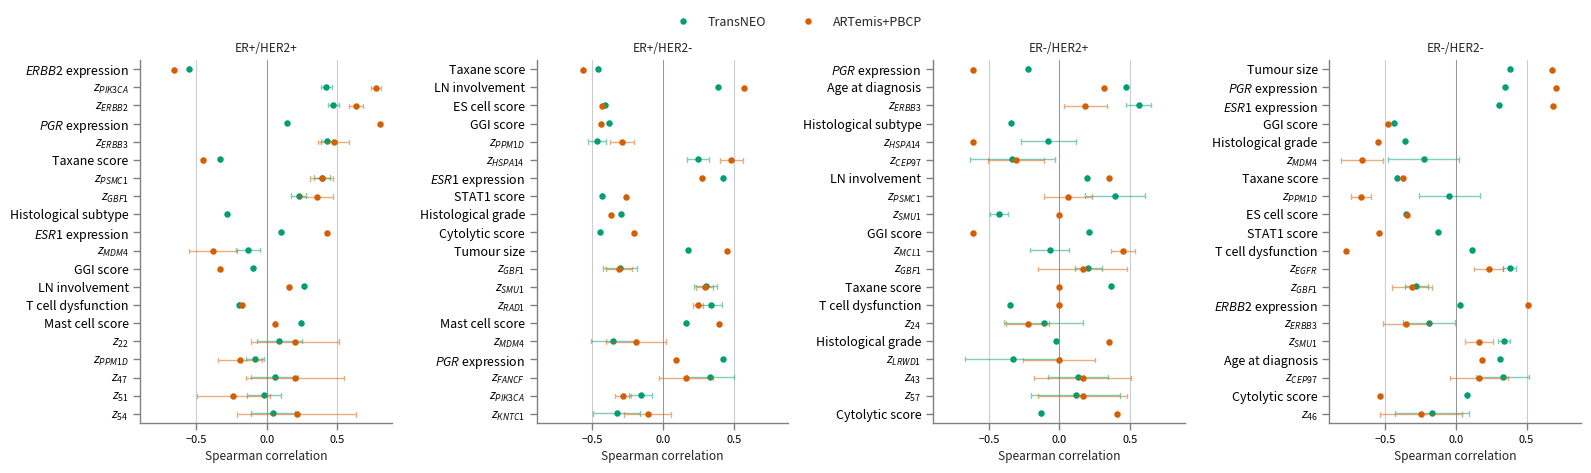

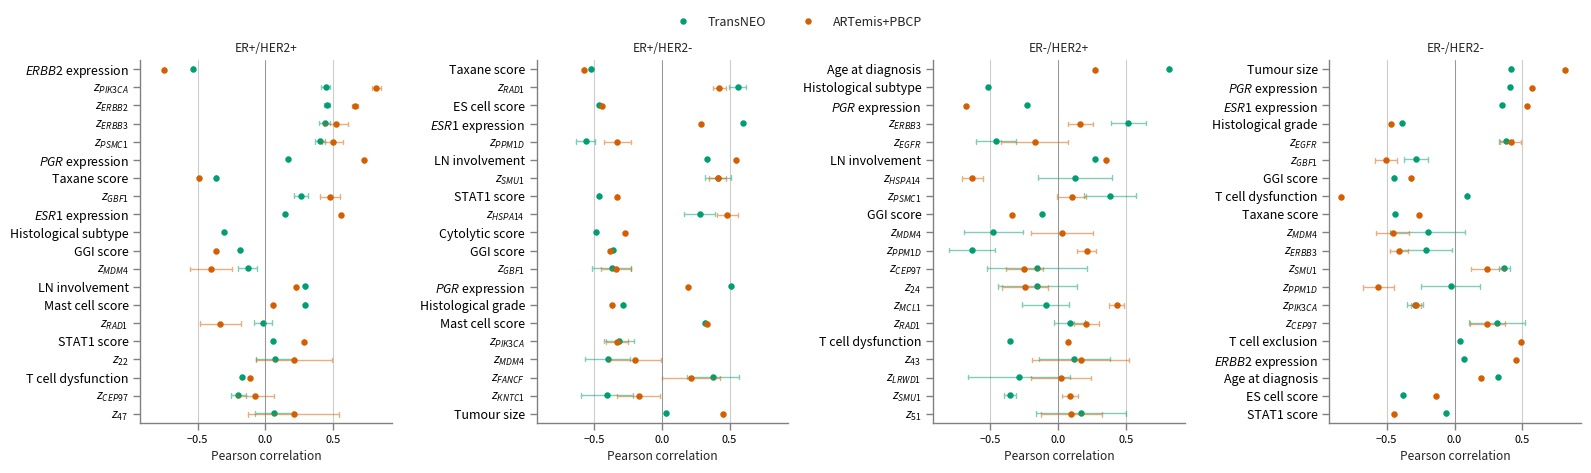

In [9]:
for metric in ["spearmanr", "pearsonr"]:
    palette = sns.color_palette("colorblind")[2:]

    corrs_subtype_df_val = pd.DataFrame.from_dict(corrs_subtype_val).reset_index()

    corrs_subtype_df = pd.DataFrame.from_dict(corrs_subtype).reset_index()

    corrs_subtype_df_val["dataset"] = "ARTemis+PBCP"
    corrs_subtype_df["dataset"] = "TransNEO"

    corrs_subtype_df = pd.concat(
        [corrs_subtype_df_val, corrs_subtype_df], axis=0
    ).reset_index()

    corrs_subtype_df["mean_spearmanr"] = (
        corrs_subtype_df.groupby(["dataset", "feat"])
        .transform("mean")["spearmanr"]
        .astype(float)
    )
    corrs_subtype_df["mean_pearsonr"] = (
        corrs_subtype_df.groupby(["dataset", "feat"])
        .transform("mean")["pearsonr"]
        .astype(float)
    )

    corrs_subtype_df["abs_spearmanr"] = (
        corrs_subtype_df["spearmanr"].abs().astype(float)
    )
    corrs_subtype_df["abs_pearsonr"] = corrs_subtype_df["pearsonr"].abs().astype(float)

    corrs_subtype_df["feat"] = corrs_subtype_df["feat"].apply(lambda x: x.split("_"))
    corrs_subtype_df["feat"] = corrs_subtype_df["feat"].apply(
        lambda x: f"$z_{{{x[1]}}}$" if x[0] == "z" else names_map[x[1]]
    )

    # Create a new empty DataFrame to store sorted entries
    sorted_corrs = []

    # Sort 'feat' within each subtype independently
    for subtype, df_sub in corrs_subtype_df.groupby("subtype"):
        # Compute mean correlation across datasets for ordering
        order = (
            df_sub.groupby("feat")[metric]
            .mean()
            .sort_values(ascending=False, key=abs)
            .index
        )

        # Convert feat to ordered categorical
        df_sub = df_sub.copy()
        df_sub["feat"] = pd.Categorical(df_sub["feat"], categories=order, ordered=True)

        sorted_corrs.append(df_sub)

    # Concatenate sorted chunks
    corrs_subtype_df = pd.concat(sorted_corrs, axis=0)

    print(corrs_subtype_df)

    # Store your subtypes
    subtypes = corrs_subtype_df["subtype"].unique()

    # Set color palette
    palette = sns.color_palette("colorblind")[2:]

    # Create subplots with one axis per subtype
    fig, axes = plt.subplots(
        1, len(subtypes), figsize=(4 * len(subtypes), 4.5), sharex=True, sharey=False
    )

    if len(subtypes) == 1:
        axes = [axes]  # Make iterable if only one axis

    for ax, subtype in zip(axes, subtypes):
        df_sub = corrs_subtype_df[corrs_subtype_df["subtype"] == subtype].copy()

        # Get ordering for this facet
        order = (
            df_sub.groupby("feat")[metric]
            .mean()
            .sort_values(ascending=False, key=abs)
            .head(20)
            .index
        )
        df_sub["feat"] = pd.Categorical(df_sub["feat"], categories=order, ordered=True)

        # Plot each dataset
        sns.pointplot(
            data=df_sub.sort_values(by="dataset", ascending=False),
            x=metric,
            y="feat",
            hue="dataset",
            dodge=True,
            errorbar=("sd", 1),
            capsize=0.25,
            ax=ax,
            linestyle="",
            palette=palette,
            legend=True,
            markersize=3,
            err_kws={"linewidth": 1, "alpha": 0.5},
        )

        ax.set_title(f"{subtype}")
        ax.set_xlabel(
            {
                "spearmanr": "Spearman correlation",
                "abs_spearmanr": "Abs. Spearman correlation",
                "pearsonr": "Pearson correlation",
                "abs_pearsonr": "Abs. Pearson correlation",
            }.get(metric, metric)
        )
        ax.axvline(0, color="grey", lw=0.5)
        ax.grid(True, axis="x")
        ax.set_ylabel("")
        ax.tick_params(axis="y", labelsize=10)
        sns.despine(ax=ax)

    # Remove legends from individual axes
    for ax in axes:
        ax.legend_.remove()

    # Create a global legend from the first plot
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(
        handles,
        labels,
        loc="lower center",  # or 'upper center', 'right', etc.
        ncol=len(labels),  # horizontal layout
        frameon=False,
        fontsize=10,
        bbox_to_anchor=(0.5, 0.97),  # (x, y) position relative to figure
    )

    # if ax != axes[0]:
    # ax.set_yticklabels([])  # Only show y labels on first facet

    plt.tight_layout()
    plt.savefig(
        f"./figures/transneo/{metric}_assocs_subtype_{rep_type}.svg",
        bbox_inches="tight",
    )
    plt.savefig(
        f"./figures/transneo/{metric}_assocs_subtype_{rep_type}.png",
        bbox_inches="tight",
        dpi=600,
    )

In [10]:
from sklearn.metrics import roc_auc_score
from functools import partial


def rep_renamer(x, constraints, prefix="z"):
    dim = int(x.split("_")[1])
    if dim < len(constraints):
        return f"{prefix}_{constraints[dim]}"
    else:
        return x


rep_type = "icovae_MCL1_16"
target = "RCB.score"
experiment = "artemis_pbcp"
model_type = "ElasticNet"


def pbc_corr(x1, x2):
    u_1 = len(np.unique(x1))
    u_2 = len(np.unique(x2))

    if min(u_1, u_2) == 2:
        res = pointbiserialr(x1, x2)
    else:
        res = spearmanr(x1, x2)

    return res[0]


class SigRes:
    def __init__(self, statistic, pvalue):
        self.statistic = statistic
        self.pvalue = pvalue


res_root = f"{wd_path}/data/outputs/depmap_gdsc_transneo/{target}/{experiment}/pico"
ext = "_Size.at.diagnosis_18"

model_path = f"{res_root}/{model_type}_{rep_type + ext}"

hue = None
row = "c_HER2.status"
col = "c_ER.status"


def mwu_auc(x, y, x_rd, x_pcr, feat):
    res = mannwhitneyu(x_rd[feat], x_pcr[feat])
    auc = roc_auc_score(y, x[feat])
    auc_neg = roc_auc_score(y, -1 * x[feat])
    auc = np.max([auc, auc_neg])

    return res, auc


def fisher_auc(x, y, x_rd, x_pcr, feat):
    cont_tab = pd.merge(
        x_rd[feat].value_counts(),
        x_pcr[feat].value_counts(),
        left_index=True,
        right_index=True,
        how="outer",
    ).fillna(0)

    auc = roc_auc_score(y, x[feat])
    auc_neg = roc_auc_score(y, -1 * x[feat])
    auc = np.max([auc, auc_neg])

    try:
        res = fisher_exact(cont_tab)
        res = SigRes(res[0], res[1])
    except:
        res = SigRes(1.0, 1.0)
        # print(f"{feat}, {auc}")

    return res, auc


pcr_assocs = []
for seed in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]:
    # LOAD ARGUMENTS
    with open(f"{model_path}/args_best_s{seed}.txt", "r") as f:
        args = json.load(f)

    print(args)

    constraints = args["constraints"]
    n_constraints = len(constraints)
    confounders = args["confounders"]
    if confounders is None:
        n_confounders = 0
    else:
        n_confounders = len(confounders)

    # Load predictions
    test_z = pd.read_csv(f"{model_path}/z_pred_test_s{seed}.csv")
    train_z = pd.read_csv(f"{model_path}/z_pred_train_s{seed}.csv")

    # Rename test df
    test_z_rep_z = test_z.iloc[:, test_z.columns.str.startswith("z")]
    test_z_rep_c = test_z.iloc[:, test_z.columns.str.startswith("c")]
    test_z_rep_y = test_z[["y"]]
    test_z_rep_z = test_z_rep_z.rename(
        mapper=partial(rep_renamer, constraints=constraints, prefix="z"), axis=1
    )
    test_z_rep_c = test_z_rep_c.rename(
        mapper=partial(rep_renamer, constraints=confounders, prefix="c"), axis=1
    )
    test_z_rep_y = test_z_rep_y.rename({"y": target}, axis=1)

    test_z_rep = pd.concat([test_z_rep_z, test_z_rep_c, test_z_rep_y], axis=1).dropna(
        axis=0
    )

    # Rename train df
    train_z_rep_z = train_z.iloc[:, train_z.columns.str.startswith("z")]
    train_z_rep_c = train_z.iloc[:, train_z.columns.str.startswith("c")]
    train_z_rep_y = train_z[["y"]]
    train_z_rep_z = train_z_rep_z.rename(
        mapper=partial(rep_renamer, constraints=constraints, prefix="z"), axis=1
    )
    train_z_rep_c = train_z_rep_c.rename(
        mapper=partial(rep_renamer, constraints=confounders, prefix="c"), axis=1
    )
    train_z_rep_y = train_z_rep_y.rename({"y": target}, axis=1)

    train_z_rep = pd.concat(
        [train_z_rep_z, train_z_rep_c, train_z_rep_y], axis=1
    ).dropna(axis=0)

    for i, df in enumerate([train_z_rep, test_z_rep]):
        x_00_pcr = df.loc[(df[target] == 1) & (df[col] < 0) & (df[row] < 0)]
        x_10_pcr = df.loc[(df[target] == 1) & (df[col] > 0) & (df[row] > 0)]
        x_01_pcr = df.loc[(df[target] == 1) & (df[col] < 0) & (df[row] > 0)]
        x_11_pcr = df.loc[(df[target] == 1) & (df[col] > 0) & (df[row] > 0)]
        x_00_rd = df.loc[(df[target] == 0) & (df[col] < 0) & (df[row] < 0)]
        x_10_rd = df.loc[(df[target] == 0) & (df[col] > 0) & (df[row] < 0)]
        x_01_rd = df.loc[(df[target] == 0) & (df[col] < 0) & (df[row] > 0)]
        x_11_rd = df.loc[(df[target] == 0) & (df[col] > 0) & (df[row] > 0)]

        x_00 = df.loc[(df[col] < 0) & (df[row] < 0)]
        x_01 = df.loc[(df[col] < 0) & (df[row] > 0)]
        x_10 = df.loc[(df[col] > 0) & (df[row] < 0)]
        x_11 = df.loc[(df[col] > 0) & (df[row] > 0)]

        y_00 = x_00[target]
        y_01 = x_01[target]
        y_10 = x_10[target]
        y_11 = x_11[target]

        if i == 0:
            dataset = "TransNEO"
        else:
            dataset = "ARTemis+PBCP"

        for feat in df.columns:
            if feat != target:
                # Check if continuous else use Fisher's exact test
                if len(df[feat].unique()) > 2:
                    res_00, auc_00 = mwu_auc(x_00, y_00, x_00_rd, x_00_pcr, feat)
                    res_01, auc_01 = mwu_auc(x_01, y_01, x_01_rd, x_01_pcr, feat)
                    res_10, auc_10 = mwu_auc(x_10, y_10, x_10_rd, x_10_pcr, feat)
                    res_11, auc_11 = mwu_auc(x_11, y_11, x_11_rd, x_11_pcr, feat)
                else:
                    # print(np.stack((x_0_0_rd[feat].value_counts().to_numpy(), x_0_0_pcr[feat].value_counts().to_numpy()), axis=1))
                    res_00, auc_00 = fisher_auc(x_00, y_00, x_00_rd, x_00_pcr, feat)
                    res_01, auc_01 = fisher_auc(x_01, y_01, x_01_rd, x_01_pcr, feat)
                    res_10, auc_10 = fisher_auc(x_10, y_10, x_10_rd, x_10_pcr, feat)
                    res_11, auc_11 = fisher_auc(x_11, y_11, x_11_rd, x_11_pcr, feat)

                pcr_assocs.append(
                    {
                        "feat": feat,
                        "group": "ER-HER2-",
                        "p": res_00.pvalue,
                        "auc": auc_00,
                        "seed": seed,
                        "dataset": dataset,
                    }
                )
                pcr_assocs.append(
                    {
                        "feat": feat,
                        "group": "ER+HER2-",
                        "p": res_10.pvalue,
                        "auc": auc_10,
                        "seed": seed,
                        "dataset": dataset,
                    }
                )
                pcr_assocs.append(
                    {
                        "feat": feat,
                        "group": "ER-HER2+",
                        "p": res_01.pvalue,
                        "auc": auc_01,
                        "seed": seed,
                        "dataset": dataset,
                    }
                )
                pcr_assocs.append(
                    {
                        "feat": feat,
                        "group": "ER+HER2+",
                        "p": res_11.pvalue,
                        "auc": auc_11,
                        "seed": seed,
                        "dataset": dataset,
                    }
                )

{'target': 'RCB.score', 'dataset': 'depmap_gdsc_transneo', 'enc': 'iCoVAE', 'reg': 'ElasticNet', 'constraints': ['MCL1', 'PSMC1', 'FANCF', 'RAD1', 'PPM1D', 'SMU1', 'HSPA14', 'GBF1', 'MDM4', 'KNTC1', 'LRWD1', 'CEP97', 'ERBB2', 'ERBB3', 'EGFR', 'PIK3CA'], 'confounders': ['Size.at.diagnosis', 'LN.at.diagnosis', 'Age.at.diagnosis', 'Histology', 'ER.status', 'HER2.status', 'Grade.pre.chemotherapy', 'PGR.log2.tpm', 'ESR1.log2.tpm', 'ERBB2.log2.tpm', 'GGI.ssgsea.notnorm', 'ESC.ssgsea.notnorm', 'Swanton.PaclitaxelScore', 'STAT1.ssgsea.notnorm', 'TIDE.Dysfunction', 'TIDE.Exclusion', 'Danaher.Mast.cells', 'CytScore.log2'], 'seed': 10, 'data_dir': './data', 'norm': False, 'lindec': False, 'filt': 'uni_var', 'experiment': 'artemis_pbcp', 'cuda': False, 'norep': False, 'newstudy': True, 'enc_path': '/home/dk538/rds/hpc-work/graphdep/data/outputs/depmap_gdsc_transneo/RCB.score/artemis_pbcp/icovae_MCL1_16', 'test_samples': ['A002', 'A004', 'A005', 'A007', 'A010', 'A012', 'A014', 'A017', 'A023', 'A042

ValueError: `x` and `y` must be of nonzero size.

/tmp/ipykernel_911295/2026643115.py:84: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_yticklabels(axes[0].get_ymajorticklabels(), fontsize=10)
/tmp/ipykernel_911295/2026643115.py:85: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_yticklabels(axes[1].get_ymajorticklabels(), fontsize=10)
/tmp/ipykernel_911295/2026643115.py:86: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[2].set_yticklabels(axes[2].get_ymajorticklabels(), fontsize=10)
/tmp/ipykernel_911295/2026643115.py:87: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[3].set_yticklabels(axes[3].get_ymajorticklabels(), fontsize=10)


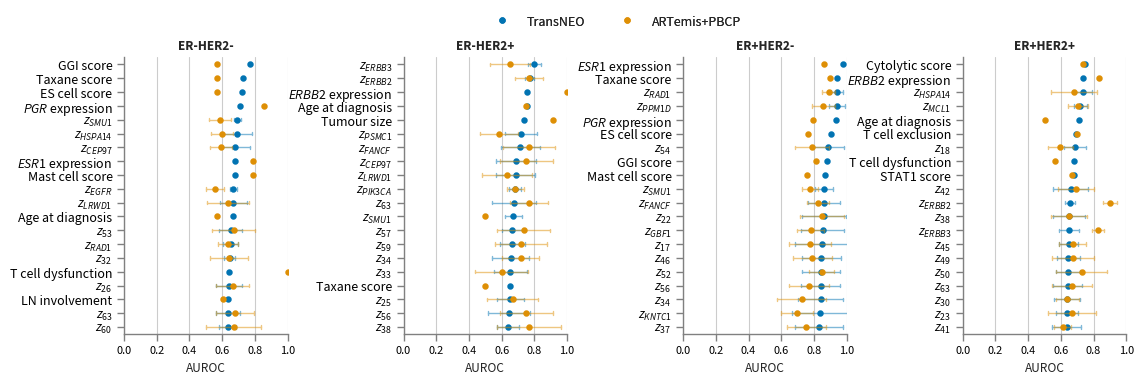

In [65]:
## PLOTTING
## DO AUPR, DO ALL SAMPLES
n_feats = 20

# dataset_map = {"train": "TransNEO", "val": "ARTemis+PBCP"}

pcr_assocs_df = pd.DataFrame(pcr_assocs)
pcr_assocs_df["logp"] = np.log(pcr_assocs_df["p"])

pcr_assocs_df["feat"] = pcr_assocs_df["feat"].apply(lambda x: x.split("_"))
pcr_assocs_df["feat"] = pcr_assocs_df["feat"].apply(
    lambda x: rf"$z_{{{x[1]}}}$" if x[0] == "z" else names_map[x[1]]
)

# pcr_assocs_df["dataset"] = pcr_assocs_df["dataset"].apply(lambda x: dataset_map[x])

pcr_assocs_df_mean = (
    pcr_assocs_df[pcr_assocs_df["dataset"] == "TransNEO"]
    .groupby(["feat", "group", "dataset"])
    .mean()
    .sort_values(by="auc", ascending=False)
    .groupby(["group", "dataset"])
    .head(n_feats)
    .reset_index()
    .set_index(["feat", "group"])
)
# print(pcr_assocs_df_mean)

col_order = ["ER-HER2-", "ER-HER2+", "ER+HER2-", "ER+HER2+"]

# pcr_assocs_df_plot = pcr_assocs_df.set_index(["feat", "group"]).loc[pcr_assocs_df_mean.index].reset_index()

pcr_assocs_df_hm = (
    pcr_assocs_df.set_index(["feat", "group"])
    .loc[pcr_assocs_df_mean.index]
    .reset_index()
    .pivot_table(index=["dataset", "group"], columns="feat", values="auc")
)

g1 = sns.catplot(
    data=pcr_assocs_df.set_index(["feat", "group"])
    .loc[pcr_assocs_df_mean.index]
    .reset_index(),
    height=n_feats / 5.5,
    aspect=0.8,
    kind="point",
    col="group",
    col_order=col_order,
    sharey=False,
    sharex=True,
    x="auc",
    y="feat",
    hue="dataset",
    errorbar=("sd", 1),
    capsize=0.25,
    linestyle="none",
    markersize=3,
    err_kws={"linewidth": 1, "alpha": 0.5},
    palette="colorblind",
)
axes = g1.axes.flatten()
for i, ax in enumerate(axes):
    # ax.invert_xaxis()
    ax.set_title(col_order[i], fontweight="semibold")
    ax.set_xlabel("AUROC")
    ax.set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.grid(visible=True, axis="x")
    ax.set_xlim(0, 1)
    ax.set_ylabel("")
sns.despine()

handles, labels = plt.gca().get_legend_handles_labels()

leg1 = axes[0].legend(
    handles=handles,
    bbox_to_anchor=(3.0, 1.2),
    loc="upper center",
    frameon=False,
    ncol=2,
    fontsize=10,
)
axes[0].add_artist(leg1)
g1._legend.remove()
axes[0].set_yticklabels(axes[0].get_ymajorticklabels(), fontsize=10)
axes[1].set_yticklabels(axes[1].get_ymajorticklabels(), fontsize=10)
axes[2].set_yticklabels(axes[2].get_ymajorticklabels(), fontsize=10)
axes[3].set_yticklabels(axes[3].get_ymajorticklabels(), fontsize=10)

plt.savefig(
    f"./figures/transneo/pcr_assocs_4_{rep_type}_{row}_{n_feats}.svg",
    bbox_inches="tight",
)
plt.savefig(
    f"./figures/transneo/pcr_assocs_4_{rep_type}_{row}_{n_feats}.png",
    bbox_inches="tight",
    dpi=600,
)

# print(pcr_assocs_df_hm)

# f, ax = plt.subplots(1,2, figsize=(5,5), sharey=False)
# sns.heatmap(pcr_assocs_df_hm.loc(axis=0)[:, "HER2-"].transpose().dropna(axis=0), square=True, cmap="Blues", yticklabels=True, xticklabels=True, ax=ax[0], vmin=0, vmax=1)
# sns.heatmap(pcr_assocs_df_hm.loc(axis=0)[:, "HER2+"].transpose().dropna(axis=0), square=True, cmap="Blues", yticklabels=True, xticklabels=True, ax=ax[1], vmin=0, vmax=1)

## 4.3 Representation UMAPs

{'target': 'RCB.score', 'dataset': 'depmap_gdsc_transneo', 'enc': 'iCoVAE', 'reg': 'ElasticNet', 'constraints': ['MCL1', 'PSMC1', 'FANCF', 'RAD1', 'PPM1D', 'SMU1', 'HSPA14', 'GBF1', 'MDM4', 'KNTC1', 'LRWD1', 'CEP97', 'ERBB2', 'ERBB3', 'EGFR', 'PIK3CA'], 'confounders': ['Size.at.diagnosis', 'LN.at.diagnosis', 'Age.at.diagnosis', 'Histology', 'ER.status', 'HER2.status', 'Grade.pre.chemotherapy', 'PGR.log2.tpm', 'ESR1.log2.tpm', 'ERBB2.log2.tpm', 'GGI.ssgsea.notnorm', 'ESC.ssgsea.notnorm', 'Swanton.PaclitaxelScore', 'STAT1.ssgsea.notnorm', 'TIDE.Dysfunction', 'TIDE.Exclusion', 'Danaher.Mast.cells', 'CytScore.log2'], 'seed': 10, 'data_dir': './data', 'norm': False, 'lindec': False, 'filt': 'uni_var', 'experiment': 'artemis_pbcp', 'cuda': False, 'norep': False, 'newstudy': True, 'enc_path': '/home/dk538/rds/hpc-work/graphdep/data/outputs/depmap_gdsc_transneo/RCB.score/artemis_pbcp/icovae_MCL1_16', 'test_samples': ['A002', 'A004', 'A005', 'A007', 'A010', 'A012', 'A014', 'A017', 'A023', 'A042

/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


{'target': 'RCB.score', 'dataset': 'depmap_gdsc_transneo', 'enc': 'iCoVAE', 'reg': 'ElasticNet', 'constraints': ['MCL1', 'PSMC1', 'FANCF', 'RAD1', 'PPM1D', 'SMU1', 'HSPA14', 'GBF1', 'MDM4', 'KNTC1', 'LRWD1', 'CEP97', 'ERBB2', 'ERBB3', 'EGFR', 'PIK3CA'], 'confounders': ['Size.at.diagnosis', 'LN.at.diagnosis', 'Age.at.diagnosis', 'Histology', 'ER.status', 'HER2.status', 'Grade.pre.chemotherapy', 'PGR.log2.tpm', 'ESR1.log2.tpm', 'ERBB2.log2.tpm', 'GGI.ssgsea.notnorm', 'ESC.ssgsea.notnorm', 'Swanton.PaclitaxelScore', 'STAT1.ssgsea.notnorm', 'TIDE.Dysfunction', 'TIDE.Exclusion', 'Danaher.Mast.cells', 'CytScore.log2'], 'seed': 20, 'data_dir': './data', 'norm': False, 'lindec': False, 'filt': 'uni_var', 'experiment': 'artemis_pbcp', 'cuda': False, 'norep': False, 'newstudy': True, 'enc_path': '/home/dk538/rds/hpc-work/graphdep/data/outputs/depmap_gdsc_transneo/RCB.score/artemis_pbcp/icovae_MCL1_16', 'test_samples': ['A002', 'A004', 'A005', 'A007', 'A010', 'A012', 'A014', 'A017', 'A023', 'A042

/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


{'target': 'RCB.score', 'dataset': 'depmap_gdsc_transneo', 'enc': 'iCoVAE', 'reg': 'ElasticNet', 'constraints': ['MCL1', 'PSMC1', 'FANCF', 'RAD1', 'PPM1D', 'SMU1', 'HSPA14', 'GBF1', 'MDM4', 'KNTC1', 'LRWD1', 'CEP97', 'ERBB2', 'ERBB3', 'EGFR', 'PIK3CA'], 'confounders': ['Size.at.diagnosis', 'LN.at.diagnosis', 'Age.at.diagnosis', 'Histology', 'ER.status', 'HER2.status', 'Grade.pre.chemotherapy', 'PGR.log2.tpm', 'ESR1.log2.tpm', 'ERBB2.log2.tpm', 'GGI.ssgsea.notnorm', 'ESC.ssgsea.notnorm', 'Swanton.PaclitaxelScore', 'STAT1.ssgsea.notnorm', 'TIDE.Dysfunction', 'TIDE.Exclusion', 'Danaher.Mast.cells', 'CytScore.log2'], 'seed': 30, 'data_dir': './data', 'norm': False, 'lindec': False, 'filt': 'uni_var', 'experiment': 'artemis_pbcp', 'cuda': False, 'norep': False, 'newstudy': True, 'enc_path': '/home/dk538/rds/hpc-work/graphdep/data/outputs/depmap_gdsc_transneo/RCB.score/artemis_pbcp/icovae_MCL1_16', 'test_samples': ['A002', 'A004', 'A005', 'A007', 'A010', 'A012', 'A014', 'A017', 'A023', 'A042

/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


{'target': 'RCB.score', 'dataset': 'depmap_gdsc_transneo', 'enc': 'iCoVAE', 'reg': 'ElasticNet', 'constraints': ['MCL1', 'PSMC1', 'FANCF', 'RAD1', 'PPM1D', 'SMU1', 'HSPA14', 'GBF1', 'MDM4', 'KNTC1', 'LRWD1', 'CEP97', 'ERBB2', 'ERBB3', 'EGFR', 'PIK3CA'], 'confounders': ['Size.at.diagnosis', 'LN.at.diagnosis', 'Age.at.diagnosis', 'Histology', 'ER.status', 'HER2.status', 'Grade.pre.chemotherapy', 'PGR.log2.tpm', 'ESR1.log2.tpm', 'ERBB2.log2.tpm', 'GGI.ssgsea.notnorm', 'ESC.ssgsea.notnorm', 'Swanton.PaclitaxelScore', 'STAT1.ssgsea.notnorm', 'TIDE.Dysfunction', 'TIDE.Exclusion', 'Danaher.Mast.cells', 'CytScore.log2'], 'seed': 40, 'data_dir': './data', 'norm': False, 'lindec': False, 'filt': 'uni_var', 'experiment': 'artemis_pbcp', 'cuda': False, 'norep': False, 'newstudy': True, 'enc_path': '/home/dk538/rds/hpc-work/graphdep/data/outputs/depmap_gdsc_transneo/RCB.score/artemis_pbcp/icovae_MCL1_16', 'test_samples': ['A002', 'A004', 'A005', 'A007', 'A010', 'A012', 'A014', 'A017', 'A023', 'A042

/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


{'target': 'RCB.score', 'dataset': 'depmap_gdsc_transneo', 'enc': 'iCoVAE', 'reg': 'ElasticNet', 'constraints': ['MCL1', 'PSMC1', 'FANCF', 'RAD1', 'PPM1D', 'SMU1', 'HSPA14', 'GBF1', 'MDM4', 'KNTC1', 'LRWD1', 'CEP97', 'ERBB2', 'ERBB3', 'EGFR', 'PIK3CA'], 'confounders': ['Size.at.diagnosis', 'LN.at.diagnosis', 'Age.at.diagnosis', 'Histology', 'ER.status', 'HER2.status', 'Grade.pre.chemotherapy', 'PGR.log2.tpm', 'ESR1.log2.tpm', 'ERBB2.log2.tpm', 'GGI.ssgsea.notnorm', 'ESC.ssgsea.notnorm', 'Swanton.PaclitaxelScore', 'STAT1.ssgsea.notnorm', 'TIDE.Dysfunction', 'TIDE.Exclusion', 'Danaher.Mast.cells', 'CytScore.log2'], 'seed': 50, 'data_dir': './data', 'norm': False, 'lindec': False, 'filt': 'uni_var', 'experiment': 'artemis_pbcp', 'cuda': False, 'norep': False, 'newstudy': True, 'enc_path': '/home/dk538/rds/hpc-work/graphdep/data/outputs/depmap_gdsc_transneo/RCB.score/artemis_pbcp/icovae_MCL1_16', 'test_samples': ['A002', 'A004', 'A005', 'A007', 'A010', 'A012', 'A014', 'A017', 'A023', 'A042

/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


{'target': 'RCB.score', 'dataset': 'depmap_gdsc_transneo', 'enc': 'iCoVAE', 'reg': 'ElasticNet', 'constraints': ['MCL1', 'PSMC1', 'FANCF', 'RAD1', 'PPM1D', 'SMU1', 'HSPA14', 'GBF1', 'MDM4', 'KNTC1', 'LRWD1', 'CEP97', 'ERBB2', 'ERBB3', 'EGFR', 'PIK3CA'], 'confounders': ['Size.at.diagnosis', 'LN.at.diagnosis', 'Age.at.diagnosis', 'Histology', 'ER.status', 'HER2.status', 'Grade.pre.chemotherapy', 'PGR.log2.tpm', 'ESR1.log2.tpm', 'ERBB2.log2.tpm', 'GGI.ssgsea.notnorm', 'ESC.ssgsea.notnorm', 'Swanton.PaclitaxelScore', 'STAT1.ssgsea.notnorm', 'TIDE.Dysfunction', 'TIDE.Exclusion', 'Danaher.Mast.cells', 'CytScore.log2'], 'seed': 60, 'data_dir': './data', 'norm': False, 'lindec': False, 'filt': 'uni_var', 'experiment': 'artemis_pbcp', 'cuda': False, 'norep': False, 'newstudy': True, 'enc_path': '/home/dk538/rds/hpc-work/graphdep/data/outputs/depmap_gdsc_transneo/RCB.score/artemis_pbcp/icovae_MCL1_16', 'test_samples': ['A002', 'A004', 'A005', 'A007', 'A010', 'A012', 'A014', 'A017', 'A023', 'A042

/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


{'target': 'RCB.score', 'dataset': 'depmap_gdsc_transneo', 'enc': 'iCoVAE', 'reg': 'ElasticNet', 'constraints': ['MCL1', 'PSMC1', 'FANCF', 'RAD1', 'PPM1D', 'SMU1', 'HSPA14', 'GBF1', 'MDM4', 'KNTC1', 'LRWD1', 'CEP97', 'ERBB2', 'ERBB3', 'EGFR', 'PIK3CA'], 'confounders': ['Size.at.diagnosis', 'LN.at.diagnosis', 'Age.at.diagnosis', 'Histology', 'ER.status', 'HER2.status', 'Grade.pre.chemotherapy', 'PGR.log2.tpm', 'ESR1.log2.tpm', 'ERBB2.log2.tpm', 'GGI.ssgsea.notnorm', 'ESC.ssgsea.notnorm', 'Swanton.PaclitaxelScore', 'STAT1.ssgsea.notnorm', 'TIDE.Dysfunction', 'TIDE.Exclusion', 'Danaher.Mast.cells', 'CytScore.log2'], 'seed': 70, 'data_dir': './data', 'norm': False, 'lindec': False, 'filt': 'uni_var', 'experiment': 'artemis_pbcp', 'cuda': False, 'norep': False, 'newstudy': True, 'enc_path': '/home/dk538/rds/hpc-work/graphdep/data/outputs/depmap_gdsc_transneo/RCB.score/artemis_pbcp/icovae_MCL1_16', 'test_samples': ['A002', 'A004', 'A005', 'A007', 'A010', 'A012', 'A014', 'A017', 'A023', 'A042

/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


{'target': 'RCB.score', 'dataset': 'depmap_gdsc_transneo', 'enc': 'iCoVAE', 'reg': 'ElasticNet', 'constraints': ['MCL1', 'PSMC1', 'FANCF', 'RAD1', 'PPM1D', 'SMU1', 'HSPA14', 'GBF1', 'MDM4', 'KNTC1', 'LRWD1', 'CEP97', 'ERBB2', 'ERBB3', 'EGFR', 'PIK3CA'], 'confounders': ['Size.at.diagnosis', 'LN.at.diagnosis', 'Age.at.diagnosis', 'Histology', 'ER.status', 'HER2.status', 'Grade.pre.chemotherapy', 'PGR.log2.tpm', 'ESR1.log2.tpm', 'ERBB2.log2.tpm', 'GGI.ssgsea.notnorm', 'ESC.ssgsea.notnorm', 'Swanton.PaclitaxelScore', 'STAT1.ssgsea.notnorm', 'TIDE.Dysfunction', 'TIDE.Exclusion', 'Danaher.Mast.cells', 'CytScore.log2'], 'seed': 80, 'data_dir': './data', 'norm': False, 'lindec': False, 'filt': 'uni_var', 'experiment': 'artemis_pbcp', 'cuda': False, 'norep': False, 'newstudy': True, 'enc_path': '/home/dk538/rds/hpc-work/graphdep/data/outputs/depmap_gdsc_transneo/RCB.score/artemis_pbcp/icovae_MCL1_16', 'test_samples': ['A002', 'A004', 'A005', 'A007', 'A010', 'A012', 'A014', 'A017', 'A023', 'A042

/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


{'target': 'RCB.score', 'dataset': 'depmap_gdsc_transneo', 'enc': 'iCoVAE', 'reg': 'ElasticNet', 'constraints': ['MCL1', 'PSMC1', 'FANCF', 'RAD1', 'PPM1D', 'SMU1', 'HSPA14', 'GBF1', 'MDM4', 'KNTC1', 'LRWD1', 'CEP97', 'ERBB2', 'ERBB3', 'EGFR', 'PIK3CA'], 'confounders': ['Size.at.diagnosis', 'LN.at.diagnosis', 'Age.at.diagnosis', 'Histology', 'ER.status', 'HER2.status', 'Grade.pre.chemotherapy', 'PGR.log2.tpm', 'ESR1.log2.tpm', 'ERBB2.log2.tpm', 'GGI.ssgsea.notnorm', 'ESC.ssgsea.notnorm', 'Swanton.PaclitaxelScore', 'STAT1.ssgsea.notnorm', 'TIDE.Dysfunction', 'TIDE.Exclusion', 'Danaher.Mast.cells', 'CytScore.log2'], 'seed': 90, 'data_dir': './data', 'norm': False, 'lindec': False, 'filt': 'uni_var', 'experiment': 'artemis_pbcp', 'cuda': False, 'norep': False, 'newstudy': True, 'enc_path': '/home/dk538/rds/hpc-work/graphdep/data/outputs/depmap_gdsc_transneo/RCB.score/artemis_pbcp/icovae_MCL1_16', 'test_samples': ['A002', 'A004', 'A005', 'A007', 'A010', 'A012', 'A014', 'A017', 'A023', 'A042

/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


{'target': 'RCB.score', 'dataset': 'depmap_gdsc_transneo', 'enc': 'iCoVAE', 'reg': 'ElasticNet', 'constraints': ['MCL1', 'PSMC1', 'FANCF', 'RAD1', 'PPM1D', 'SMU1', 'HSPA14', 'GBF1', 'MDM4', 'KNTC1', 'LRWD1', 'CEP97', 'ERBB2', 'ERBB3', 'EGFR', 'PIK3CA'], 'confounders': ['Size.at.diagnosis', 'LN.at.diagnosis', 'Age.at.diagnosis', 'Histology', 'ER.status', 'HER2.status', 'Grade.pre.chemotherapy', 'PGR.log2.tpm', 'ESR1.log2.tpm', 'ERBB2.log2.tpm', 'GGI.ssgsea.notnorm', 'ESC.ssgsea.notnorm', 'Swanton.PaclitaxelScore', 'STAT1.ssgsea.notnorm', 'TIDE.Dysfunction', 'TIDE.Exclusion', 'Danaher.Mast.cells', 'CytScore.log2'], 'seed': 100, 'data_dir': './data', 'norm': False, 'lindec': False, 'filt': 'uni_var', 'experiment': 'artemis_pbcp', 'cuda': False, 'norep': False, 'newstudy': True, 'enc_path': '/home/dk538/rds/hpc-work/graphdep/data/outputs/depmap_gdsc_transneo/RCB.score/artemis_pbcp/icovae_MCL1_16', 'test_samples': ['A002', 'A004', 'A005', 'A007', 'A010', 'A012', 'A014', 'A017', 'A023', 'A04

/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


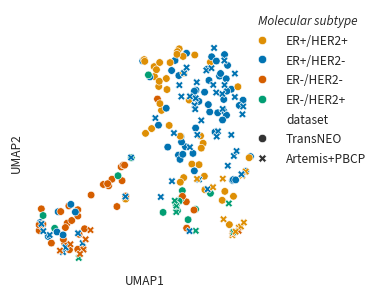

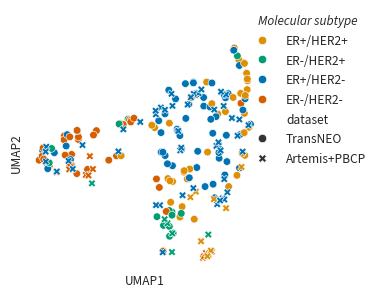

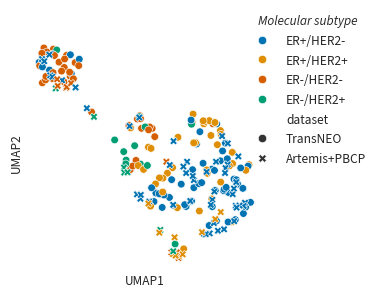

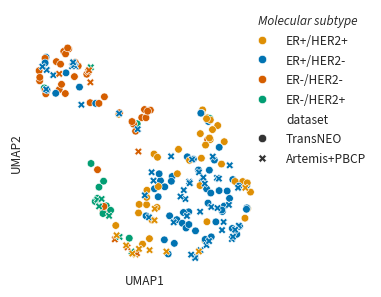

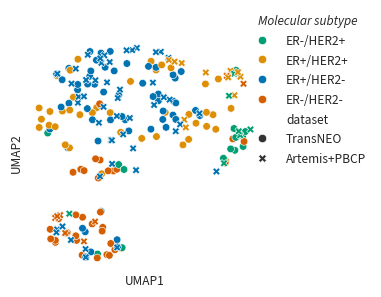

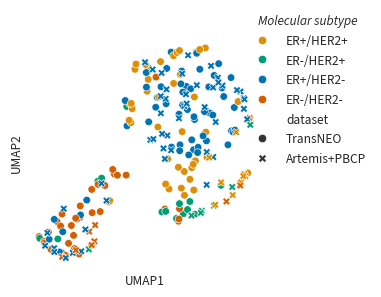

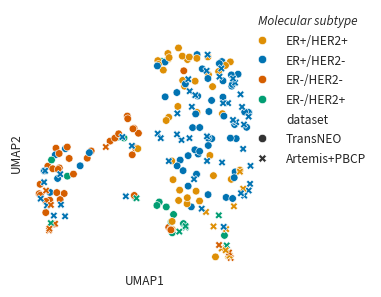

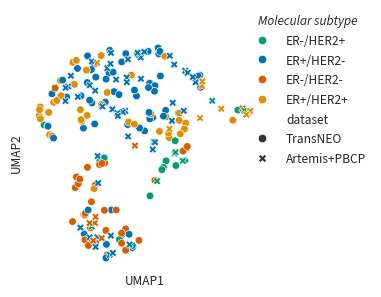

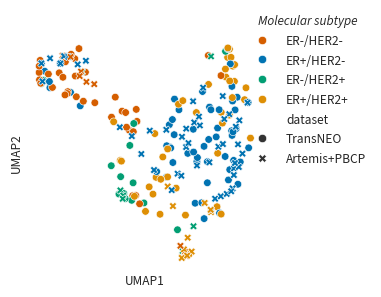

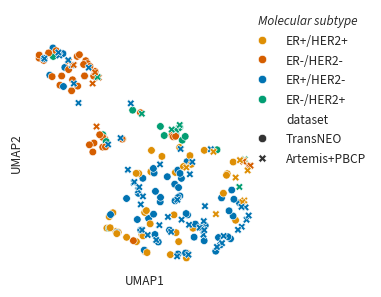

In [41]:
from umap import UMAP
from sklearn.preprocessing import StandardScaler

## SCATTER PLOT FEATURES
from scipy.stats import spearmanr
from functools import partial


def rep_renamer(x, constraints, prefix="z"):
    dim = int(x.split("_")[1])
    if dim < len(constraints):
        return f"{prefix}_{constraints[dim]}"
    else:
        return x


rep_type = "icovae_MCL1_16"
# rep_type = "vae"
target = "RCB.score"
experiment = "artemis_pbcp"
model_type = "ElasticNet"


def pbc_corr(x1, x2):
    u_1 = len(np.unique(x1))
    u_2 = len(np.unique(x2))

    if min(u_1, u_2) == 2:
        res = pointbiserialr(x1, x2)
    else:
        res = spearmanr(x1, x2)

    return res[0]


def plot_umap(x, hue, n_neighbors=20, seed=10):
    pal = sns.color_palette("colorblind")

    # merge dfs
    if hue in ["TP53", "PIK3CA", "PTEN"]:
        palette = {1.0: pal[0], 0.0: pal[1], "NA": "lightgrey"}
    elif hue.startswith(("z_", "GGI", "STAT1", "All.TMB", "Coding.TMB", "c_GGI")):
        palette = sns.color_palette("Blues", as_cmap=True)
    elif hue == "PAM50":
        palette = {
            "Basal": pal[0],
            "LumA": pal[1],
            "LumB": pal[2],
            "Her2": pal[3],
            "Normal": pal[4],
            "NA": "lightgrey",
        }
    elif hue == "c_MolType":
        palette = {
            "ER+/HER2-": pal[0],
            "ER+/HER2+": pal[1],
            "ER-/HER2+": pal[2],
            "ER-/HER2-": pal[3],
            "NA": "lightgrey",
        }
    else:
        palette = pal

    n_samp = len(x)
    print(f"n: {n_samp}")

    fig, ax = plt.subplots(1, 1, figsize=(3, 3))

    surv_rep_zs = x.loc[:, x.columns.str.startswith("z_")]

    # standardize z dimensions for t-SNE
    scaler = StandardScaler()
    surv_rep_zs = scaler.fit_transform(surv_rep_zs)

    results_tsne_df = UMAP(
        n_components=2,
        n_neighbors=n_neighbors,
        min_dist=0.01,
        random_state=seed,
    ).fit_transform(surv_rep_zs)

    results_tsne_df = pd.DataFrame(results_tsne_df).rename(
        {0: "UMAP1", 1: "UMAP2"}, axis=1
    )
    results_tsne_df.index = x.index

    results_tsne_df = pd.merge(results_tsne_df, x, left_index=True, right_index=True)

    sns.scatterplot(
        data=results_tsne_df,
        x="UMAP1",
        y="UMAP2",
        hue=hue,
        style="dataset",
        palette=palette,
        ax=ax,
        s=30,
    )
    plt.xticks([], [])
    plt.yticks([], [])

    sns.despine(bottom=True, top=True, left=True, right=True)

    h, l = ax.get_legend_handles_labels()
    # h, l = zip(*sorted(zip(h, l), key=lambda t: t[1]))
    h[5].text = "Dataset"
    h = h[1:]
    l = l[1:]

    for handle in h:
        handle.set_markersize(6.0)
    hue_map = {
        "c_PAM50": "PAM50 subtype",
        "c_NCN.PAM50": "PAM50 subtype",
        "c_ClinGroup": "Clinical subgroup",
        "TP53": "TP53 mutation status",
        "PIK3CA": "PIK3CA mutation status",
        "c_GGI.ssgsea.notnorm": "GGI score",
        "c_ER.status": "ER status",
        "c_HER2.status": "HER2 status",
        "c_Histology": "Histology",
        "c_MolType": "Molecular subtype",
        "dataset": "Dataset",
    }
    ax.legend(
        handles=h,
        labels=l,
        title=hue_map[hue],
        fontsize="medium",
        ncol=1,
        frameon=False,
        bbox_to_anchor=(1.20, 1.15),
        loc="upper center",
        title_fontproperties={"style": "italic", "size": "medium"},
    )

    # plt.legend('',frameon=False)
    plt.savefig(
        f"./figures/transneo/UMAP_{hue}_n{n_neighbors}_s{seed}.png",
        bbox_inches="tight",
        dpi=600,
    )
    plt.savefig(
        f"./figures/transneo/UMAP_{hue}_n{n_neighbors}_s{seed}.svg", bbox_inches="tight"
    )


res_root = f"{wd_path}/data/outputs/depmap_gdsc_transneo/{target}/{experiment}/pico"
ext = "_Size.at.diagnosis_18"

model_path = f"{res_root}/{model_type}_{rep_type + ext}"

corrs = []
corrs_val = []
for seed in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]:
    # LOAD ARGUMENTS
    with open(f"{model_path}/args_best_s{seed}.txt", "r") as f:
        args = json.load(f)

    print(args)

    constraints = args["constraints"]
    n_constraints = len(constraints)
    confounders = args["confounders"]
    if confounders is None:
        n_confounders = 0
    else:
        n_confounders = len(confounders)

    # Load predictions
    test_z = pd.read_csv(f"{model_path}/z_pred_test_s{seed}.csv")
    train_z = pd.read_csv(f"{model_path}/z_pred_train_s{seed}.csv")

    # Rename test df
    test_z_rep_z = test_z.iloc[:, test_z.columns.str.startswith("z")]
    test_z_rep_c = test_z.iloc[:, test_z.columns.str.startswith("c")]
    test_z_rep_z = test_z_rep_z.rename(
        mapper=partial(rep_renamer, constraints=constraints, prefix="z"), axis=1
    )
    test_z_rep_c = test_z_rep_c.rename(
        mapper=partial(rep_renamer, constraints=confounders, prefix="c"), axis=1
    )

    test_z_rep = pd.concat([test_z_rep_z, test_z_rep_c], axis=1)

    # Rename train df
    train_z_rep_z = train_z.iloc[:, train_z.columns.str.startswith("z")]
    train_z_rep_c = train_z.iloc[:, train_z.columns.str.startswith("c")]
    train_z_rep_z = train_z_rep_z.rename(
        mapper=partial(rep_renamer, constraints=constraints, prefix="z"), axis=1
    )
    train_z_rep_c = train_z_rep_c.rename(
        mapper=partial(rep_renamer, constraints=confounders, prefix="c"), axis=1
    )

    train_z_rep = pd.concat([train_z_rep_z, train_z_rep_c], axis=1)

    # Concatenate train and test
    test_z_rep["dataset"] = "Artemis+PBCP"
    train_z_rep["dataset"] = "TransNEO"
    train_z_rep = pd.concat([train_z_rep, test_z_rep], axis=0).reset_index()

    train_z_rep["c_ER.status"] = train_z_rep["c_ER.status"] > 0
    train_z_rep["c_HER2.status"] = train_z_rep["c_HER2.status"] > 0
    train_z_rep["c_MolType"] = train_z_rep["c_ER.status"].astype(str) + train_z_rep[
        "c_HER2.status"
    ].astype(str)

    moltype_map = {
        "TrueFalse": "ER+/HER2-",
        "TrueTrue": "ER+/HER2+",
        "FalseTrue": "ER-/HER2+",
        "FalseFalse": "ER-/HER2-",
    }

    train_z_rep["c_MolType"] = train_z_rep["c_MolType"].apply(lambda x: moltype_map[x])

    plot_umap(train_z_rep, hue="c_MolType", n_neighbors=15, seed=seed)